## imports and settings

In [4]:
import pickle
import csv
import json
import psycopg2
import statsmodels
import subprocess
import networkx as nx
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool
import pandas as pd
from collections import Counter
import itertools as itt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from gtfparse import read_gtf
import markov_clustering as mc

import matplotlib as mplt
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles

from pyexcel_xlsx import get_data

from Bio import SeqIO

In [721]:
prot_seq_dict = {}
for rec in SeqIO.parse('human-openprot-r0_0-refprots+altprots+isoforms-+uniprot2019_03_01.fasta', 'fasta'):
    tt_acc = rec.name.split('|')[0]
    prot_seq_dict[tt_acc] = rec.seq
    if '.' in tt_acc:
        prot_seq_dict[tt_acc.split('.')[0]] = rec.seq
    header = parse_fasta_header(rec.description)
    
    if 'PA' in header:
        for pa in header['PA']:
            prot_seq_dict[pa.split('.')[0]] = rec.seq
            
    if 'GN' in header:
        for gn in header['GN'].split(','):
            prot_seq_dict[gn] = rec.seq

In [777]:
# ftp://ftp.ensembl.org/pub/release-95/gtf/homo_sapiens
chroms = set([str(x) for x in range(1,23)] + ['X', 'Y', 'MT'])
genes_95 = []
with open('Homo_sapiens.GRCh38.95.gtf', 'r') as f:
    for n,l in enumerate(f):
        if l[0]=='#': continue
        ls        = l.split('\t')
        chrom, source, feature, start, end, score, strand, frame,  = ls[:8]
        if chrom not in chroms: continue
        attributes = ls[8].strip()
        att_ls     = attributes.split(';')
        att_dict   = {x.split('"')[0].strip(): x.split('"')[1].strip() for x in att_ls if len(x.split(' '))>1 if 'tag' not in x}
        tags = "|".join([x.split('"')[1].strip() for x in att_ls if 'tag' in x])
        if tags:
            att_dict.update({'tags':tags})
        feat_dict = dict(zip(['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame'],
                             [chrom, source, feature, int(start), int(end), score, strand, frame]))
        feat_dict.update(att_dict)
        genes_95.append(feat_dict)

In [780]:
gene_biotypes = {}
for gene in genes_95:
    if gene['feature']=='gene':
        gene_biotypes[gene['gene_name']] = gene['gene_biotype']

In [11]:
def is_alt(tt_acc):
    if any([x in tt_acc for x in ['IP_', ]]):
        return True
    return False

fields = ['OS', 'GN', 'TA', 'PA']
def parse_fasta_header(h):
    h = h.split()
    acc = h[0].split('|')[0]
    res = {}
    for f in h[1:]:
        for field in fields:
            if f[:2] == field:
                res[field] = f[3:]
    if 'GN' not in res:
        res['GN'] = 'unknown'
    if 'PA' in res  and ',' in res['PA']:
        res['PA'] = res['PA'].split(',')
    return res

In [14]:
protacc_syn_dict = {}
for rec in SeqIO.parse('human-openprot-r0_0-refprots+altprots+isoforms-+uniprot2019_03_01.fasta', 'fasta'):
    tt_acc = rec.name.split('|')[0]
    des = parse_fasta_header(rec.description)
    if 'PA' in des:
        for pa in des['PA']:
            protacc_syn_dict[pa] = tt_acc
            if '.' in pa:
                protacc_syn_dict[pa.split('.')[0]] = tt_acc

In [16]:
# DB access to openProt
op = OpenProt(79)

op_prot_gene = op.get_prot_gene_dict()
len(op_prot_gene)

779685

## Load PPI data

### load BioPlex 2.0 network data

In [19]:
def get_bioplex_network(baits=None):
    G_b = nx.Graph()
    with open('BioPlex_interactionList_v4a.tsv', 'r') as f:
        for n,l in enumerate(f):
            ls = l.strip().split('\t')
            if n==0:
                keys = ls
                continue
            line = dict(zip(keys, ls))
            if baits is not None:
                if line['SymbolA'] in baits or line['SymbolB'] in baits:
                    G_b.add_edge(line['SymbolA'], line['SymbolB'])
            else:
                G_b.add_edge(line['SymbolA'], line['SymbolB'])

    G_b_edges = set()
    for e in G_b.edges:
        G_b_edges.add(frozenset(e))
    print('nodes : {} (genes)\nedges : {}'.format(len(G_b), len(G_b_edges)))
    return G_b, G_b_edges

In [20]:
G_b, G_b_edges = get_bioplex_network()

nodes : 10961 (genes)
edges : 56553


In [21]:
bp3_net = set()
with open('BioPlex_293T_Network_10K_Dec_2019.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t', quotechar='"')
    for n,l in enumerate(reader):
        if n==0:
            keys = l
            continue
        line = dict(zip(keys, l))
        bp3_net.add(frozenset((line['SymbolA'], line['SymbolB'])))

In [1636]:
BP_unfilt = {}
all_baits = set()
with open('BaitPreyPairs_noFilters_BP2a.tsv', 'r') as f:
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys = ls
            continue
        line = dict(zip(keys, ls))
        BP_unfilt[frozenset((line['bait_symbol'], line['symbol']))] = float(line['pInt'])
        all_baits.add(line['bait_symbol'])
print(len(all_baits))

5891


## HCIP filter using Naive Bayes classifier

In [23]:
# Score functions
def compute_recall(HCIP, ref_edges_set):
    TP = HCIP.intersection(ref_edges_set)
    FN = ref_edges_set.difference(HCIP)
    return len(TP)/(len(TP) + len(FN))

def compute_precision(HCIP, ref_edges_set):
    TP = HCIP.intersection(ref_edges_set)
    FP = HCIP.difference(ref_edges_set)
    if len(TP) + len(FP) == 0:
        return 0.
    return len(TP)/(len(TP) + len(FP))

def compute_f1(HCIP, ref_edges_set):
    recall    = compute_recall(HCIP, ref_edges_set)
    precision = compute_precision(HCIP, ref_edges_set)
    if recall + precision == 0 :
        return 0.
    return (2 * recall * precision) / (recall + precision)

In [459]:
def compute_metrics_at_thres(thres):
    bp_predictions_9d = pickle.load(open('HCIP_pred_bioplex_op15_1pep.pkl', 'rb'))
    HCIP = []
    for pred in bp_predictions_9d:
        batch, bait, prey, target, pnoint_pint = pred
        if bait==prey:continue
        if pnoint_pint[1] < thres: continue # select only intercations over pint threshold of input thres
        HCIP.append(pred)
    
    HCIP_net = []
    for batch, bait, prey, target, pnoint_pint in HCIP:
        HCIP_net.append((bait, prey, pnoint_pint[1]))
    
    G_o_noalt = nx.Graph()
    G_o_noalt.add_edges_from([(x[0], x[1]) for x in HCIP_net if not is_alt(x[1])])
    G_o_noalt.remove_edges_from(nx.selfloop_edges(G_o_noalt))
    G_o_edges = set(frozenset(e) for e in G_o_noalt.edges)
    intersection = G_o_edges.intersection(G_b_edges)
    union = G_o_edges.union(G_b_edges)
    
    jacc      = len(intersection)/len(union)
    recall    = compute_recall(G_o_edges, G_b_edges)
    precision = compute_precision(G_o_edges, G_b_edges)
    fscore    = compute_f1(G_o_edges, G_b_edges)
    
    return jacc, recall, precision, fscore

In [25]:
thresholds = np.linspace(0., 1., 200)

scores = []
with Pool(20) as p:
    scores = p.map(compute_metrics_at_thres, thresholds)

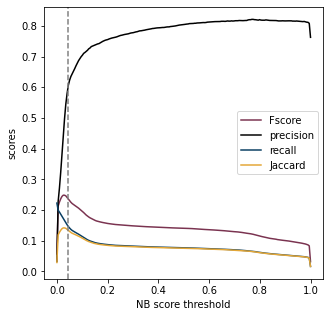

In [358]:
scores = [x for x in scores if type(x)==tuple]
jacc, recall, precision, fscore = zip(*scores)
thresholds = thresholds[:len(scores)]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(thresholds, fscore, label='Fscore', color='#7A3350')
ax.plot(thresholds, precision,  label='precision', color='k')
ax.plot(thresholds, recall, label='recall', color='#093E63')
ax.plot(thresholds, jacc, label='Jaccard', color='#E4A737')
ax.set_xlabel('NB score threshold')
ax.set_ylabel('scores')
plt.axvline(0.045, c='gray', linestyle='dashed')
plt.legend()
plt.savefig('bioplex_figures/comppass_plus_performance.svg')
plt.show()

Threshold: 0.045
Count unfiltered interactions: 391537
Count baits in unfiltered interactions: 3033
Count interactions HCIP (*bait-bait are counted twice): 14116
Count interactions filtered out by CompPASS Plus: 378151 (96.40143065819964% of unfiltered interactions)
Count interactions retained after CompPASS Plus: 14116 (3.5985693418003555% of unfiltered interactions)
Count HCIP baits: 2218
Count baits lost at CompPASS Plus: 815 (26.87108473458622% of unfiltered baits)
Count unique preys: 5648
count interactions with alts: 344
count unique alt preys:  279
count unique alt prey genes:  271
Count unique baits interacting with alts: 290
Count unique ref preys: 5369
Count unique all preys: 5648


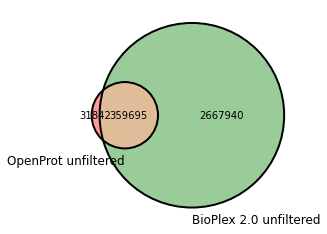

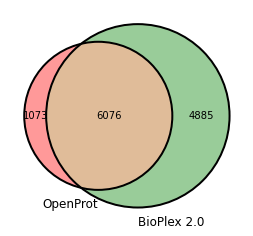

In [1702]:
thresh = 0.045
print('Threshold:', thresh)

bp_predictions_9d = pickle.load(open('HCIP_pred_bioplex_op15_1pep.pkl', 'rb'))

unfiltered_interactions = set(frozenset((x[1], x[2])) for x in bp_predictions_9d)
print('Count unfiltered interactions:', len(unfiltered_interactions))
OP_baits = set([x[1] for x in bp_predictions_9d])
len(OP_baits)
print('Count baits in unfiltered interactions:', len(OP_baits))

HCIP = []
alt_compass_score = {}
for pred in bp_predictions_9d:
    batch, bait, prey, target, pnoint_pint = pred
    if pnoint_pint[1] < thresh: continue # select only intercations over pint threshold
    if bait == prey : continue # remove self loops      
    if is_alt(prey):
        alt_compass_score[(bait, prey)] = pnoint_pint[1]

    HCIP.append(pred)

print('Count interactions HCIP (*bait-bait are counted twice):', len(HCIP))
print('Count interactions filtered out by CompPASS Plus: {} ({}% of unfiltered interactions)'.format(
    len(bp_predictions_9d)-len(HCIP), 100*(len(bp_predictions_9d)-len(HCIP))/len(bp_predictions_9d)
))
print('Count interactions retained after CompPASS Plus: {} ({}% of unfiltered interactions)'.format(
    len(HCIP), 100*len(HCIP)/len(bp_predictions_9d)
))
HCIP_baits = set(bait for batch, bait, prey, target, pnoint_pint in HCIP)
print('Count HCIP baits:', len(HCIP_baits))
print(
    'Count baits lost at CompPASS Plus: {} ({}% of unfiltered baits)'.format(
        len([b for b in list(OP_baits) if b not in HCIP_baits]),
        100*len([b for b in list(OP_baits) if b not in HCIP_baits])/len(OP_baits)
    )
)
print('Count unique preys:', len(set(prey for batch, bait, prey, target, pnoint_pint in HCIP)))
print('count interactions with alts:', sum(is_alt(x[2]) for x in HCIP))
HCIP_alts = set(prey for batch, bait, prey, target, pnoint_pint in HCIP if is_alt(prey))
print('count unique alt preys: ', len(HCIP_alts))
print('count unique alt prey genes: ', len(set(x.split('|')[1] for x in list(HCIP_alts))))

HCIP_net = [(bait, prey, pnoint_pint[1]) for batch, bait, prey, target, pnoint_pint in HCIP]
print('Count unique baits interacting with alts:', len(set(b for b,p,pint in HCIP_net if is_alt(p))))
HCIP_refs = set(p for b,p,pint in HCIP_net if not is_alt(p))
print('Count unique ref preys:', len(HCIP_refs))
HCIP_preys = set(p for b,p,pint in HCIP_net)
print('Count unique all preys:', len(HCIP_preys))

data=[unfiltered_interactions, set(BP_unfilt.keys())]
v=venn2(data, set_labels = ('OpenProt unfiltered', 'BioPlex 2.0 unfiltered'))
venn2_circles(data)
plt.savefig('bioplex_figures/OP_BP2_unfiltered.svg')
plt.show()

data=[set(G_o.nodes()), set(G_b.nodes())]
v=venn2(data, set_labels = ('OpenProt', 'BioPlex 2.0'))
venn2_circles(data)
plt.savefig('bioplex_figures/node_overlap_OP_BP2.svg')
plt.show()

In [1422]:
len(HCIP_refs.intersection(set(G_b.nodes())))/len(HCIP_refs)

0.8672005960141553

In [1493]:
def tt_type_node_attrs(G):    
    node_attrs = {}
    for n in G.nodes():
        node_attrs[n] = {}
        if is_alt(n):
            node_attrs[n]['tt_type'] = 'alt'
            node_attrs[n]['node_type'] = 'alt-prey'
        else:
            node_attrs[n]['tt_type'] = 'ref'
            if n in HCIP_baits:
                node_attrs[n]['node_type'] = 'ref-bait'
            else:
                node_attrs[n]['node_type'] = 'ref-prey'

    return node_attrs

Count total interactions: 14026
Count total ref-only interactions: 13682
Count total alt interactions: 344
BP2 Recalled interactions: 0.6057593919017688
BP3 Recalled interactions: 0.5831749744189446
count shared with BP3: 7979


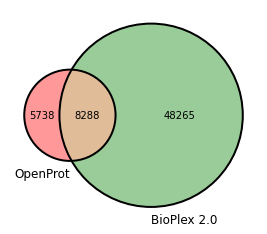

Bait median/mean degree: 4.0 7.076645626690713
Prey median/mean degree: 2.0 2.505779760697627


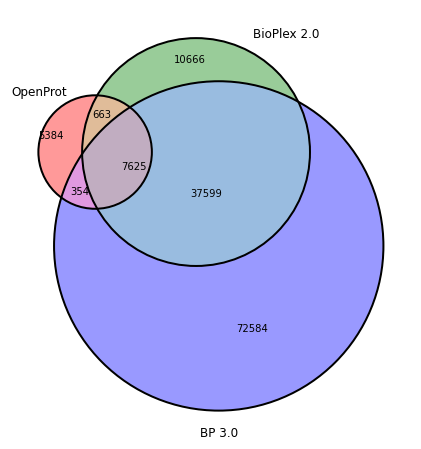

In [1703]:
HCIP_net = [(bait, prey, pnoint_pint[1]) for batch, bait, prey, target, pnoint_pint in HCIP]

G_o = nx.Graph()
G_o.add_edges_from([(b, p) for b,p,pint in HCIP_net])
G_o.remove_edges_from(nx.selfloop_edges(G_o))
G_o.remove_nodes_from([k for k,v in G_o.degree() if v<1])

G_o_noalt = nx.Graph()
G_o_noalt.add_edges_from([(x[0], x[1]) for x in HCIP_net if not is_alt(x[1])])
G_o_noalt.remove_edges_from(nx.selfloop_edges(G_o_noalt))
G_o_noalt.remove_nodes_from([node for node, degree in G_o_noalt.degree() if degree<1])
    
G_o_edges = set(frozenset(e) for e in G_o.edges)
G_o_edges_noalts = set(frozenset(e) for e in G_o_noalt.edges)

nx.set_node_attributes(G_o, tt_type_node_attrs(G_o))
nx.set_node_attributes(G_o_noalt, tt_type_node_attrs(G_o_noalt))

print('Count total interactions:', len(G_o_edges))
print('Count total ref-only interactions:', len(G_o_edges_noalts))
print('Count total alt interactions:', len([e for e in G_o.edges() if any(is_alt(n) for n in e)]))
print('BP2 Recalled interactions:', len(G_o_edges.intersection(G_b_edges))/len([e for e in G_o.edges() if not any(is_alt(n) for n in e)]))
print('BP3 Recalled interactions:', len(G_o_edges.intersection(bp3_net))/len([e for e in G_o.edges() if not any(is_alt(n) for n in e)]))
print('count shared with BP3:', len(G_o_edges.intersection(bp3_net)))

data=[G_o_edges, G_b_edges]
v=venn2(data, set_labels = ('OpenProt', 'BioPlex 2.0'))
venn2_circles(data)
plt.savefig('bioplex_figures/OP_BP2_overlap_venn_NB.svg')
plt.show()

deg = dict(G_o.degree)
bait_deg = [d for n,d in deg.items() if n in HCIP_baits]
prey_deg = [d for n,d in deg.items() if n not in HCIP_baits]
print('Bait median/mean degree:', np.median(bait_deg), np.mean(bait_deg))
print('Prey median/mean degree:', np.median(prey_deg), np.mean(prey_deg))

data=[G_o_edges, G_b_edges, bp3_net]
plt.figure(figsize=(8,8))
v=venn3(data, set_labels = ('OpenProt', 'BioPlex 2.0', 'BP 3.0'))
venn3_circles(data)
plt.savefig('bioplex_figures/OP_BP2_BP3_overlap_venn_NB.svg')
plt.show()

## Whole network characteristics

### Graphviz function

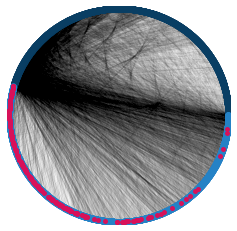

('bioplex_figures/full_net.png', 'bioplex_figures/full_net_legend.png')

In [381]:
deg_cen = nx.degree_centrality(G_o)

node_types = {}
for n in list(G_o.nodes())+list(G_o.nodes()):
    node_types[n] = {}
    if n in bait_batch_dict:
        node_types[n]['node_type'] = 'bait'
    else:
        node_types[n]['node_type'] = 'prey'
nx.set_node_attributes(G_o, node_types)

deg = G_o.degree()

pos = nx.circular_layout(sorted(G_o.nodes(), key=lambda x: [node_types[x]['node_type'], deg_cen[x]]))
get_graph_vis(G_o, '', 
              layout=nx.circular_layout,
              figsize=(4,4),
              pos=pos, 
              edge_alpha=0.01, 
              node_size=30, 
              file_name='bioplex_figures/full_net.png')

### All pairs shortest path

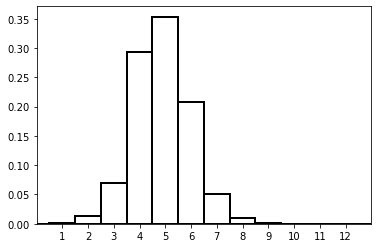

In [42]:
def batch_apsp(batch_nodes):
    apsp = {}
    for n in batch_nodes:
        ss_sp = Counter(nx.single_source_shortest_path_length(G, n).values())
        for c in ss_sp:
            if c not in apsp:
                apsp[c] = 0
            apsp[c] += ss_sp[c]
                
    return apsp

# reanalysis APSP
G = G_o.copy()
n_nodes = 1000
nodes_splited = [list(G.nodes())[i:i+n_nodes] for i in range(0, len(G.nodes()), n_nodes)]
pool = mp.Pool(12)
r = pool.map_async(batch_apsp, nodes_splited)
results = r.get()
pool.close()
pool.join()

# aggregate results from parallel runs
apsp = {}
for r in results:
    for sp_len in r:
        if sp_len in apsp:
            apsp[sp_len] += r[sp_len]
        else:
            apsp[sp_len] = r[sp_len]

n_pairs = sum(apsp.values())
whole_sp, whole_dens = zip(*[(k, v/n_pairs) for k,v in apsp.items()])
average_sp = sum(np.array(whole_sp) * np.array(apsp.values())) / n_pairs
fig, ax = plt.subplots()
width = 1.0
ax.bar(whole_sp,         whole_dens, width, edgecolor='k', color='w', linewidth=2 , alpha=1.0, label='whole network')
#ax.bar(np.array(ref_sp), ref_dens,   width, color='#006ba6', alpha=0.8, label='refProts')
#ax.bar(np.array(alt_sp), alt_dens,   width, color='#d81159', alpha=0.6, label='altProts')
plt.xticks(range(1, 13))
plt.xlim(0, 13)
#plt.legend()
plt.savefig('bioplex_figures/apsp_bar.svg')
plt.show()

### Degree distributions

In [367]:
degrees = G_o.degree()

mean ref-prey degree: 2.5821152192605332 median: 2.0
[35, 31, 26, 24, 23, 22, 19, 19, 18, 17, 17, 16, 15, 15, 15, 15, 15, 14, 14, 14]


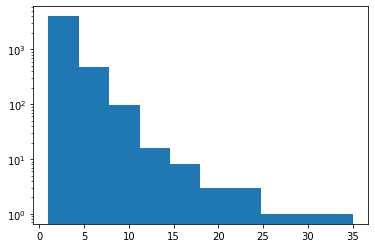

In [374]:
ref_prey_deg = [degrees[node] for node, node_attrs in G_o.nodes(data=True) if node_attrs['node_type']=='ref-prey']
print('mean ref-prey degree:', np.mean(ref_prey_deg), 'median:', np.median(ref_prey_deg))
print(sorted(ref_prey_deg, key=lambda x: -x)[:20])
plt.hist(ref_prey_deg)
plt.yscale('log')
plt.show()

-------------------------4-------------------------
1.5462534437570032


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


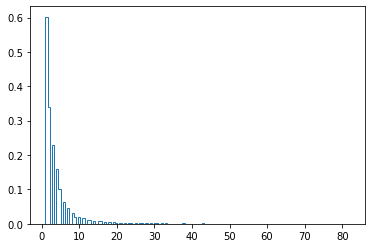

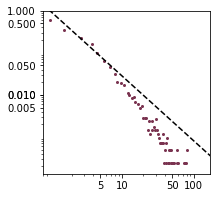

-------------------------5-------------------------
1.616232229979938


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


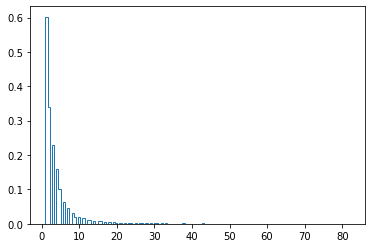

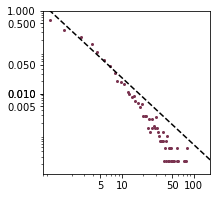

-------------------------6-------------------------
1.6879931525473966


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


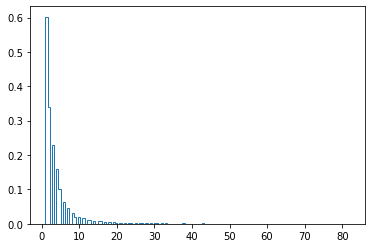

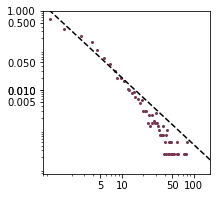

-------------------------7-------------------------
1.7629919759626869


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


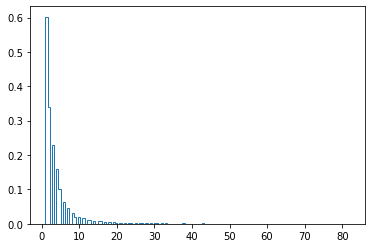

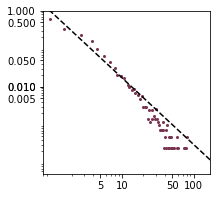

-------------------------8-------------------------
1.8425710676145715


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


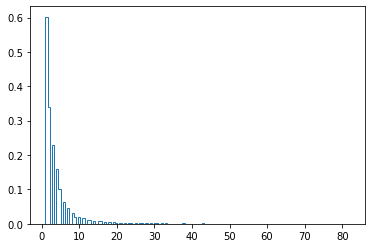

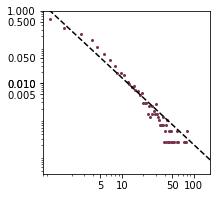

-------------------------9-------------------------
1.9258757734367324


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


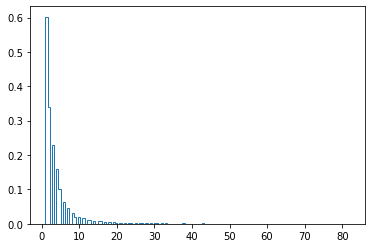

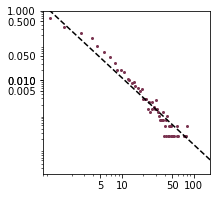

-------------------------10-------------------------
2.015749572630241


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


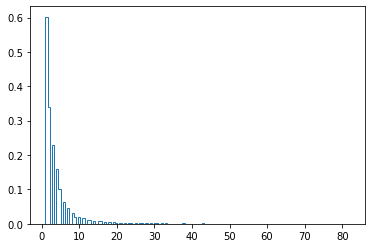

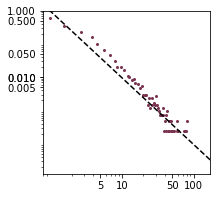

-------------------------11-------------------------
2.1137063775180516


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


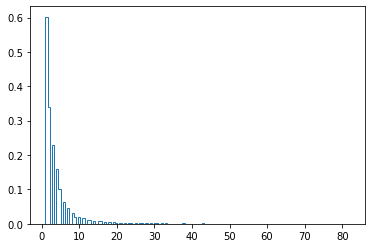

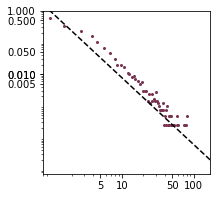

-------------------------12-------------------------
2.221573842332111


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


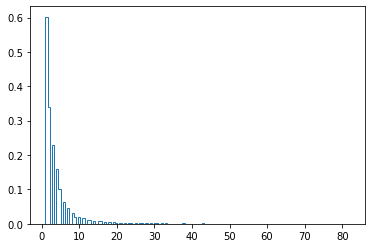

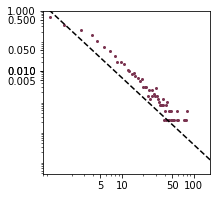

-------------------------13-------------------------
2.3381553538427573


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


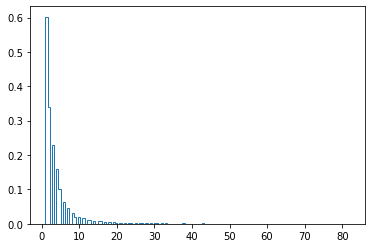

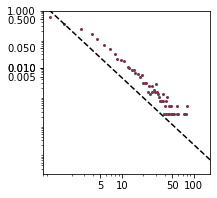

-------------------------14-------------------------
2.468263517564537


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


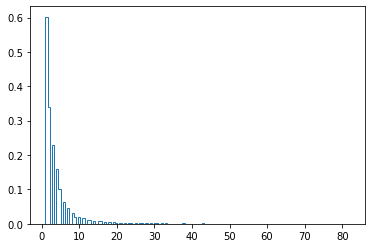

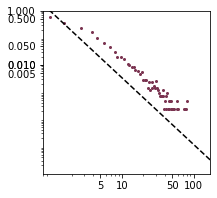

In [350]:
def power_law_discrete_MLE(binned_data, x_min):
    binned_data = [x for x in binned_data if x>x_min]
    n = len(binned_data)
    a = 1+n/(sum(np.log(x/x_min-0.5) for x in binned_data))
    return a

def power_fit(x_min):
    G = G_o.copy()
    all_degrees = [x for x in dict(G.degree()).values() if x>0]
    h = plt.hist(all_degrees, histtype='step', bins=140, density=True)

    data_x = h[1][:-1][h[0]>0]
    data_y = h[0][h[0]>0]

    x = np.linspace(0.1, 187, 10)
    a = power_law_discrete_MLE(data_x, x_min)
    print(a)
    p_x = x**(-a)


    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(data_x, data_y, c='#7a3350', s=4)
    ax.plot(x, p_x, 'k', linestyle='dashed')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks([0.005, 0.01, .05, .01, .5, 1])
    ax.set_xticks([5,10,50,100])
    ax.get_xaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    ax.set_xlim(0.8, 170)
    ax.set_ylim(0, 1)
    plt.savefig('bioplex_figures/degree_dist.svg')
    plt.show()
    
for x_min in range(4,15):
    print('-------------------------{}-------------------------'.format(x_min))
    power_fit(x_min)

### Eigen vector centrality

In [786]:
eig_cen = nx.eigenvector_centrality_numpy(G_o)
alt_eig_cen = [x for x in eig_cen.items() if is_alt(x[0])]
sorted_eig_cen = sorted([(k, v) for k,v in eig_cen.items()], key=lambda x: x[1])

alt_cen = [1 if is_alt(x[0]) else 0 for x in sorted_eig_cen]

cm = LinearSegmentedColormap.from_list('whatevs', ['#fff', '#501930'], N=100)

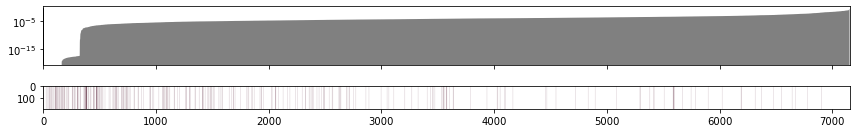

In [365]:
fig, axs = plt.subplots(2, figsize=(12,2), sharex=True)
x = range(len(eig_cen))
y = sorted(eig_cen.values())
axs[0].plot(y, y, c='k')
axs[0].fill_between(x, y, facecolor='grey')
axs[0].set_yscale('log')
axs[0].set_yticks([1e-15, 1e-5])
axs[1].imshow([alt_cen,]*200, cmap=cm)
#plt.xticks([0, 4000, 8000])

plt.tight_layout()
plt.savefig('bioplex_figures/eig_cen.svg', dpi=600)

### clustering coefficient

In [37]:
clust_coef = nx.clustering(G_o)

In [38]:
list(clust_coef.items())[:5]

[('SLAMF1', 0.007352941176470588),
 ('AHCTF1', 0),
 ('ANKRD13A', 0),
 ('ANTXR1', 0.02857142857142857),
 ('ARFGEF1', 0)]

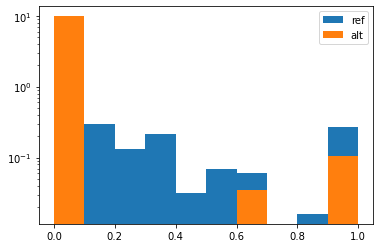

In [49]:
ref_clust = [coef for prot, coef in clust_coef.items() if not is_alt(prot)]
alt_clust = [coef for prot, coef in clust_coef.items() if is_alt(prot)]

plt.hist(ref_clust, density=True, label='ref')
plt.hist(alt_clust, density=True, label='alt')
plt.yscale('log')
plt.legend()
plt.show()

### betweeness centrality

In [387]:
bet_cen = nx.betweenness_centrality(G_o)

In [388]:
list(bet_cen.items())[:5]

[('SLAMF1', 0.0035421565962461357),
 ('AHCTF1', 0.0029061930927895227),
 ('ANKRD13A', 0.0011972132677265962),
 ('ANTXR1', 0.004423916738343034),
 ('ARFGEF1', 0.0008963046018158614)]

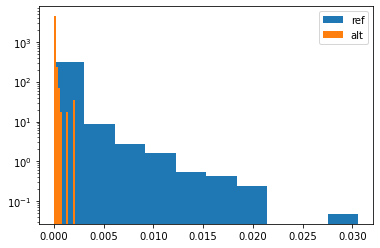

In [390]:
ref_bet_cen = [coef for prot, coef in bet_cen.items() if not is_alt(prot)]
alt_bet_cen = [coef for prot, coef in bet_cen.items() if is_alt(prot)]

plt.hist(ref_bet_cen, density=True, label='ref')
plt.hist(alt_bet_cen, density=True, label='alt')

plt.yscale('log')
plt.legend()
plt.show()

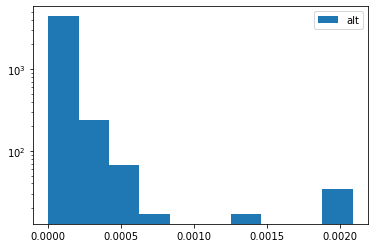

In [51]:
plt.hist(alt_clust, density=True, label='alt')
plt.yscale('log')
plt.legend()
plt.show()

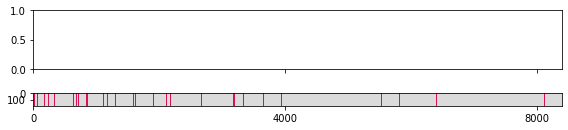

In [272]:
fig, axs = plt.subplots(2, figsize=(8,2), sharex=True)
#axs[0].plot(range(len(eig_cen)), sorted(eig_cen.values()), c='k')
#axs[0].set_yscale('log')
axs[1].imshow([,]*200, cmap=cm)
axs[1].imshow([alt_cen,]*200, cmap=cm)
plt.xticks([0, 4000, 8000])
plt.tight_layout()
plt.savefig('bioplex_figures/eig_cen.svg')

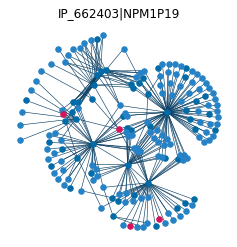

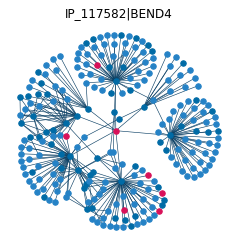

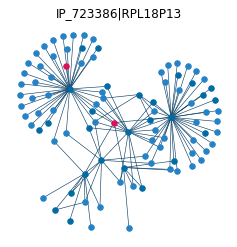

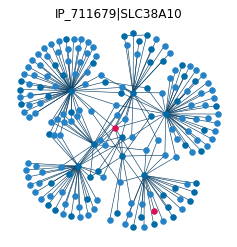

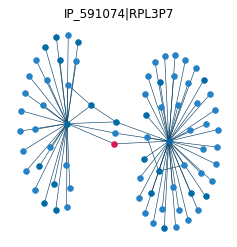

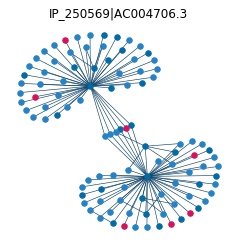

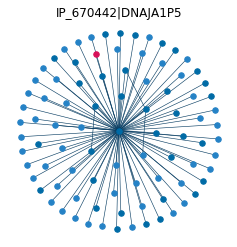

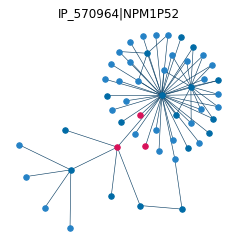

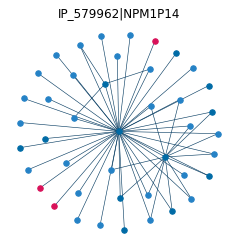

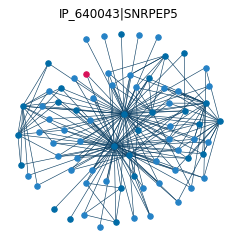

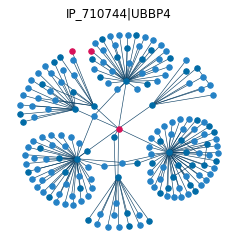

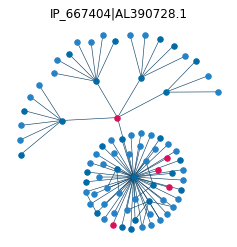

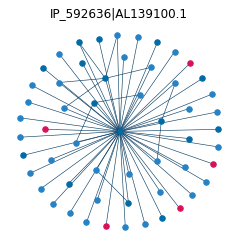

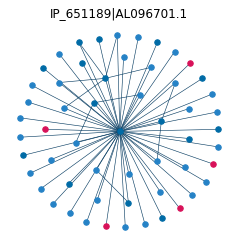

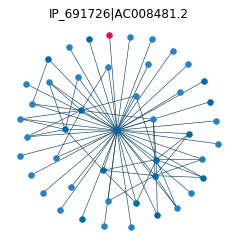

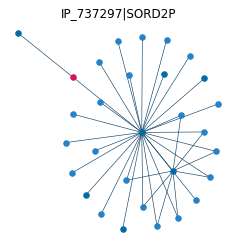

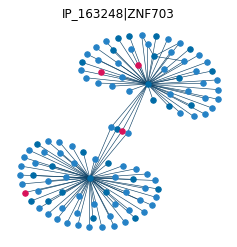

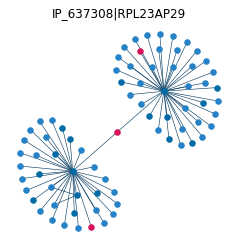

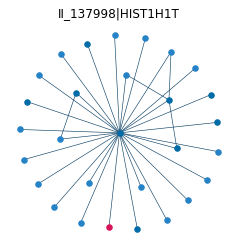

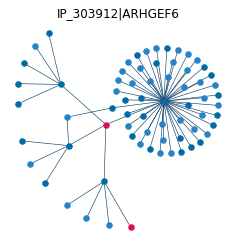

In [615]:
alt_eig_cen = sorted([(k, v) for k,v in eig_cen.items() if is_alt(k)], key=lambda x: -x[1])
for x in alt_eig_cen[:20]:
    get_graph_vis(get_2degneigb(G_o_pepgrp, x[0]), x[0], node_size=30, alt_node_size=30, file_name='bioplex_figures/subnets/{}.svg'.format(x[0]))

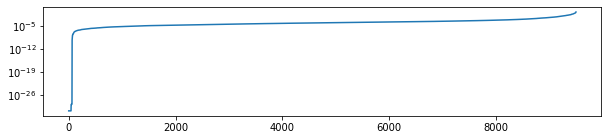

In [2720]:
eig_cen = nx.eigenvector_centrality(G_b)

fig, ax = plt.subplots(figsize=(10,2))
plt.plot(range(len(eig_cen)), sorted(eig_cen.values()))
#plt.xscale('log')
plt.yscale('log')

## Transcript biotypes of identified altProts

In [1838]:
rows = []
with open('human-openprot-r1_6-refprots+altprots+isoforms-+uniprot2019_03_01.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for n,r in enumerate(reader):
        if n==0:continue
        if n==1:
            cols = r
            continue
        row = dict(zip(cols, r))
        rows.append(row)

In [1842]:
trxp_genes = {}
for row in rows:
    if row['protein type'] != 'AltProt': continue
    t_acc = row['transcript accession'].split('.')[0]
    gene_symbol = row['gene symbol']
    trxp_genes[t_acc] = gene_symbol

In [1682]:
alt_trxp_locs = {}
for row in rows:
    if row['protein type'] != 'AltProt': continue
    alt_trxp_locs[(row['protein accession numbers'], row['transcript accession'].split('.')[0])] = {
        'start':int(row['start transcript coordinates']),
        'end':int(row['stop transcript coordinates'])
    }

In [138]:
gtf_file = 'Homo_sapiens.GRCh38.95.gtf'
gtf = read_gtf(gtf_file)
gtf_trxps = gtf[gtf["feature"] == "transcript"]
trxp_biotypes = gtf_trxps[['transcript_id', 'transcript_biotype']].set_index('transcript_id').to_dict()['transcript_biotype']

pickle.dump(trxp_biotypes, open('trxp_biotypes.pkl', 'wb'))

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'ccds_id']


In [139]:
refseq_gtf_file = 'GRCh38_latest_genomic.gtf'
refseq_gtf = read_gtf(refseq_gtf_file)
refseq_pseudo_set = set(refseq_gtf.query("pseudo=='true'")['gene_id'])
refseq_trxp_gene = refseq_gtf[['transcript_id', 'gene_id']].set_index('transcript_id').to_dict()['gene_id']
refseq_trxp_gene = {k.split('.')[0] : v for k,v in refseq_trxp_gene.items()}

pickle.dump((refseq_trxp_gene, refseq_pseudo_set), open('refseq_trxp_gene.pkl', 'wb'))

INFO:root:Extracted GTF attributes: ['gene_id', 'db_xref', 'description', 'gbkey', 'gene', 'gene_biotype', 'pseudo', 'transcript_id', 'product', 'exon_number', 'gene_synonym', 'model_evidence', 'tag', 'protein_id', 'exception', 'inference', 'note', 'isoform', 'The', 'anticodon', 'partial', 'transl_except', 'non-AUG', 'standard_name', 'source', 'similar', 'transferase', 'codons', '12S', '16S', 'transl_table', 'ATPase']
INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [1695]:
# get trxp accs for all alts
all_enst = set()
for tt_acc in list(detected_alts):
    t_accs = prot_trxp_dict[tt_acc]
    for t_acc in t_accs:
        if 'ENST' in t_acc:
            all_enst.add(t_acc)
len(all_enst)

451

In [142]:
# downloaded from Ensembl biomart may 12 2020
refseq_with_corr_ens = set()
with open('mart_export_ensbl_refseq_trxps.txt', 'r') as f:
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys = ls
        line = dict(zip(keys, ls))
        if line['Transcript stable ID'] not in all_enst: continue
        for x in ['RefSeq ncRNA', 'RefSeq mRNA ID']:
            if x in line:
                refseq_with_corr_ens.add(line[x])

with open('mart_export_predicted.txt', 'r') as f:
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys = ls
        line = dict(zip(keys, ls))
        if line['Transcript stable ID'] not in all_enst: continue
        for x in ['RefSeq mRNA predicted ID', 'RefSeq ncRNA predicted ID']:
            if x in line:
                refseq_with_corr_ens.add(line[x])

In [1835]:
len(detected_alts)

295

In [1836]:
manual_gene_biotypes = {
    'LOC105369927':'ncRNA',
    'LOC646938':'pseudogene',
    'LOC102725180':'protein_coding',
    'LOC105370890':'ncRNA',
    'LOC105371808':'ncRNA',
    'LOC105370248':'ncRNA',
    'LOC107984234':'ncRNA',
    'LOC107986256':'ncRNA',
    'LOC105375894':'ncRNA',
    'LOC112268467':'ncRNA',
    'C2orf71':'protein_coding',
    'LOC107986087':'ncRNA',
    'LOC105378807':'ncRNA',
    'LOC105369203':'ncRNA',
    'LOC105371028':'ncRNA',
    'LOC107986982':'protein_coding',
    'LOC286177':'ncRNA',
    'LOC100129046':'ncRNA',
    'LOC105378122':'ncRNA',
    'LOC105373554':'ncRNA',
    'LOC105372172':'ncRNA',
}
gene_biotypes.update(manual_gene_biotypes)

In [1716]:
alt_gene_biotypes = []
for alt in list(detected_alts):
    gene = op_prot_gene[alt]
    gene_biotype, short_biotype  = 'NA', 'NA'
    if gene in gene_biotypes:
        gene_biotype = gene_biotypes[gene]
    if 'pseudogene' in gene_biotype:
        short_biotype = 'pseudogene'
    elif gene_biotype == 'protein_coding':
        short_biotype = 'protein_coding'
    else:
        short_biotype = 'non_coding'
    alt_sig_id, alt_sig_desc, alt_inter_ids = ['NA']*3
    if alt in interpro:
        alt_sig_id = '|'.join(list(set([str(x) for x in interpro[alt]['sig_accs']])))
        alt_sig_desc = '|'.join(list(set([str(x) for x in interpro[alt]['sig_desc']])))
        alt_inter_ids = '|'.join(list(set([str(x) for x in interpro[alt]['ipr_ids']])))
    prot_len = prot_len_dict[alt]
    gene_type = 'protein coding'
    if alt in coding_gene_alt_locs:
        if 'CDS' in coding_gene_alt_locs[alt]:
            gene_type = 'dual coding'
        elif 'UTR' in coding_gene_alt_locs[alt]:
            gene_type = 'bicistronic'
        else:
            gene_type = 'protein coding'
    else:
        gene_type = 'protein coding'
        
    peptides = list(set([x[0] for x in reports_all_alts[alt.replace('IP_243680', 'IP_2287811')]['psms']]))
    
    alt_gene_biotype = (alt, gene, gene_biotype, short_biotype, gene_type, prot_len, len(peptides), '|'.join(peptides), alt_sig_desc, alt_inter_ids, alt_sig_id)
    if any(x=='NA' for x in [gene_biotype, short_biotype]):
        print("'{}':'ncRNA'".format(alt_gene_biotype[1]))
    alt_gene_biotypes.append(alt_gene_biotype)

In [1717]:
len([x for x in alt_gene_biotypes if x[3]=='pseudogene'])

136

In [1719]:
# count genes
len(set(x[1] for x in alt_gene_biotypes))

284

In [1720]:
Counter([x[3] for x in alt_gene_biotypes])

Counter({'protein_coding': 121, 'pseudogene': 136, 'non_coding': 38})

In [1721]:
Counter([x[2] for x in alt_gene_biotypes])

Counter({'protein_coding': 121,
         'processed_pseudogene': 102,
         'transcribed_processed_pseudogene': 11,
         'ncRNA': 17,
         'unprocessed_pseudogene': 6,
         'pseudogene': 1,
         'processed_transcript': 3,
         'lincRNA': 9,
         'sense_intronic': 1,
         'transcribed_unprocessed_pseudogene': 14,
         'antisense': 7,
         'TEC': 1,
         'transcribed_unitary_pseudogene': 2})

In [1723]:
coding_gene_alt_locs = {alt_acc:max(Counter([x[2] for x in acc_trxp_loc]).items(), key=lambda x: x[1])[0] for alt_acc, acc_trxp_loc in itt.groupby(sorted(result), key=lambda x: x[0])}

Counter(coding_gene_alt_locs.values())

Counter({'CDS': 52, "3'UTR": 40, "5'UTR": 17, '-': 186})

In [1843]:
selected_trxps = {}
for alt_acc in list(detected_alts):
    trxps = []
    for t_acc in prot_trxp_dict[alt_acc]:
        if t_acc in trxp_biotypes and trxp_biotypes[t_acc]=='protein_coding':
            t_biotype = 1
        elif any(x in t_acc for x in ['NM_', 'XM_']):
            t_biotype = 1
        else:
            t_biotype = 0
        trxps.append(
            {
                't_acc':t_acc,
                't_gene':trxp_genes[t_acc],
                't_biotype':t_biotype,
                't_len':trxp_len_dict[t_acc],
            }
        )
    trxps = sorted(trxps, key=lambda x: [-x['t_biotype'], -x['t_len']])
    selected_trxps[alt_acc] = trxps[0]['t_acc']
    

In [1844]:
multialt_genes = [x for x in [(gene, set(x['altProt accession'] for x in alt_grp)) for gene, alt_grp in itt.groupby(sorted([x for x in ev1 if x['gene biotype']!='protein_coding'], key=lambda x: x['gene']), key=lambda x: x['gene'])] if len(x[1])>1]

trxp_mult_alts = []
for gene, alt_grp in itt.groupby(sorted([x for x in ev1 if x['gene biotype']!='protein_coding'], key=lambda x: x['gene']), key=lambda x: x['gene']):
    gene_alts = list(alt_grp)
    alt_acc_set = set(x['altProt accession'] for x in gene_alts)
    if len(alt_acc_set)>1:
        for gene_alt in gene_alts:
            alt_trxp = (gene_alt['altProt accession'], gene_alt['transcript accession'])
            trxp_mult_alts.append((gene_alt['transcript accession'], gene_alt['altProt accession'], alt_trxp_locs[alt_trxp]['start'], alt_trxp_locs[alt_trxp]['end']))

def ranges_overlap(range1, range2):
    s1, e1 = range1
    s2, e2 = range2
    total_len = max((e1, e2)) - min((s1, s2))
    total_seq = np.zeros(total_len)
    total_seq[s1:e1] += 1
    total_seq[s2:e2] += 1
    if max(total_seq)>1:
        return True
    return False

trxp_mult_alts_biotypes = {}
for trxp_acc, trxp_alt_grp in itt.groupby(sorted(trxp_mult_alts), key=lambda x: x[0]):
    trxp_alt = [x[1:] for x in trxp_alt_grp]
    if not len(trxp_alt)>1: continue
    range1 = trxp_alt[0][1:]
    range2 = trxp_alt[1][1:]
    if ranges_overlap(range1, range2):
        trxp_mult_alts_biotypes[trxp_acc] = 'dual coding'
    else:
        trxp_mult_alts_biotypes[trxp_acc] = 'bicistronic'

In [1881]:
alt_trxps = {}
for tt_acc in list(detected_alts):
    for t_acc in prot_trxp_dict[tt_acc]:
        gene = trxp_genes[t_acc]
        g_biotype = gene_biotypes[gene] if gene in gene_biotypes else 'NA'
        if t_acc in trxp_biotypes:
            t_biotype = trxp_biotypes[t_acc]
        elif any(x in t_acc for x in ['NM_', 'XM_']):
            t_biotype = 'protein_coding'
        else:
            t_biotype = 'non_coding'
        loc = trxp_alt_loc[(tt_acc, t_acc)] if (tt_acc, t_acc) in trxp_alt_loc else 'NA'
        #alt_trxps.append((t_acc, t_biotype, tt_acc, loc, gene, g_biotype))
        
        trxp_code_type = 'single CDS'
        if 'CDS' in loc:
            trxp_code_type = 'dual coding'
        elif 'UTR' in loc:
            trxp_code_type = 'bicistronic'
        if t_acc in trxp_mult_alts_biotypes:
            trxp_code_type = trxp_mult_alts_biotypes[t_acc]
        alt_trxps[(t_acc, tt_acc)] = {
            't_biotype':t_biotype, 
            'loc':loc, 
            'gene':gene, 
            'g_biotype':g_biotype,
            'transcript coding type':trxp_code_type,
            'selected_trxp':tt_acc==selected_trxps[tt_acc]
        }

In [865]:
interpro = pickle.load(open('bioplex_interpro.pkl', 'rb'))

In [1866]:
alt_gene_biotypes_cols = (
    'altProt accession', 
    'gene', 
    'gene biotype', 
    'gene biotype summarized', 
    'gene coding type', 
    'length (aa)', 
    'n unique peptides', 
    'peptides', 
    'interpro signature description', 
    'interpro signature accession', 
    'interpro signature ids'
)

In [1867]:
alt_gene_biotypes_dict = {}
for alt_gene_biotype in alt_gene_biotypes:
    alt_gene_biotype_dict = dict(zip(alt_gene_biotypes_cols, alt_gene_biotype))
    alt_gene_biotypes_dict[alt_gene_biotype_dict['altProt accession']] = alt_gene_biotype_dict

In [1897]:
ev1 = []
for t_acc, alt_acc in alt_trxps:
    ev1.append(
        {
            'altProt accession':alt_acc.replace('IP_2287811', 'IP_243680'),
            'length (aa)':prot_len_dict[alt_acc],
            'gene':alt_trxps[(t_acc, alt_acc)]['gene'],
            'gene biotype':alt_trxps[(t_acc, alt_acc)]['g_biotype'],
            'transcript accession':t_acc,
            'transcript biotype':alt_trxps[(t_acc, alt_acc)]['t_biotype'],
            'proposed transcript biotype':'protein_coding',
            'location relative to ref':alt_trxps[(t_acc, alt_acc)]['loc'],
            'multi-coding type':alt_trxps[(t_acc, alt_acc)]['transcript coding type'], 
            'interpro description':alt_gene_biotypes_dict[alt_acc]['interpro signature description'], 
            'interpro accession':alt_gene_biotypes_dict[alt_acc]['interpro signature accession'], 
            'interpro ids':alt_gene_biotypes_dict[alt_acc]['interpro signature ids']
        }
    )

cols = (
    'altProt accession',
    'length (aa)',
    'gene',
    'gene biotype',    
    'transcript accession',
    'transcript biotype',
    'location relative to ref',
    'proposed transcript biotype',
    'multi-coding type',
    'interpro description', 
    'interpro accession', 
    'interpro ids'
)

with open('bioplex_tables/Table_EV1.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(cols)
    for row in ev1:
        writer.writerow([row[col] for col in cols])

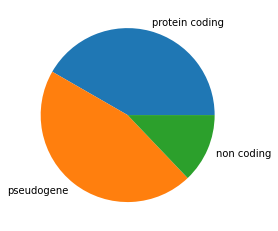

In [1857]:
labels, counts = zip(*alt_biotype_cnts.items())
plt.pie(counts, labels=labels)
plt.savefig('bioplex_figures/biotype_pie.svg')
plt.show()

In [1750]:
location_cnts = dict(Counter([x['location on transcript'] for x in ev1 if x['transcript accession']==selected_trxps[x['altProt accession']] and x['gene biotype']=='protein_coding']))
print(location_cnts, sum(location_cnts.values()))

{'CDS': 51, "3'UTR": 39, '-': 14, "5'UTR": 17} 121


In [1751]:
sum(location_cnts[loc] for loc in ['CDS', "3'UTR", "5'UTR"])

107

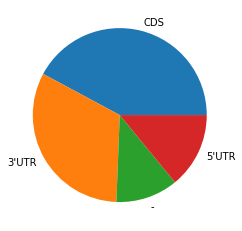

In [1752]:
# of the altProts dentified from protein coding genes, what are their transcriptional location relative to the reference protein?

labels, counts = zip(*location_cnts.items())
plt.pie(counts, labels=labels)
plt.savefig('bioplex_figures/trxp_loc_pie.svg')
plt.show()

## Community detection with MCL clustering

In [53]:
# GOatools setup
def get_GO(gene_list, title):
    ratios, gterms = [], []
    GOEA_result = GOEA.run_study_nts(gene_list)
    print('\n --------------')
    for g in GOEA_result[:10]:
        ratios.append(np.divide(*g.ratio_in_study))
        gterms.append(g.name)
        #print(ratios, g.name, g.kws['p_uncorrected'])
    n_sig_gterms = 10
    fig, ax = plt.subplots(facecolor='w', figsize=(4,2))
    y_pos = range(1, n_sig_gterms+1)
    ax.set_title(title)
    ax.barh(y_pos, ratios[:n_sig_gterms])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(gterms)
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.set_aspect(0.01)
    ax.set_xlabel('frequency')
    plt.savefig('GO_barcharts/{}_GOenrichment.svg'.format(title))
    plt.show()
    return GOEA_result

In [308]:
pip show goatools

Name: goatools
Version: 1.0.2
Summary: Python scripts to find enrichment of GO terms
Home-page: http://github.com/tanghaibao/goatools
Author: Haibao Tang, DV Klopfenstein
Author-email: tanghaibao@gmail.com
License: BSD
Location: /home/sleblanc/anaconda3/lib/python3.7/site-packages
Requires: pandas, xlrd, requests, scipy, nose, pydot, statsmodels, pytest-cov, wget, xlsxwriter, numpy, docopt, pytest
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [54]:
# GOATools
import goatools
from goatools import obo_parser
from goatools.go_enrichment import GOEnrichmentStudy
import wget
import os
import gzip

go_obo_url = 'http://purl.obolibrary.org/obo/go/go.obo'
data_folder = os.getcwd() + '/GO_data'

# Check if we have the ./GO_data directory already
if(not os.path.isfile(data_folder)):
    # Emulate mkdir -p (no error if folder exists)
    try:
        os.mkdir(data_folder)
    except OSError as e:
        if(e.errno != 17):
            raise e
else:
    raise Exception('Data path (' + data_folder + ') exists as a file. '
                   'Please rename, remove or change the desired location of the data path.')

# Check if the file exists already
if(not os.path.isfile(data_folder+'/go.obo')):
    go_obo = wget.download(go_obo_url, data_folder+'/go.obo')
else:
    go_obo = data_folder+'/go.obo'

if(not os.path.isfile(data_folder+'/goslim_agr.obo')):
    goslim_agr = wget.download(go_obo_url, data_folder+'/goslim_agr.obo')
else:
    goslim_agr = data_folder+'/goslim_agr.obo'

## Now Gene_Enrichment
import Bio.UniProt.GOA as GOA
### Get the GAF file for your species
import os
from ftplib import FTP
data_folder = '/home/sleblanc/'
human_uri = '/pub/databases/GO/goa/HUMAN/goa_human.gaf.gz'
human_fn = human_uri.split('/')[-1]

# Check if the file exists already
human_gaf = os.path.join(data_folder, human_fn)
if(not os.path.isfile(human_gaf)):
    ebi_ftp = FTP('ftp.ebi.ac.uk')
    ebi_ftp.login()
    with open(human_gaf,'wb') as human_fp:
        ebi_ftp.retrbinary('RETR {}'.format(human_uri), human_fp.write)
    ebi_ftp.quit()

GO_terms = obo_parser.GODag(go_obo)
GO_slim  = obo_parser.GODag(goslim_agr)

with gzip.open(human_gaf, 'rt') as human_gaf_fp:
    human_funcs = {}
    for entry in GOA.gafiterator(human_gaf_fp):
        gene_name = entry.pop('DB_Object_Symbol')
        human_funcs[gene_name] = entry
    pop = human_funcs.keys()

assoc = {}
for x in human_funcs:
    if x not in assoc:
        assoc[x] = set()
    assoc[x].add(str(human_funcs[x]['GO_ID']))

    

/home/sleblanc/GO_data/go.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
/home/sleblanc/GO_data/goslim_agr.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms


In [55]:
GOEA = GOEnrichmentStudy(pop, assoc, GO_terms, propagate_counts=True, alpha=0.05, methods=['fdr'])


Load GOEA Gene Ontology Analysis ...
Propagating term counts up: is_a


4 GO IDs NOT FOUND IN ASSOCIATION: GO:0048037 GO:0051184 GO:0051186 GO:0050662


100% 19,435 of 19,435 population items found in association


In [349]:
pip show markov_clustering

Name: markov-clustering
Version: 0.0.6.dev0
Summary: Implementation of the Markov clustering (MCL) algorithm in python.
Home-page: https://github.com/guyallard/markov_clustering.git
Author: Guy Allard
Author-email: guyallard01@gmail.com
License: MIT
Location: /home/sleblanc/anaconda3/lib/python3.7/site-packages
Requires: scipy, numpy, scikit-learn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [56]:
G = G_o
matrix_o = nx.to_scipy_sparse_matrix(G)
result_o = mc.run_mcl(matrix_o, inflation=2.0, verbose=True)
clusters = mc.get_clusters(result_o)
node_idx = {n:x for n,x in enumerate(G.nodes())}
cluster_sizes = sorted([(c, len(c)) for c in clusters if len(c)>2], key=lambda x: -x[-1])
len(cluster_sizes)

--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 2.0
Pruning threshold: 0.001, frequency: 1 iteration
Convergence check: 1 iteration
Maximum iterations: 100
Sparse matrix mode
--------------------------------------------------
Iteration 1
Pruning
Checking for convergence
Iteration 2
Pruning
Checking for convergence
Iteration 3
Pruning
Checking for convergence
Iteration 4
Pruning
Checking for convergence
Iteration 5
Pruning
Checking for convergence
Iteration 6
Pruning
Checking for convergence
Iteration 7
Pruning
Checking for convergence
Iteration 8
Pruning
Checking for convergence
Iteration 9
Pruning
Checking for convergence
Iteration 10
Pruning
Checking for convergence
Iteration 11
Pruning
Checking for convergence
Iteration 12
Pruning
Checking for convergence
Iteration 13
Pruning
Checking for convergence
Iteration 14
Pruning
Checking for convergence
Iteration 15
Pruning
Checking for convergence
Iteration 16
Pruning
Checking for convergence
Itera

1045

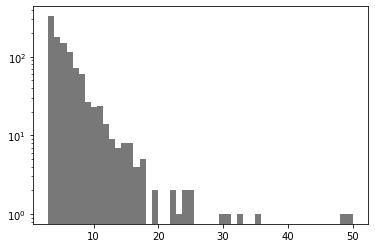

In [607]:
hist = plt.hist([x[1] for x in cluster_sizes], color='#787878', bins=max([x[1] for x in cluster_sizes]))
plt.yscale('log')
plt.savefig('bioplex_figures/cluster_sizes.svg')
plt.show()

In [58]:
def get_out_edges(subG, G):
    clust_out_edges = []
    for node in subG.nodes():
        out_first_neighbor_nodes = nx.neighbors(G, node) - subG.nodes()
        clust_out_edges.extend([frozenset((node, n)) for n in out_first_neighbor_nodes])
    return set(clust_out_edges)

In [59]:
clusters_dict = {}
node_tt_type = nx.get_node_attributes(G_o, 'tt_type')
for n, clust in enumerate(cluster_sizes):
    cluster_G = nx.subgraph(G_o, [node_idx[x] for x in clust[0]])
    cluster_G_nodes = set(cluster_G.nodes())
    clusters_dict[n] = {'graph':cluster_G, 'contains_alt': False}
    if any(node_tt_type[n]=='alt' for n in cluster_G.nodes()):
        clusters_dict[n]['contains_alt'] = True
        clusters_dict[n]['alts'] = [n for n in cluster_G.nodes() if node_tt_type[n]=='alt']
    #compute the number of connections each cluster has with nodes not in the cluster
    clusters_dict[n]['outward_edges'] = get_out_edges(cluster_G, G_o)
    clusters_dict[n]['node_type'] = 'clust'

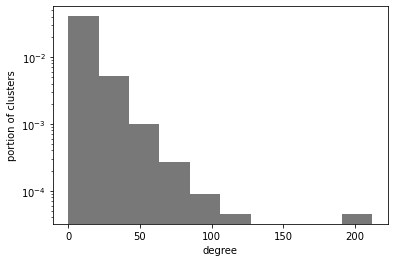

In [689]:
clust_degrees = [len(clust['outward_edges']) for clust in clusters_dict.values()]
plt.hist(clust_degrees, density=True, color='#787878')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('portion of clusters')
plt.savefig('bioplex_figures/clust_degrees.svg')
plt.show()

In [681]:
cnt_alt_clust = sum(clust['contains_alt'] for clust in clusters_dict.values())

In [683]:
cnt_alt_clust/len(clusters_dict)

0.15598086124401914

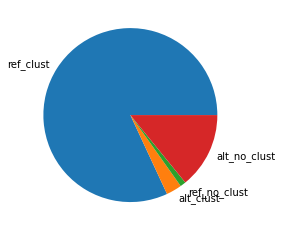

In [688]:
clust_nodes = set(x for y in [clust['graph'].nodes() for clust in clusters_dict.values()] for x in y)
ref_clust_nodes = sum(not is_alt(n) for n in clust_nodes)
alt_clust_nodes = sum(is_alt(n) for n in clust_nodes)
all_nodes = set(G_o.nodes())
ref_all_nodes = sum(not is_alt(n) and n not in clust_nodes for n in all_nodes)
alt_all_nodes = sum(is_alt(n) and n not in clust_nodes for n in all_nodes)
labels = 'ref_clust', 'alt_clust', 'alt_no_clust', 'ref_no_clust'
plt.pie([ref_clust_nodes, alt_clust_nodes, alt_all_nodes, ref_all_nodes], labels=labels)
plt.savefig('bioplex_figures/clust_nodes_pie.svg')
plt.show()

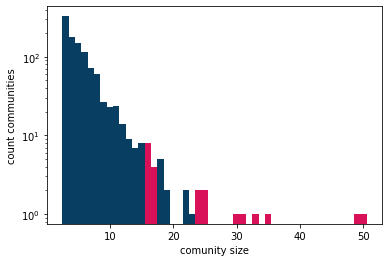

In [60]:
clust_sizes_altprop = [(len(clust['graph']), clust['contains_alt']) for clust_n, clust in clusters_dict.items()]
import matplotlib.colors as mcolors
clust_sizes_alt_proportions = {}
colors = []
for clust_size, grp in itt.groupby(clust_sizes_altprop, key=lambda x: x[0]):
    clust_alt_stat = [x[1] for x in grp]
    clust_sizes_alt_proportions[clust_size] = (len(clust_alt_stat), sum(clust_alt_stat) / len(clust_alt_stat))

x, cnt_colo = zip(*list(clust_sizes_alt_proportions.items()))

cnt, colo = zip(*cnt_colo)

colors = ['#093e63' if x[1]>0 else '#d81159' for x in cnt_colo]

plt.bar(x, cnt, width=1.0, color=colors, log=True)
plt.xlabel('comunity size')
plt.ylabel('count communities')
plt.savefig('bioplex_figures/MCL_clust_sizes.svg')
plt.show()

In [1920]:
outward_edges_set = set([x for y in [list(x['outward_edges']) for x in clusters_dict.values()] for x in y])
clust_pairs = {}
clust_pairs_set = set()
for clust_n1, clust_dict1 in clusters_dict.items():
    for clust_n2, clust_dict2 in clusters_dict.items():   
        clust_pair = frozenset((clust_n1, clust_n2))
        if clust_n1 == clust_n2 or clust_pair in clust_pairs_set:continue # pass if its the same cluster or if the pair has already been processed
        clust_pairs_set.add(clust_pair)
        
        clust1_out_edges = clust_dict1['outward_edges']
        clust2_out_edges = clust_dict2['outward_edges']
        
        outward_edges_intersect = clust1_out_edges.intersection(clust2_out_edges)
        cnt_int = len(outward_edges_intersect)
        if cnt_int >0:
            clust_pairs[clust_pair] = {'cnt_int':cnt_int}
            clust1_out_edges_only   = clust1_out_edges.difference(clust2_out_edges)
            clust2_out_edges_only   = clust2_out_edges.difference(clust1_out_edges)
            cont_table = [
                [cnt_int,                    len(clust2_out_edges_only)],
                [len(clust1_out_edges_only), len(outward_edges_set.difference(clust1_out_edges.union(clust2_out_edges)))]
            ]
            odds_ratio, pval = stats.fisher_exact(cont_table, alternative='greater')
            clust_pairs[clust_pair]['odds_ratio'] = odds_ratio
            clust_pairs[clust_pair]['pval'] = pval

In [1921]:
clust_pairs_arr = sorted(clust_pairs.items(), key = lambda x: x[1]['pval'])
clust_pairs_pvals = [x[1]['pval'] for x in clust_pairs_arr]
clust_pairs_pvals = sorted(clust_pairs_pvals)
fdr_bh = multipletests(clust_pairs_pvals, method='fdr_bh', alpha=0.01, is_sorted=True)
corrected_pvals = fdr_bh[1]
fdr_bh = fdr_bh[0]
clust_net = list(itt.compress(clust_pairs_arr, fdr_bh))

clusters_with_alts = [clust for clust_n, clust in clusters_dict.items() if clust['contains_alt']]
print('clusters with alts:', len(clusters_with_alts))
G_clust = nx.Graph()
G_clust.add_edges_from([tuple(e[0]) for e in clust_net])
free_floating = [n for n in clusters_dict.keys() if n not in G_clust]
G_clust.add_nodes_from(free_floating)
print('nodes: {}\nedges: {}'.format(len(G_clust.nodes), len(G_clust.edges)))

clusters with alts: 163
nodes: 1045
edges: 266


In [380]:
def get_sig_go(GO_result, pval_key='p_fdr', fdr=0.05):
    GO = sorted([(x.NS, x.GO, x.name, '|'.join(list(x.study_items)), x.p_fdr) for x in GO_result if x.p_fdr<fdr])
    go_hierar = {}
    for NS, GOs in itt.groupby(GO, key=lambda x: x[0]):
        go_hierar[NS] = []
        for _, go_id, go_name, study_items, pval in GOs:
            if not study_items: continue
            go_hierar[NS].append({
                'go_id':go_id, 
                'go_name':go_name,
                pval_key:pval,
                'study_items':study_items,
            })
    
    return go_hierar

In [ ]:
full_GO_results = {}
for clust_n, clust_dict in clusters_dict.items():
    gene_list = set(n for n in clust_dict['graph'].nodes() if 'IP_' not in n and 'II_' not in n)
    GO_result = GOEA.run_study_nts(gene_list)
    full_GO_results[clust_n] = GO_result
    
    clust_dict['GO_result'] = get_sig_go(GO_result)
    clust_dict['GO_result_slim'] = get_sig_go(GO_result)

In [1222]:
for clust_n, clust_dict in clusters_dict.items():
    if 'GO_result' in clust_dict:
        clust_dict['n_sig_GO'] = sum(len(x) for x in clust_dict['GO_result'].values())

sum([x['n_sig_GO']>0 for x in clusters_dict.values()])/len(clusters_dict)

0.44401913875598087

In [1934]:
clusters_table = []
for clust_n, clust_dict in clusters_dict.items():
    for node in clust_dict['graph'].nodes():
        node.replace('IP_2287811', 'IP_243680')
        if is_alt(node) and node.split('|')[0] not in detected_alts:continue
        if node in gene_synonyms:
            node = gene_synonyms[node]
        clusters_table.append((clust_n, node))

In [1939]:
len([x for x in clusters_table if is_alt(x[1])])

203

In [383]:
def get_max_char_count(goterms):
    goterm_lens = []
    for go_type, go_terms in goterms.items():
        goterm_lens.append(max(len(go_term['go_name']) for go_term in go_terms))
    return max(goterm_lens)

def get_gene_go_count(GO):
    all_genes = [[go_term['study_items'].split('|') for go_term in go_terms] for go_type, go_terms in GO.items()]
    all_genes = [x for y in all_genes for x in y]
    all_genes = [x for y in all_genes for x in y]
    return Counter(all_genes)

### cluster #116

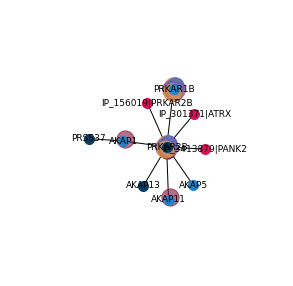

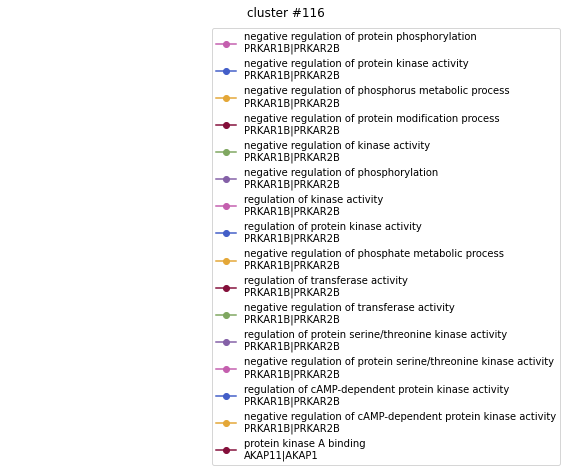

GO:0001933 0.012
GO:0006469 0.004
GO:0010563 0.024
GO:0031400 0.032
GO:0033673 0.004
GO:0042326 0.014
GO:0043549 0.026
GO:0045859 0.024
GO:0045936 0.024
GO:0051338 0.042
GO:0051348 0.006
GO:0071900 0.012
GO:0071901 0.004
GO:2000479 0.004
GO:2000480 0.002
GO:0051018 0.004
BP negative regulation of protein phosphorylation PRKAR1B|PRKAR2B
BP negative regulation of protein kinase activity PRKAR1B|PRKAR2B
BP negative regulation of phosphorus metabolic process PRKAR1B|PRKAR2B
BP negative regulation of protein modification process PRKAR1B|PRKAR2B
BP negative regulation of kinase activity PRKAR1B|PRKAR2B
BP negative regulation of phosphorylation PRKAR1B|PRKAR2B
BP regulation of kinase activity PRKAR1B|PRKAR2B
BP regulation of protein kinase activity PRKAR1B|PRKAR2B
BP negative regulation of phosphate metabolic process PRKAR1B|PRKAR2B
BP regulation of transferase activity PRKAR1B|PRKAR2B
BP negative regulation of transferase activity PRKAR1B|PRKAR2B
BP regulation of protein serine/threonine kin

In [518]:
clust_n = 116
get_graph_vis(
                clusters_dict[clust_n]['graph'], 
                'cluster #{}'.format(clust_n),figsize=(5,5), 
                node_size=node_size, 
                alt_node_size=node_size, 
                layout_params={'k':0.15, 'iterations':20},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.7,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

### cluster #46

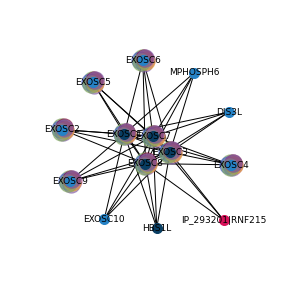

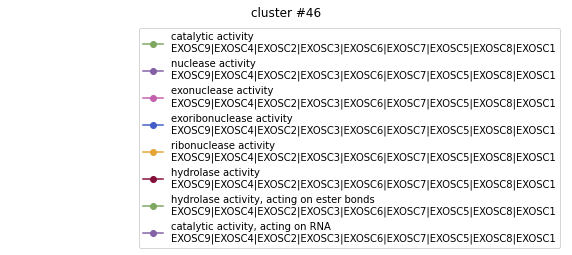

GO:0003824 0.0
GO:0004518 0.0
GO:0004527 0.0
GO:0004532 0.0
GO:0004540 0.0
GO:0016787 0.0
GO:0016788 0.0
GO:0140098 0.0
MF catalytic activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF nuclease activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF exonuclease activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF exoribonuclease activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF ribonuclease activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF hydrolase activity EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF hydrolase activity, acting on ester bonds EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1
MF catalytic activity, acting on RNA EXOSC9|EXOSC4|EXOSC2|EXOSC3|EXOSC6|EXOSC7|EXOSC5|EXOSC8|EXOSC1


In [519]:
clust_n = 46
get_graph_vis(
                clusters_dict[clust_n]['graph'],
                'cluster #{}'.format(clust_n), figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.05, 'iterations':100},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.3,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

### cluster #273

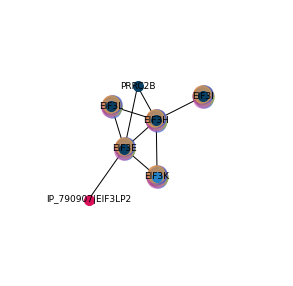

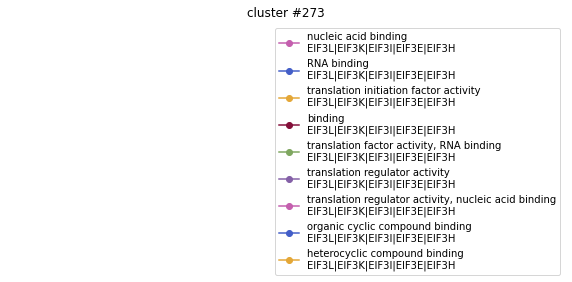

GO:0003676 0.0
GO:0003723 0.0
GO:0003743 0.0
GO:0005488 0.036
GO:0008135 0.0
GO:0045182 0.0
GO:0090079 0.0
GO:0097159 0.0
GO:1901363 0.0
MF nucleic acid binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF RNA binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF translation initiation factor activity EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF translation factor activity, RNA binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF translation regulator activity EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF translation regulator activity, nucleic acid binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF organic cyclic compound binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H
MF heterocyclic compound binding EIF3L|EIF3K|EIF3I|EIF3E|EIF3H


In [520]:
clust_n = 273
get_graph_vis(
                clusters_dict[clust_n]['graph'], 
                'cluster #{}'.format(clust_n),figsize=(5,5), 
                node_size=node_size, 
                alt_node_size=node_size, 
                layout_params={'k':0.15, 'iterations':20},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.7,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

### cluster #470

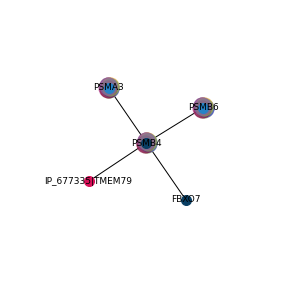

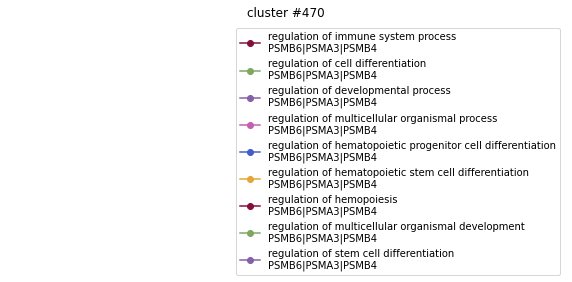

GO:0002682 0.002
GO:0045595 0.002
GO:0050793 0.008
GO:0051239 0.01
GO:1901532 0.0
GO:1902036 0.0
GO:1903706 0.0
GO:2000026 0.002
GO:2000736 0.0
BP regulation of immune system process PSMB6|PSMA3|PSMB4
BP regulation of cell differentiation PSMB6|PSMA3|PSMB4
BP regulation of developmental process PSMB6|PSMA3|PSMB4
BP regulation of multicellular organismal process PSMB6|PSMA3|PSMB4
BP regulation of hematopoietic progenitor cell differentiation PSMB6|PSMA3|PSMB4
BP regulation of hematopoietic stem cell differentiation PSMB6|PSMA3|PSMB4
BP regulation of hemopoiesis PSMB6|PSMA3|PSMB4
BP regulation of multicellular organismal development PSMB6|PSMA3|PSMB4
BP regulation of stem cell differentiation PSMB6|PSMA3|PSMB4


In [521]:
clust_n = 470
get_graph_vis(
                clusters_dict[clust_n]['graph'], 
                'cluster #{}'.format(clust_n),figsize=(5,5), 
                node_size=node_size, 
                alt_node_size=node_size, 
                layout_params={'k':0.15, 'iterations':20},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.7,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

### cluster #378

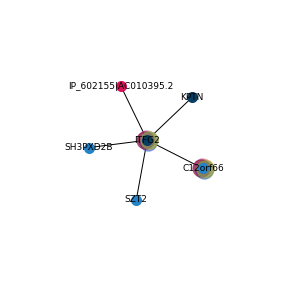

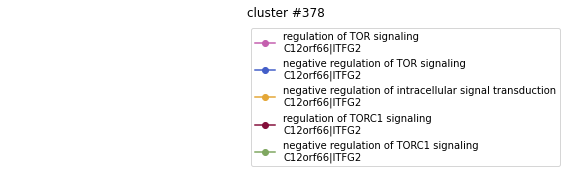

GO:0032006 0.006
GO:0032007 0.002
GO:1902532 0.014
GO:1903432 0.002
GO:1904262 0.002
BP regulation of TOR signaling C12orf66|ITFG2
BP negative regulation of TOR signaling C12orf66|ITFG2
BP negative regulation of intracellular signal transduction C12orf66|ITFG2
BP regulation of TORC1 signaling C12orf66|ITFG2
BP negative regulation of TORC1 signaling C12orf66|ITFG2


In [522]:
clust_n = 378
get_graph_vis(
                clusters_dict[clust_n]['graph'], 
                'cluster #{}'.format(clust_n),figsize=(5,5), 
                node_size=node_size, 
                alt_node_size=node_size, 
                layout_params={'k':0.15, 'iterations':20},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.7,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

### cluster #15

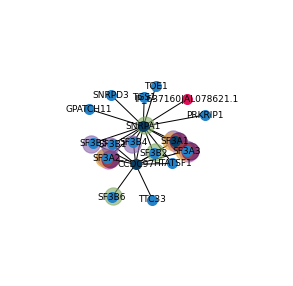

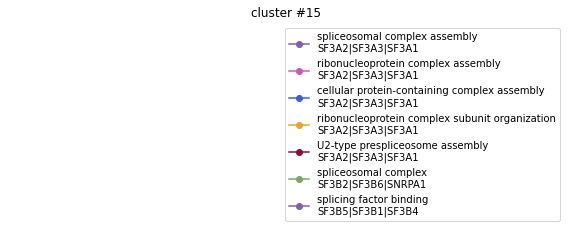

GO:0000245 0.0
GO:0022618 0.0
GO:0034622 0.042
GO:0071826 0.0
GO:1903241 0.0
GO:0005681 0.014
GO:1990935 0.0
BP spliceosomal complex assembly SF3A2|SF3A3|SF3A1
BP ribonucleoprotein complex assembly SF3A2|SF3A3|SF3A1
BP cellular protein-containing complex assembly SF3A2|SF3A3|SF3A1
BP ribonucleoprotein complex subunit organization SF3A2|SF3A3|SF3A1
BP U2-type prespliceosome assembly SF3A2|SF3A3|SF3A1
CC spliceosomal complex SF3B2|SF3B6|SNRPA1
MF splicing factor binding SF3B5|SF3B1|SF3B4


In [523]:
clust_n = 15
get_graph_vis(
                clusters_dict[clust_n]['graph'], 
                'cluster #{}'.format(clust_n),figsize=(5,5), 
                node_size=node_size, 
                alt_node_size=node_size, 
                layout_params={'k':0.02, 'iterations':100},
                file_name='cluster_{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=0.7,
                GO=clusters_dict[clust_n]['GO_result'],
                include_ledgend=True,
            )

print('\n'.join([x for y in [[g['go_id']+' '+str(g['p_fdr']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))
print('\n'.join([x for y in [[NS+' '+g['go_name']+' '+str(g['study_items']) for g in gos] for NS, gos in clusters_dict[clust_n]['GO_result'].items()] for x in y]))

In [378]:
def get_sig_go(GO_result):
    GO = sorted([(x.NS, x.GO, x.name, '|'.join(list(x.study_items)), x.p_fdr) for x in GO_result if x.p_fdr<0.05])
    go_hierar = {}
    for NS, GOs in itt.groupby(GO, key=lambda x: x[0]):
        go_hierar[NS] = []
        for _, go_id, go_name, study_items, p_fdr in GOs:
            go_hierar[NS].append({
                'go_id':go_id, 
                'go_name':go_name,
                'p_fdr':p_fdr,
                'study_items':study_items,
            })
    
    return go_hierar

## Genomics and proteomics patterns of interaction

### Pseudogene altProts and proteins from parental genes

In [1195]:
!wget http://www.pseudogene.org/psicube/data/gencode.v10.pgene.parents.txt

--2020-06-02 13:46:07--  http://www.pseudogene.org/psicube/data/gencode.v10.pgene.parents.txt
Resolving www.pseudogene.org (www.pseudogene.org)... 128.36.220.36
Connecting to www.pseudogene.org (www.pseudogene.org)|128.36.220.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1279905 (1.2M) [text/plain]
Saving to: ‘gencode.v10.pgene.parents.txt’

gencode.v10.pgene.p 100%[===================>]   1.22M  2.40MB/s    in 0.5s    

2020-06-02 13:46:07 (2.40 MB/s) - ‘gencode.v10.pgene.parents.txt’ saved [1279905/1279905]



In [65]:
BG = pickle.load(open('biogrid_networkx.pkl', 'rb'))

In [66]:
psicube_dict = {}
with open('gencode.v10.pgene.parents.txt', 'r') as f:
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys = ls
            continue
        line = dict(zip(keys, ls))
        if 'Parent name' in line:
            psicube_dict[line['Name']] = line['Parent name']
        elif 'Parent gene' in line:
            psicube_dict[line['Name']] = line['Parent gene']

In [68]:
pseudo_parent_dict = {x['Pseudogene_name']:
                      {
                          'parent':x['Chosen_parent_gene'], 
                          'prot_acc':x['Parental_RefProt_accession'], 
                          'alt_acc':x['AltProt_accession']
                      }
                      for x in psicube}

In [69]:
pseudo_parent_refProt_acc = dict([('AK2', 'ENSP00000346921.6'), 
('ANXA2', 'ENSP00000346032.3'), 
('ASS1', 'ENSP00000253004.6'), 
('CCT6A', 'ENSP00000275603.4'), 
('CCT8', 'ENSP00000286788.4'), 
('DNAJA1', 'ENSP00000369127.3'),
('GAPDH', 'ENSP00000229239.5'),
('GLUL', 'ENSP00000307900.5'),
('HMGB3', 'ENSP00000359393.3'),
('HNRNPA1', 'ENSP00000341826.6'),
('HSP90AA1', 'ENSP00000335153.7'),
('HSPD1', 'ENSP00000340019.2'),
('RPS2', 'ENSP00000341885.4'),
('ST13', 'ENSP00000216218.3')])

In [922]:
ensmbl_gene_prot = {}
with open('mart_export.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for n,row in enumerate(reader):
        if n==0:
            keys = row
            continue
        line = dict(zip(keys, row))
        ensmbl_gene_prot[line['Gene name']] = line['Protein stable ID']

In [ ]:

pseudo_parent_prot_pairs = {}
for alt_acc in alt_pseudos:

    pseudogene = op_prot_gene[alt_acc]
    pseudo_parent_prot_pairs[(alt_acc, pseudogene)] = {}
    if pseudogene in pseudo_parent_dict:
        pseudo_parent_prot_pairs[(alt_acc, pseudogene)].update(pseudo_parent_dict[pseudogene])
    elif pseudogene in psicube_dict:
        parent = psicube_dict[pseudogene]
        if parent not in pseudo_parent_refProt_acc:
            print("pseudo_parent_dict['{}'] = 'parent':'{}', 'prot_acc':'', 'alt_acc':'{}'".format(pseudogene, parent, alt_acc))
            continue
        pseudo_parent_prot_pairs[(alt_acc, pseudogene)] = {'parent': psicube_dict[pseudogene], 'prot_acc':pseudo_parent_refProt_acc[parent], 'alt_acc':alt_acc}

    else:
        print("'{}':'',".format(pseudogene))

In [1081]:
blosum62 = {
    ('W', 'F'): 1, ('L', 'R'): -2, ('S', 'P'): -1, ('V', 'T'): 0,
    ('Q', 'Q'): 5, ('N', 'A'): -2, ('Z', 'Y'): -2, ('W', 'R'): -3,
    ('Q', 'A'): -1, ('S', 'D'): 0, ('H', 'H'): 8, ('S', 'H'): -1,
    ('H', 'D'): -1, ('L', 'N'): -3, ('W', 'A'): -3, ('Y', 'M'): -1,
    ('G', 'R'): -2, ('Y', 'I'): -1, ('Y', 'E'): -2, ('B', 'Y'): -3,
    ('Y', 'A'): -2, ('V', 'D'): -3, ('B', 'S'): 0, ('Y', 'Y'): 7,
    ('G', 'N'): 0, ('E', 'C'): -4, ('Y', 'Q'): -1, ('Z', 'Z'): 4,
    ('V', 'A'): 0, ('C', 'C'): 9, ('M', 'R'): -1, ('V', 'E'): -2,
    ('T', 'N'): 0, ('P', 'P'): 7, ('V', 'I'): 3, ('V', 'S'): -2,
    ('Z', 'P'): -1, ('V', 'M'): 1, ('T', 'F'): -2, ('V', 'Q'): -2,
    ('K', 'K'): 5, ('P', 'D'): -1, ('I', 'H'): -3, ('I', 'D'): -3,
    ('T', 'R'): -1, ('P', 'L'): -3, ('K', 'G'): -2, ('M', 'N'): -2,
    ('P', 'H'): -2, ('F', 'Q'): -3, ('Z', 'G'): -2, ('X', 'L'): -1,
    ('T', 'M'): -1, ('Z', 'C'): -3, ('X', 'H'): -1, ('D', 'R'): -2,
    ('B', 'W'): -4, ('X', 'D'): -1, ('Z', 'K'): 1, ('F', 'A'): -2,
    ('Z', 'W'): -3, ('F', 'E'): -3, ('D', 'N'): 1, ('B', 'K'): 0,
    ('X', 'X'): -1, ('F', 'I'): 0, ('B', 'G'): -1, ('X', 'T'): 0,
    ('F', 'M'): 0, ('B', 'C'): -3, ('Z', 'I'): -3, ('Z', 'V'): -2,
    ('S', 'S'): 4, ('L', 'Q'): -2, ('W', 'E'): -3, ('Q', 'R'): 1,
    ('N', 'N'): 6, ('W', 'M'): -1, ('Q', 'C'): -3, ('W', 'I'): -3,
    ('S', 'C'): -1, ('L', 'A'): -1, ('S', 'G'): 0, ('L', 'E'): -3,
    ('W', 'Q'): -2, ('H', 'G'): -2, ('S', 'K'): 0, ('Q', 'N'): 0,
    ('N', 'R'): 0, ('H', 'C'): -3, ('Y', 'N'): -2, ('G', 'Q'): -2,
    ('Y', 'F'): 3, ('C', 'A'): 0, ('V', 'L'): 1, ('G', 'E'): -2,
    ('G', 'A'): 0, ('K', 'R'): 2, ('E', 'D'): 2, ('Y', 'R'): -2,
    ('M', 'Q'): 0, ('T', 'I'): -1, ('C', 'D'): -3, ('V', 'F'): -1,
    ('T', 'A'): 0, ('T', 'P'): -1, ('B', 'P'): -2, ('T', 'E'): -1,
    ('V', 'N'): -3, ('P', 'G'): -2, ('M', 'A'): -1, ('K', 'H'): -1,
    ('V', 'R'): -3, ('P', 'C'): -3, ('M', 'E'): -2, ('K', 'L'): -2,
    ('V', 'V'): 4, ('M', 'I'): 1, ('T', 'Q'): -1, ('I', 'G'): -4,
    ('P', 'K'): -1, ('M', 'M'): 5, ('K', 'D'): -1, ('I', 'C'): -1,
    ('Z', 'D'): 1, ('F', 'R'): -3, ('X', 'K'): -1, ('Q', 'D'): 0,
    ('X', 'G'): -1, ('Z', 'L'): -3, ('X', 'C'): -2, ('Z', 'H'): 0,
    ('B', 'L'): -4, ('B', 'H'): 0, ('F', 'F'): 6, ('X', 'W'): -2,
    ('B', 'D'): 4, ('D', 'A'): -2, ('S', 'L'): -2, ('X', 'S'): 0,
    ('F', 'N'): -3, ('S', 'R'): -1, ('W', 'D'): -4, ('V', 'Y'): -1,
    ('W', 'L'): -2, ('H', 'R'): 0, ('W', 'H'): -2, ('H', 'N'): 1,
    ('W', 'T'): -2, ('T', 'T'): 5, ('S', 'F'): -2, ('W', 'P'): -4,
    ('L', 'D'): -4, ('B', 'I'): -3, ('L', 'H'): -3, ('S', 'N'): 1,
    ('B', 'T'): -1, ('L', 'L'): 4, ('Y', 'K'): -2, ('E', 'Q'): 2,
    ('Y', 'G'): -3, ('Z', 'S'): 0, ('Y', 'C'): -2, ('G', 'D'): -1,
    ('B', 'V'): -3, ('E', 'A'): -1, ('Y', 'W'): 2, ('E', 'E'): 5,
    ('Y', 'S'): -2, ('C', 'N'): -3, ('V', 'C'): -1, ('T', 'H'): -2,
    ('P', 'R'): -2, ('V', 'G'): -3, ('T', 'L'): -1, ('V', 'K'): -2,
    ('K', 'Q'): 1, ('R', 'A'): -1, ('I', 'R'): -3, ('T', 'D'): -1,
    ('P', 'F'): -4, ('I', 'N'): -3, ('K', 'I'): -3, ('M', 'D'): -3,
    ('V', 'W'): -3, ('W', 'W'): 11, ('M', 'H'): -2, ('P', 'N'): -2,
    ('K', 'A'): -1, ('M', 'L'): 2, ('K', 'E'): 1, ('Z', 'E'): 4,
    ('X', 'N'): -1, ('Z', 'A'): -1, ('Z', 'M'): -1, ('X', 'F'): -1,
    ('K', 'C'): -3, ('B', 'Q'): 0, ('X', 'B'): -1, ('B', 'M'): -3,
    ('F', 'C'): -2, ('Z', 'Q'): 3, ('X', 'Z'): -1, ('F', 'G'): -3,
    ('B', 'E'): 1, ('X', 'V'): -1, ('F', 'K'): -3, ('B', 'A'): -2,
    ('X', 'R'): -1, ('D', 'D'): 6, ('W', 'G'): -2, ('Z', 'F'): -3,
    ('S', 'Q'): 0, ('W', 'C'): -2, ('W', 'K'): -3, ('H', 'Q'): 0,
    ('L', 'C'): -1, ('W', 'N'): -4, ('S', 'A'): 1, ('L', 'G'): -4,
    ('W', 'S'): -3, ('S', 'E'): 0, ('H', 'E'): 0, ('S', 'I'): -2,
    ('H', 'A'): -2, ('S', 'M'): -1, ('Y', 'L'): -1, ('Y', 'H'): 2,
    ('Y', 'D'): -3, ('E', 'R'): 0, ('X', 'P'): -2, ('G', 'G'): 6,
    ('G', 'C'): -3, ('E', 'N'): 0, ('Y', 'T'): -2, ('Y', 'P'): -3,
    ('T', 'K'): -1, ('A', 'A'): 4, ('P', 'Q'): -1, ('T', 'C'): -1,
    ('V', 'H'): -3, ('T', 'G'): -2, ('I', 'Q'): -3, ('Z', 'T'): -1,
    ('C', 'R'): -3, ('V', 'P'): -2, ('P', 'E'): -1, ('M', 'C'): -1,
    ('K', 'N'): 0, ('I', 'I'): 4, ('P', 'A'): -1, ('M', 'G'): -3,
    ('T', 'S'): 1, ('I', 'E'): -3, ('P', 'M'): -2, ('M', 'K'): -1,
    ('I', 'A'): -1, ('P', 'I'): -3, ('R', 'R'): 5, ('X', 'M'): -1,
    ('L', 'I'): 2, ('X', 'I'): -1, ('Z', 'B'): 1, ('X', 'E'): -1,
    ('Z', 'N'): 0, ('X', 'A'): 0, ('B', 'R'): -1, ('B', 'N'): 3,
    ('F', 'D'): -3, ('X', 'Y'): -1, ('Z', 'R'): 0, ('F', 'H'): -1,
    ('B', 'F'): -3, ('F', 'L'): 0, ('X', 'Q'): -1, ('B', 'B'): 4
}

BLOSUM62 = {}
for aas, s in blosum62.items():
    aa1, aa2 = aas
    if aa1 not in BLOSUM62:
        BLOSUM62[aa1] = {}
    if aa2 not in BLOSUM62:
        BLOSUM62[aa2] = {}
    BLOSUM62[aa1].update({aa2:s})
    BLOSUM62[aa2].update({aa1:s})

In [931]:
#http://scikit-bio.org/docs/0.4.2/generated/skbio.alignment.global_pairwise_align_protein.html#skbio.alignment.global_pairwise_align_protein
from skbio.alignment import global_pairwise_align_protein
from skbio.sequence import Protein

In [348]:
pip show scikit-bio

Name: scikit-bio
Version: 0.5.5
Summary: Data structures, algorithms and educational resources for bioinformatics.
Home-page: http://scikit-bio.org
Author: scikit-bio development team
Author-email: gregcaporaso@gmail.com
License: BSD-3-Clause
Location: /home/sleblanc/anaconda3/lib/python3.7/site-packages
Requires: matplotlib, scikit-learn, decorator, natsort, scipy, CacheControl, hdmedians, pandas, lockfile, numpy, IPython
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1940]:
G_paths = G_o.copy()
sps, alignments = [], []
missing_parent_genes = []
for pseudo_alt, parent_prot in pseudo_parent_prot_pairs.items():
    alt_acc, pseudogene = pseudo_alt
    alt_acc_gene = '|'.join([alt_acc, pseudogene])
    if 'parent' not in parent_prot:
        missing_parent_genes.append(pseudo_alt)
        print('missing parent gene:', pseudo_alt)
        continue
    parent_gene = parent_prot['parent']
    sp = 0
    seq1 = Protein(op.get_seq(alt_acc)[0][1])
    seq2 = str(prot_seq_dict[parent_prot['prot_acc'].split('.')[0]])
    if seq2:
        seq2 = Protein(seq2)
    else:
        print('No seq from OP:', parent_prot['prot_acc'])
        continue
    
    NW_score = global_pairwise_align_protein(seq1, seq2, gap_open_penalty=10, gap_extend_penalty=0.5, substitution_matrix=BLOSUM62, penalize_terminal_gaps=False)
    pseudo_parent_prot_pairs[pseudo_alt].update({'sortest_path_len':sp, 'NW_score':NW_score[1]})
    
    if parent_gene in G_paths:
        try:
            sp = nx.shortest_path_length(G_paths, alt_acc_gene, parent_gene)
        except:
            print('issue calculating path')
            continue
        
    elif parent_gene in G_b:
        for n in G_b.neighbors(parent_gene):
            if n in G_paths:
                G_paths.add_edge(parent_gene, n)
        try:
            sp = nx.shortest_path_length(G_paths, alt_acc_gene, parent_gene)
        except:
            print('{} - {} no path'.format(parent_gene, alt_acc_gene))
        print(parent_gene, 'in BP2', )
        
    elif parent_gene in BG:
        if sum(n in G_paths for n in BG.neighbors(parent_gene)) == 0: continue# no BioGrid 2nd deg neighbors in G_o
        for n in BG.neighbors(parent_gene):
            if n in G_paths:
                G_paths.add_edge(parent_gene, n)
        try:
            sp = nx.shortest_path_length(G_paths, alt_acc_gene, parent_gene)
        except:
            print('{} - {} no path'.format(parent_gene, alt_acc_gene))
        print(parent_gene, 'in BIOGRID', sp)
        
    if sp<1: continue
    pseudo_parent_prot_pairs[pseudo_alt].update({'sortest_path_len':sp, 'NW_score':NW_score[1]})
    sps.append(sp)
    alignments.append(NW_score[1])
    print(alt_acc, pseudogene, parent_gene, sp)

/home/sleblanc/anaconda3/lib/python3.7/site-packages/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


IP_761691 HSPD1P4 HSPD1 1
IP_625997 HSPD1P6 HSPD1 1
IP_737074 EEF1A1P22 EEF1A1 1
IP_591777 TUBB3P1 TUBB3 1
IP_736336 ASB9P1 ASB9 1
IP_557270 HSPA8P1 HSPA8 6
IP_619904 MUC20P1 MUC20 1
missing parent gene: ('IP_734554', 'LOC646938')
IP_755938 RPSAP54 RPSA 1
ENO1 - IP_079312|ENO1P1 no path
ENO1 in BP2
IP_735797 GAPDHP61 GAPDH 1
TUBA1A in BP2
IP_557390 AC239600.2 TUBA1A 4
IP_3397499 IMPA1P1 IMPA1 1
missing parent gene: ('IP_3437368', 'NBPF13P')
IP_774695 TUBAP2 TUBA1C 7
IP_790907 EIF3LP2 EIF3L 2
issue calculating path
AK2 - IP_639223|AK2P2 no path
AK2 in BP2
PPIA in BIOGRID 4
IP_623594 PPIAP71 PPIA 4
IP_3409528 ENPP7P13 ENPP7 1
IP_612296 NCOA4P3 NCOA4 1
IP_591826 HSPD1P10 HSPD1 1
HNRNPA1 in BP2
IP_595308 HNRNPA1P58 HNRNPA1 6
KRT8 - IP_773968|KRT8P7 no path
KRT8 in BIOGRID 0
IP_755940 HNRNPA1P30 HNRNPA1 6
UBB in BP2
IP_710744 UBBP4 UBB 2
IP_556050 RAC1P4 RAC2 1
CCT8 - IP_669446|CCT8P1 no path
CCT8 in BP2
IP_672618 AL354702.1 HSPA5 2
issue calculating path
IP_557223 HSPA8P20 HSPA8 6
IP_74637

In [1941]:
len(missing_parent_genes)

29

In [1099]:
pseudo_edge_set = set(frozenset((parent['alt_acc'], parent['parent'])) for edge, parent in pseudo_parent_prot_pairs.items() if 'parent' in parent)

In [1100]:
prent_prots = [p['prot_acc'] for p in pseudo_parent_prot_pairs.values() if 'prot_acc' in p and p['prot_acc']]

In [1102]:
interpro = {}
for acc, hits in itt.groupby(sorted(result, key=lambda x: x[0]), key=lambda x: x[0]):
    hits = list(hits)
    interpro[acc] = {}
    interpro[acc]['ipr_ids'] = set(x[1] for x in hits if x[1] is not None)
    interpro[acc]['ipr_desc'] = set(x[2] for x in hits if x[1] is not None)
    interpro[acc]['sig_accs'] = [x[3] for x in hits]
    interpro[acc]['sig_desc'] = [x[4] if x[4] is not None else x[2] for x in hits]
    

In [1160]:
altpseudo_parent_interpro = []
for alt_pseudogene, parent in pseudo_parent_prot_pairs.items():
    if 'prot_acc' not in parent or not parent['prot_acc']: continue
    alt_acc, pseudogene = alt_pseudogene
    alt_interpro, parent_interpro, alt_interpro_id, alt_interpro_desc, parent_interpro_id, parent_interpro_desc = ['NA']*6
    if alt_acc in interpro:
        alt_interpro_id = '|'.join(interpro[alt_acc]['ipr_ids'])
        alt_interpro_desc = '|'.join(interpro[alt_acc]['ipr_desc'])
        
    if parent['prot_acc'] in interpro:
        parent_interpro_id = '|'.join(interpro[parent['prot_acc']]['ipr_ids'])
        parent_interpro_desc = '|'.join(interpro[parent['prot_acc']]['ipr_desc'])
        
    count_shared_interpro = len(set(alt_interpro_id.split('|')).intersection(set(parent_interpro_id.split('|'))))

    sp = parent['sortest_path_len'] if 'sortest_path_len' in parent and parent['sortest_path_len']>0 else 'no path'
    NW = parent['NW_score']
    altpseudo_parent_interpro.append((alt_acc, pseudogene, parent['parent'], parent['prot_acc'], sp, NW, count_shared_interpro, alt_interpro_desc, parent_interpro_desc, alt_interpro_id, parent_interpro_id))

In [1966]:
len(altpseudo_parent_interpro)

107

In [953]:
sum(x[4]>0 for x in altpseudo_parent_interpro)

96

### altProts and refProts from the same genes

In [1959]:
print(len(set(alt_coding)), alt_coding[:5])

106 ['IP_138993', 'IP_282746', 'IP_224381', 'IP_299795', 'IP_2348194']


In [1960]:
G_paths = G_o.copy()
alt_coding_shortest_paths = []
processed_pepgrps = []
for alt in alt_coding:
    gene = op_prot_gene[alt]
    gene_alt = '|'.join([alt, gene])
    if gene in G_paths:
        try:
            alt_coding_shortest_paths.append(
                (gene, gene_alt, nx.shortest_path_length(G_paths, gene_alt, gene))
            )
        except:
            print('{} - {} no path'.format(gene, alt))
    
    elif gene in G_b:
        for n in G_b.neighbors(gene):
            if n in G_paths:
                G_paths.add_edge(gene, n)
        try:
            sp = nx.shortest_path_length(G_paths, gene_alt, gene)
            alt_coding_shortest_paths.append(
                (gene, gene_alt, nx.shortest_path_length(G_paths, gene_alt, gene))
            )
        except:
            sp = '{} - {} no path'.format(gene, alt)
        print(gene, 'in BP2', sp)
                
    elif gene in BG:
        if sum(n in G_paths for n in BG.neighbors(gene)) == 0: continue# no BioGrid 2nd deg neighbors in G_o
        for n in BG.neighbors(gene):
            if n in G_paths:
                G_paths.add_edge(gene, n)

        try:
            sp = nx.shortest_path_length(G_paths, gene_alt, gene)
            alt_coding_shortest_paths.append(
                (gene, gene_alt, nx.shortest_path_length(G_paths, gene_alt, gene))
            )
        except:
            
            sp = '{} - {} no path'.format(gene, alt)
        print(gene, 'in BIOGRID', sp)
print(len(alt_coding_shortest_paths), alt_coding_shortest_paths[:5])

MACROD2 in BIOGRID MACROD2 - IP_282746 no path
AP4S1 in BP2 AP4S1 - IP_224381 no path
UBE3D in BIOGRID 9
HMBOX1 in BP2 6
C17orf82 - IP_258612 no path
ZNF813 in BP2 8
RSPO3 in BP2 10
ABCF2 - IP_158956 no path
ITPKB in BIOGRID 6
PANK2 in BP2 7
USH2A in BIOGRID 6
COL4A5 in BP2 5
RETREG1 - IP_2360322 no path
XCR1 in BIOGRID 6
SULT4A1 - IP_295454 no path
ELP4 - IP_194273 no path
FAM91A1 in BP2 6
C2orf71 in BIOGRID C2orf71 - IP_084200 no path
RAB3C in BIOGRID 8
FLRT1 in BP2 5
PTPRN2 in BP2 7
POM121 in BP2 8
EHHADH in BIOGRID 6
ITGB8 in BP2 ITGB8 - IP_150650 no path
SCAF8 in BP2 7
NPAS1 in BP2 5
RUSC1 in BIOGRID 5
ZNF703 in BP2 3
PSD3 in BIOGRID PSD3 - IP_161850 no path
PTPRQ in BIOGRID 5
SNCAIP in BP2 6
PDPN in BIOGRID 8
NBAS - IP_083072 no path
RNF215 in BP2 RNF215 - IP_293201 no path
STMN2 in BIOGRID 6
SCN1B in BIOGRID SCN1B - IP_2886470 no path
ARF3 in BIOGRID 6
PTGER3 - IP_066042 no path
HGD in BIOGRID 9
CD200 in BIOGRID 8
C11orf65 in BP2 C11orf65 - IP_2311662 no path
PLEKHG4 - IP_245392

In [437]:
alt_refs = []
alt_refs_edges = set()
for n1, n2 in G_o.edges():
    if not any(is_alt(n) for n in [n1, n2]): continue
    edge = frozenset((n1, n2))    
    alt_node = [n for n in [n1, n2] if is_alt(n)][0]
    alt_acc = alt_node.split('|')[0]
    bait = n1 if n1 != alt_node else n2
    if frozenset((bait, alt_node)) in alt_ref_edges:
        alt_refs.append((n1, n2, edge_betweenness[edge]))
        alt_refs_edges.add(edge)
print('count alt ref pairs:', len(alt_refs))

count alt ref pairs: 18


In [563]:
Counter(refalt_direct_locs + refalt_far_locs)

Counter({"5'UTR": 12, 'CDS': 38, "3'UTR": 22})

In [ ]:
Fisher's exact test to verify wether CDS localization is enriched in the directly interacting alt-ref couples from the same gene
two populations of alt-ref pairs: directly interacting (direct) & degree of separation > 1 (far)
    
null hypothesis: the two sets of ref-alt pairs have the same distribution of transcript localization
alt  hypothesis: the set of directlty interacting ref-alt pairs is enriched with CDS localisation

place all pairs in contingency table:
            direct        far
    CDS   direct_cds      far_cds
    UTR   direct_utr      far_utr

In [1964]:
# overlap significance hypergegom test
direct_cds = sum(loc=='CDS' for loc in refalt_direct_locs)
far_cds    = sum(loc=='CDS' for loc in refalt_far_locs)
direct_utr = sum(loc!='CDS' for loc in refalt_direct_locs)
far_utr    = sum(loc!='CDS' for loc in refalt_far_locs)

cont_table = [
    [direct_cds, far_cds],
    [direct_utr, far_utr]
]
odds_ratio, pval = stats.fisher_exact(cont_table)

print(odds_ratio, pval )

6.739130434782608 0.0029775507314641052


## 2nd deg nets

In [402]:
def get_2degneigb(G, node):
    node_ls = []
    for n1 in G.neighbors(node):
        node_ls.append(n1)
        for n2 in G.neighbors(n1):
            node_ls.append(n2)
    return nx.subgraph(G, node_ls)

In [450]:
def get_second_neighb_betweeness(G, node):
    G_neighb = get_2degneigb(G, node)
    bet_cen = nx.betweenness_centrality(G_neighb)
    return bet_cen[node]

In [490]:
def get_second_neighb_evc(G, node):
    G_neighb = get_2degneigb(G, node)
    try:
        evc = nx.eigenvector_centrality_numpy(G_neighb)
        return evc[node]
    except:
        return 0

In [503]:
alt_2neighb_bet_cen = [get_second_neighb_betweeness(G_o, node) for node, node_attrs in G_o.nodes(data=True) if node_attrs['tt_type']=='alt']

ref_2neighb_cen_all = {node:get_second_neighb_betweeness(G_o, node) for node, node_attrs in G_o.nodes(data=True) if 'ref' in node_attrs['node_type']}

ref_2neighb_cen_noalt = {node:get_second_neighb_betweeness(G_o_noalt, node) for node, node_attrs in G_o_noalt.nodes(data=True) if 'ref' in node_attrs['node_type']}

In [504]:
delta_betcen = [(node, noalt_cen - ref_2neighb_cen_all[node]) for node, noalt_cen in ref_2neighb_cen_noalt.items()]
print(sorted(delta_betcen, key=lambda x: -x[1])[:10])
print(sorted(delta_betcen, key=lambda x: -x[1])[-10:])

[('TRIAP1', 0.33333333333333337), ('TUBA3C', 0.33333333333333337), ('RIC3', 0.33333333333333337), ('PLAT', 0.16666666666666663), ('TRMO', 0.16666666666666663), ('PARVA', 0.0818181818181819), ('C3orf75', 0.08006535947712423), ('GLRX3', 0.06666666666666665), ('RNF220', 0.05252525252525253), ('ABHD14B', 0.047619047619047616)]
[('METTL20', -0.6666666666666666), ('PHB', -0.6666666666666666), ('SPICE1', -0.6666666666666666), ('PGAM2', -0.8333333333333333), ('ADAM21', -1.0), ('ABHD2', -1.0), ('RAB40B', -1.0), ('HOGA1', -1.0), ('KIAA1009', -1.0), ('ADAMTS18', -1.0)]


In [499]:
alt_2neighb_evc = [get_second_neighb_evc(G_o, node) for node, node_attrs in G_o.nodes(data=True) if node_attrs['tt_type']=='alt']

ref_2neighb_evc_all = {node:get_second_neighb_evc(G_o, node) for node, node_attrs in G_o.nodes(data=True) if 'ref' in node_attrs['node_type']}

ref_2neighb_evc_noalt = {node:get_second_neighb_evc(G_o_noalt, node) for node, node_attrs in G_o_noalt.nodes(data=True) if 'ref' in node_attrs['node_type']}

In [559]:
ref_2neighb_evc_all['ELP6']

0.5572116435247253

In [560]:
ref_2neighb_evc_noalt['ELP6']

0.6599029899004419

In [644]:
color_palette = {
    'ref_prey': '#009DDC',
    'ref_bait': '#6761A8',
    'alt': '#F26430',
    'light': '#F26430',
    'yellow':'#9b7021',
    'dark': '#093e63'
    }

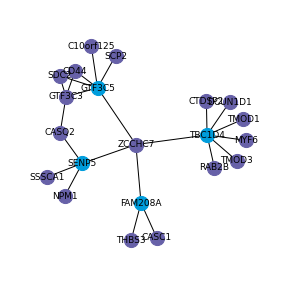

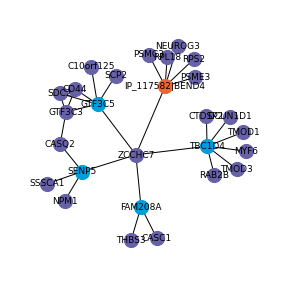

In [646]:
node='ZCCHC7' 
G_neig = get_2degneigb(G_o_noalt, node)
margin = 0.2
file_name, legend, start_pos = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':100},
                file_name='second_neighb_{}_noalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=margin,
                return_pos = True
        )
fixed_nodes = G_neig.nodes()
G_neig = get_2degneigb(G_o, node)
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.18, 'iterations':50},
                file_name='second_neighb_{}_withalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=margin,
                start_pos=start_pos,
                fixed_nodes=fixed_nodes
        )



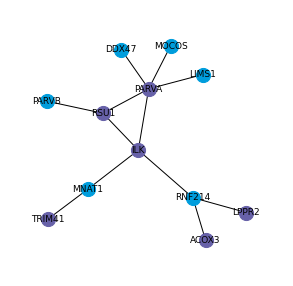

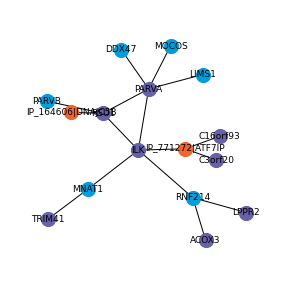

In [647]:
node='ILK' 
G_neig = get_2degneigb(G_o_noalt, node)
margin = 0.2
file_name, legend, start_pos = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':100},
                file_name='second_neighb_{}_noalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=margin,
                return_pos = True
        )
fixed_nodes = G_neig.nodes()
G_neig = get_2degneigb(G_o, node)
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.18, 'iterations':50},
                file_name='second_neighb_{}_withalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=margin,
                start_pos=start_pos,
                fixed_nodes=fixed_nodes
        )



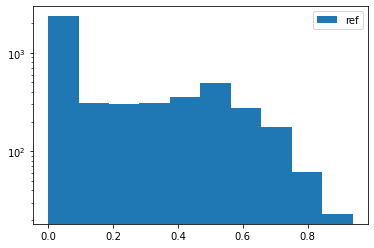

In [448]:
plt.hist(ref_2neighb_bet_cen, label='ref')

plt.yscale('log')
plt.legend()
plt.show()

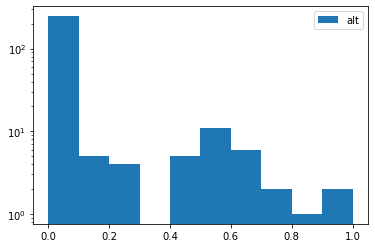

In [447]:
plt.hist(alt_2neighb_bet_cen, label='alt')
plt.yscale('log')
plt.legend()
plt.show()

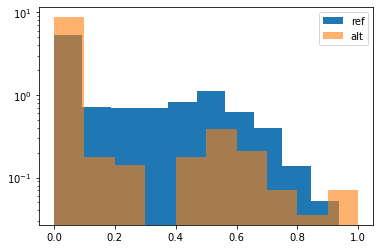

In [441]:
plt.hist(ref_2neighb_bet_cen, density=True, label='ref')
plt.hist(alt_2neighb_bet_cen, density=True, label='alt', alpha=0.6)

plt.yscale('log')
plt.legend()
plt.show()

In [377]:
alt_nodes =[x for x in G_o.nodes() if is_alt(x)]

In [381]:
alt_subnets_GO = {}
for node in alt_nodes:
    G_neig = get_2degneigb(G_o, node)
    gene_list = set(n for n in G_neig.nodes() if 'IP_' not in n and 'II_' not in n)
    GO_result = GOEA.run_study_nts(gene_list)
    alt_subnets_GO[node] = get_sig_go(GO_result)


Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0010287535832598988
Sample 30 / 500: p-value 0.0020566603251682817
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.008461923774682755
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0010287535832598988
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0002543158193718833
Sample 110 / 500: p-value 0.0005144826794766201
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 0.0007716445992425802
Sample 140 / 500: p-value 0.0007716445992425802
Sample 150 / 500: p-value 0.0035969337541263526
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.0005144826794766201
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0007716445992425802
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0005144826794766201
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.0005144826794766201
Sample 60 / 500: p-value 0.002828637460634967
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0017997630024671233
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.019402014087000125
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0005144826794766201
Sample 140 / 500: p-value 0.0012858096396662177
Sample 150 / 500: p-value 0.0010287535832598988
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.0005144826794766201
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0020566603251682817
Sample 30 / 500: p-value 0.0015428127767041794
Sample 40 / 500: p-value 0.0010287535832598988
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0015428127767041794
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.0007716445992425802
Sample 130 / 500: p-value 0.0007716445992425802
Sample 140 / 500: p-value 0.0007716445992425802
Sample 150 / 500: p-value 0.002313504752916642
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.0007716445992425802
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002056713211831479
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.0004115967340058577
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.0006173474473857904
Sample 60 / 500: p-value 0.00020581425263976088
Sample 70 / 500: p-value 0.00020581425263976088
Sample 80 / 500: p-value 9.491231735644415e-05
Sample 90 / 500: p-value 0.00020581425263976088
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 1.8861126897658808e-05
Sample 130 / 500: p-value 0.0018511847829331938
Sample 140 / 500: p-value 0.0006173474473857904
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.0004115967340058577
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%      9 of      9 study items found in association
 50%      9 of     18 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      80 GO terms are associated with      9 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.281259856845954e-05
Sample 10 / 500: p-value 0.0009261641368936062
Sample 20 / 500: p-value 0.0009261641368936062
Sample 30 / 500: p-value 0.0009261641368936062
Sample 40 / 500: p-value 0.0009261641368936062
Sample 50 / 500: p-value 0.0009261641368936062
Sample 60 / 500: p-value 0.0009261641368936062
Sample 70 / 500: p-value 0.0009261641368936062
Sample 80 / 500: p-value 0.0005293068935271684
Sample 90 / 500: p-value 0.0009261641368936062
Sample 100 / 500: p-value 0.0009261641368936062
Sample 110 / 500: p-value 0.0009261641368936062
Sample 120 / 500: p-value 0.0018515181065176902
Sample 130 / 500: p-value 0.0009261641368936062
Sample 140 / 500: p-value 0.0009261641368936062
Sample 150 / 500: p-value 0.0027760625759992888
Sample 160 / 500: p-value 0.0009261641368936062
Sample 170 / 500: p-value 0.0009261641368936062
Sample 180 / 500: p-value 0.0009261641368936062
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006173633297420889
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0021593822335657783
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 7.470701202373074e-05
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0012344090122772863
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0009259258687495142
Sample 180 / 500: p-value 0.0021593822335657783
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      1 of      1 study items found in association
 20%      1 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       7 GO terms are associated with      1 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.0010287535832598988
Sample 40 / 500: p-value 0.0015428127767041794
Sample 50 / 500: p-value 0.0005144826794766201
Sample 60 / 500: p-value 0.0017997630024671233
Sample 70 / 500: p-value 0.0012858096396662177
Sample 80 / 500: p-value 1.7166965023805317e-05
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.0017997630024671233
Sample 120 / 500: p-value 0.002313504752916642
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0007716445992425802
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.0010287535832598988
Sample 170 / 500: p-value 0.0017997630024671233
Sample 180 / 500: p-value 0.00025726781580222714
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.145356316010967e-05
Sample 10 / 500: p-value 0.003910470800168383
Sample 20 / 500: p-value 0.0012863390790027397
Sample 30 / 500: p-value 0.001131978389522417
Sample 40 / 500: p-value 0.00010290712632021935
Sample 50 / 500: p-value 1
Sample 60 / 500: p-value 0.002161049652724594
Sample 70 / 500: p-value 0.0013377926421628532
Sample 80 / 500: p-value 0.003395935168567219
Sample 90 / 500: p-value 0.004013377926488636
Sample 100 / 500: p-value 0.003087213789606549
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.0023668639053650658
Sample 130 / 500: p-value 0.03112940571186213
Sample 140 / 500: p-value 0.00010290712632021935
Sample 150 / 500: p-value 0.0013377926421628532
Sample 160 / 500: p-value 0.05258554154961144
Sample 170 / 500: p-value 0.001234885515842636
Sample 180 / 500: p-value 0.0001543606894803289
Sample 190 / 500: p-value 0.0100334448162208

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      29 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012345360318909806
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.0014402179042823527
Sample 30 / 500: p-value 0.0034958716815235396
Sample 40 / 500: p-value 0.0005144826794799012
Sample 50 / 500: p-value 0.009547709835635146
Sample 60 / 500: p-value 0.0007202386848146907
Sample 70 / 500: p-value 0.0004115967340125262
Sample 80 / 500: p-value 0.00020580895742290187
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.00215993765838918
Sample 110 / 500: p-value 0.0004115967340125262
Sample 120 / 500: p-value 0.001131687152935463
Sample 130 / 500: p-value 0.0006173633297511774
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.00020580895742290187
Sample 160 / 500: p-value 0.0009674879618050925
Sample 170 / 500: p-value 0.019966730719816927
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      92 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0009259258687495142
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0003087213789600963
Sample 90 / 500: p-value 0.0006173633297420889
Sample 100 / 500: p-value 0.0018511371783387362
Sample 110 / 500: p-value 0.0012344090122772863
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0006173633297420889
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0021593822335657783
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       9 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011474144584703907
Sample 10 / 500: p-value 0.0001543606894803289
Sample 20 / 500: p-value 0.0014921533316431812
Sample 30 / 500: p-value 0.05258554154961144
Sample 40 / 500: p-value 0.00030872137896065786
Sample 50 / 500: p-value 0.00030872137896065786
Sample 60 / 500: p-value 0.0027270388474858382
Sample 70 / 500: p-value 0.05258554154961144
Sample 80 / 500: p-value 5.145356316010967e-05
Sample 90 / 500: p-value 0.0002058142526404387
Sample 100 / 500: p-value 0.00041162850528087745
Sample 110 / 500: p-value 0.0009776177000420851
Sample 120 / 500: p-value 0.00010290712632021935
Sample 130 / 500: p-value 0.05258554154961144
Sample 140 / 500: p-value 0.0017494211474437368
Sample 150 / 500: p-value 0.03112940571186213
Sample 160 / 500: p-value 0.0014921533316431812
Sample 170 / 500: p-value 5.145356316010967e-05
Sample 180 / 500: p-value 0.05258554154961144
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 75 IDs ...
100%     73 of     73 study items found in association
 97%     73 of     75 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     421 GO terms are associated with     73 of     75 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0038385519450123726
Sample 10 / 500: p-value 0.0038590172370017665
Sample 20 / 500: p-value 0.0038590172370017665
Sample 30 / 500: p-value 0.0021599819221735897
Sample 40 / 500: p-value 0.0011150095678401763
Sample 50 / 500: p-value 0.0024080785246660464
Sample 60 / 500: p-value 0.0017025863400903026
Sample 70 / 500: p-value 0.0008951664608699486
Sample 80 / 500: p-value 0.00014584118902831602
Sample 90 / 500: p-value 8.171956164714923e-05
Sample 100 / 500: p-value 8.772428307236465e-05
Sample 110 / 500: p-value 0.0038590172370017665
Sample 120 / 500: p-value 0.0006971164665677996
Sample 130 / 500: p-value 4.397223225049746e-05
Sample 140 / 500: p-value 0.0011150095678401763
Sample 150 / 500: p-value 0.001188616866825874
Sample 160 / 500: p-value 0.0038385519450123726
Sample 170 / 500: p-value 0.003228760892224669
Sample 180 / 500: p-value 0.0011150095678401763
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      30 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00033557260809000046
Sample 10 / 500: p-value 0.0009259258687495142
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0006173633297420889
Sample 60 / 500: p-value 0.004314877291411381
Sample 70 / 500: p-value 0.0018511371783387362
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.0009259258687495142
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0009259258687495142
Sample 120 / 500: p-value 0.0015534065133876041
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0012344090122772863
Sample 160 / 500: p-value 0.0009259258687495142
Sample 170 / 500: p-value 0.0006173633297420889
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      79 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003601749421189181
Sample 10 / 500: p-value 0.0007202386848016983
Sample 20 / 500: p-value 0.0003601749421189181
Sample 30 / 500: p-value 0.002159382233558599
Sample 40 / 500: p-value 0.0003601749421189181
Sample 50 / 500: p-value 0.0003601749421189181
Sample 60 / 500: p-value 0.0014400326863894528
Sample 70 / 500: p-value 0.0032375737023809144
Sample 80 / 500: p-value 0.0007202386848016983
Sample 90 / 500: p-value 0.0003601749421189181
Sample 100 / 500: p-value 0.0003601749421189181
Sample 110 / 500: p-value 0.0017997630024461399
Sample 120 / 500: p-value 0.0003601749421189181
Sample 130 / 500: p-value 0.0010801912566923604
Sample 140 / 500: p-value 0.0010801912566923604
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.010756992512009698
Sample 170 / 500: p-value 0.0014400326863894528
Sample 180 / 500: p-value 0.0010801912566923604
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 20 IDs ...
100%     19 of     19 study items found in association
 95%     19 of     20 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     154 GO terms are associated with     19 of     20 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010290712631755698
Sample 10 / 500: p-value 0.0010290712631755698
Sample 20 / 500: p-value 0.0020571364362233138
Sample 30 / 500: p-value 0.0010290712631755698
Sample 40 / 500: p-value 0.0005211460961187386
Sample 50 / 500: p-value 0.0010290712631755698
Sample 60 / 500: p-value 0.0010290712631755698
Sample 70 / 500: p-value 0.00029757106981957075
Sample 80 / 500: p-value 0.0006917374766374947
Sample 90 / 500: p-value 0.0008829592563744151
Sample 100 / 500: p-value 0.0010290712631755698
Sample 110 / 500: p-value 0.0010290712631755698
Sample 120 / 500: p-value 0.0010290712631755698
Sample 130 / 500: p-value 0.0028107398536342636
Sample 140 / 500: p-value 7.794372203264222e-05
Sample 150 / 500: p-value 0.0010290712631755698
Sample 160 / 500: p-value 0.0020571364362233138
Sample 170 / 500: p-value 0.0010290712631755698
Sample 180 / 500: p-value 0.0010290712631755698
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      1 of      1 study items found in association
 50%      1 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      18 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340125262
Sample 10 / 500: p-value 0.00010290712632154739
Sample 20 / 500: p-value 0.0014402179042823527
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.0004115967340125262
Sample 60 / 500: p-value 0.0007202386848146907
Sample 70 / 500: p-value 0.0038040370634038843
Sample 80 / 500: p-value 0.003290401617597323
Sample 90 / 500: p-value 0.0007202386848146907
Sample 100 / 500: p-value 0.0012345360318909806
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.00020580895742290187
Sample 130 / 500: p-value 0.00606246034728255
Sample 140 / 500: p-value 0.0004115967340125262
Sample 150 / 500: p-value 0.00020580895742290187
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.001131687152935463
Sample 180 / 500: p-value 0.0004115967340125262
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     212 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006174427579281609
Sample 10 / 500: p-value 0.0006174427579281609
Sample 20 / 500: p-value 0.0006174427579281609
Sample 30 / 500: p-value 0.0006174427579281609
Sample 40 / 500: p-value 0.0006174427579281609
Sample 50 / 500: p-value 0.0006174427579281609
Sample 60 / 500: p-value 0.0006174427579281609
Sample 70 / 500: p-value 0.0006174427579281609
Sample 80 / 500: p-value 0.0006174427579281609
Sample 90 / 500: p-value 0.0006174427579281609
Sample 100 / 500: p-value 0.0005863871509193336
Sample 110 / 500: p-value 0.0006174427579281609
Sample 120 / 500: p-value 0.0006174427579281609
Sample 130 / 500: p-value 0.0006174427579281609
Sample 140 / 500: p-value 0.0012345360318887326
Sample 150 / 500: p-value 0.0006174427579281609
Sample 160 / 500: p-value 0.0006174427579281609
Sample 170 / 500: p-value 0.0006174427579281609
Sample 180 / 500: p-value 0.0006174427579281609
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 34 IDs ...
100%     34 of     34 study items found in association
100%     34 of     34 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     249 GO terms are associated with     34 of     34 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00022892648103612555
Sample 10 / 500: p-value 0.0017494211474409524
Sample 20 / 500: p-value 0.0017494211474409524
Sample 30 / 500: p-value 0.0017494211474409524
Sample 40 / 500: p-value 0.0007344445855613263
Sample 50 / 500: p-value 0.0017494211474409524
Sample 60 / 500: p-value 0.0017494211474409524
Sample 70 / 500: p-value 0.0017494211474409524
Sample 80 / 500: p-value 0.00039416891957913227
Sample 90 / 500: p-value 0.005239356493978581
Sample 100 / 500: p-value 0.0017494211474409524
Sample 110 / 500: p-value 0.0017494211474409524
Sample 120 / 500: p-value 0.0017494211474409524
Sample 130 / 500: p-value 0.0017494211474409524
Sample 140 / 500: p-value 0.00031514490091927007
Sample 150 / 500: p-value 0.0017494211474409524
Sample 160 / 500: p-value 0.0005533762159574858
Sample 170 / 500: p-value 0.0017494211474409524
Sample 180 / 500: p-value 0.0017494211474409524
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.0006173633297511774
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.005241512048809792
Sample 40 / 500: p-value 0.0004115967340125262
Sample 50 / 500: p-value 0.006267644469605399
Sample 60 / 500: p-value 0.00020580895742290187
Sample 70 / 500: p-value 0.0005144826794799012
Sample 80 / 500: p-value 0.07133463855128046
Sample 90 / 500: p-value 0.0017487009987143117
Sample 100 / 500: p-value 0.007600824983273598
Sample 110 / 500: p-value 0.00020580895742290187
Sample 120 / 500: p-value 0.0010288329787036042
Sample 130 / 500: p-value 0.03397536440308173
Sample 140 / 500: p-value 0.002879397947307262
Sample 150 / 500: p-value 0.0009259735092933014
Sample 160 / 500: p-value 0.001954329919013421
Sample 170 / 500: p-value 0.0012345360318909806
Sample 180 / 500: p-value 0.0003087054933218987
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.015230254695393864
Sample 10 / 500: p-value 0.00010290712632021935
Sample 20 / 500: p-value 1
Sample 30 / 500: p-value 0.0004630820684409873
Sample 40 / 500: p-value 0.006483148958173674
Sample 50 / 500: p-value 0.00025726781580054814
Sample 60 / 500: p-value 0.00041162850528087745
Sample 70 / 500: p-value 0.00030872137896065786
Sample 80 / 500: p-value 0.03112940571186213
Sample 90 / 500: p-value 0.00030872137896065786
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.00025726781580054814
Sample 120 / 500: p-value 0.0014921533316431812
Sample 130 / 500: p-value 0.011474144584703907
Sample 140 / 500: p-value 0.0027270388474858382
Sample 150 / 500: p-value 0.0008747105737218636
Sample 160 / 500: p-value 5.145356316010967e-05
Sample 170 / 500: p-value 0.0028813995369661016
Sample 180 / 500: p-value 0.00036017494212076774
Sample 190 / 500: p-value 0.00051

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011474144584703907
Sample 10 / 500: p-value 0.0002058142526404387
Sample 20 / 500: p-value 0.0023154103422049306
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.0012863390790027397
Sample 50 / 500: p-value 0.02130177514828186
Sample 60 / 500: p-value 0.0002058142526404387
Sample 70 / 500: p-value 0.006328788268693616
Sample 80 / 500: p-value 0.006483148958173674
Sample 90 / 500: p-value 0.00396192436332846
Sample 100 / 500: p-value 0.00030872137896065786
Sample 110 / 500: p-value 0.004013377926488636
Sample 120 / 500: p-value 0.006483148958173674
Sample 130 / 500: p-value 0.0013377926421628532
Sample 140 / 500: p-value 0.0020066889632442855
Sample 150 / 500: p-value 0.00010290712632021935
Sample 160 / 500: p-value 0.05258554154961144
Sample 170 / 500: p-value 0.003910470800168383
Sample 180 / 500: p-value 0.002263956779044822
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832497966
Sample 10 / 500: p-value 0.00246767484744869
Sample 20 / 500: p-value 0.00246767484744869
Sample 30 / 500: p-value 0.0002250143807695096
Sample 40 / 500: p-value 0.0008230663960435913
Sample 50 / 500: p-value 0.0008523911162237152
Sample 60 / 500: p-value 0.0012344090122754605
Sample 70 / 500: p-value 0.0010287535832497966
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0008230663960435913
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0006173474473857904
Sample 120 / 500: p-value 0.0014400326863921046
Sample 130 / 500: p-value 0.0008230663960435913
Sample 140 / 500: p-value 0.0008230663960435913
Sample 150 / 500: p-value 0.0012344090122754605
Sample 160 / 500: p-value 0.0006173474473857904
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      38 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.0015428127767041794
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0005144826794766201
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.0005144826794766201
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0005144826794766201
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0015428127767041794
Sample 110 / 500: p-value 0.0007716445992425802
Sample 120 / 500: p-value 0.0007716445992425802
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.007439297952179216
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 141 IDs ...
100%    135 of    135 study items found in association
 96%    135 of    141 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     545 GO terms are associated with    135 of    141 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0044916749853671995
Sample 10 / 500: p-value 0.0003105996986664627
Sample 20 / 500: p-value 0.0003105996986664627
Sample 30 / 500: p-value 0.0032888042776181383
Sample 40 / 500: p-value 0.00015604352916412736
Sample 50 / 500: p-value 0.0014479204303968127
Sample 60 / 500: p-value 0.0022732720432809064
Sample 70 / 500: p-value 0.0003105996986664627
Sample 80 / 500: p-value 0.0005152004309738572
Sample 90 / 500: p-value 0.00015604352916412736
Sample 100 / 500: p-value 0.00047188394681856917
Sample 110 / 500: p-value 1.2807678301735497e-05
Sample 120 / 500: p-value 0.0044916749853671995
Sample 130 / 500: p-value 0.00142206871547383
Sample 140 / 500: p-value 0.00019533022836517073
Sample 150 / 500: p-value 0.00023592862297448203
Sample 160 / 500: p-value 0.0005152004309738572
Sample 170 / 500: p-value 0.0017322565597119005
Sample 180 / 500: p-value 0.0005278088766028338
Sample 190 

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
      54 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      8 of      8 study items found in association
 89%      8 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     114 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009259735092810342
Sample 10 / 500: p-value 0.00046308206844082687
Sample 20 / 500: p-value 0.00046308206844082687
Sample 30 / 500: p-value 0.0013886743912331651
Sample 40 / 500: p-value 0.0018511847829386805
Sample 50 / 500: p-value 0.00046308206844082687
Sample 60 / 500: p-value 0.0018511847829386805
Sample 70 / 500: p-value 0.0018511847829386805
Sample 80 / 500: p-value 0.0009259735092810342
Sample 90 / 500: p-value 0.00046308206844082687
Sample 100 / 500: p-value 0.00046308206844082687
Sample 110 / 500: p-value 0.00046308206844082687
Sample 120 / 500: p-value 0.00046308206844082687
Sample 130 / 500: p-value 0.00046308206844082687
Sample 140 / 500: p-value 0.00046308206844082687
Sample 150 / 500: p-value 0.00046308206844082687
Sample 160 / 500: p-value 0.00046308206844082687
Sample 170 / 500: p-value 0.00046308206844082687
Sample 180 / 500: p-value 0.00046308206844082687
Sa

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.0026219718309617203
Sample 20 / 500: p-value 0.000308705493313369
Sample 30 / 500: p-value 0.0004630344123500744
Sample 40 / 500: p-value 0.0012344407639008114
Sample 50 / 500: p-value 0.00015436068947805606
Sample 60 / 500: p-value 0.0004630344123500744
Sample 70 / 500: p-value 0.00016731875174745613
Sample 80 / 500: p-value 0.0033922668464590787
Sample 90 / 500: p-value 0.00015436068947805606
Sample 100 / 500: p-value 0.00015436068947805606
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.000308705493313369
Sample 130 / 500: p-value 0.00015436068947805606
Sample 140 / 500: p-value 0.0004630344123500744
Sample 150 / 500: p-value 0.00015436068947805606
Sample 160 / 500: p-value 0.00015436068947805606
Sample 170 / 500: p-value 0.00015436068947805606
Sample 180 / 500: p-value 0.000308705493313369
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     16 of     16 study items found in association
100%     16 of     16 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     160 GO terms are associated with     16 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008232570105563324
Sample 10 / 500: p-value 0.0008232570105563324
Sample 20 / 500: p-value 0.0016458785958249694
Sample 30 / 500: p-value 0.0008232570105563324
Sample 40 / 500: p-value 0.0008232570105563324
Sample 50 / 500: p-value 0.0008232570105563324
Sample 60 / 500: p-value 0.0008232570105563324
Sample 70 / 500: p-value 0.0008232570105563324
Sample 80 / 500: p-value 0.0008232570105563324
Sample 90 / 500: p-value 0.0008232570105563324
Sample 100 / 500: p-value 0.0008232570105563324
Sample 110 / 500: p-value 0.0008232570105563324
Sample 120 / 500: p-value 0.0016458785958249694
Sample 130 / 500: p-value 0.00011969151699840295
Sample 140 / 500: p-value 0.0008232570105563324
Sample 150 / 500: p-value 0.0008232570105563324
Sample 160 / 500: p-value 0.0008232570105563324
Sample 170 / 500: p-value 0.0016458785958249694
Sample 180 / 500: p-value 0.0008232570105563324
Sample 190 / 5

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      39 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00026730357005967794
Sample 10 / 500: p-value 0.0001740550492785805
Sample 20 / 500: p-value 2.8566681219697045e-06
Sample 30 / 500: p-value 0.0009259258687495142
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0021593822335657783
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.006159354854141043
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0003087213789600963
Sample 120 / 500: p-value 0.0006173633297420889
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.010452065402371763
Sample 150 / 500: p-value 0.0015428127766913176
Sample 160 / 500: p-value 0.0018511371783387362
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      39 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009259258687495142
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.00039569388591263987
Sample 30 / 500: p-value 0.0027756343698974234
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0006173633297420889
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.009839768759579443
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0003087213789600963
Sample 120 / 500: p-value 0.006415522842605618
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0027756343698974234
Sample 160 / 500: p-value 0.0006173633297420889
Sample 170 / 500: p-value 0.0018511371783387362
Sample 180 / 500: p-value 0.0018511371783387362
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      24 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007716445992425802
Sample 10 / 500: p-value 0.0007716445992425802
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.0001918721379984934
Sample 40 / 500: p-value 0.0005144826794766201
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0025702962939408154
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 2.1438875977741675e-05
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00039237495230394097
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.01965528078031811
Sample 180 / 500: p-value 0.0005144826794766201
Sample 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      68 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.0007203498842261676
Sample 20 / 500: p-value 0.0021596043576714344
Sample 30 / 500: p-value 0.0007203498842261676
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.0007203498842261676
Sample 60 / 500: p-value 0.0006749452909771852
Sample 70 / 500: p-value 0.0007203498842261676
Sample 80 / 500: p-value 0.0007203498842261676
Sample 90 / 500: p-value 0.0007203498842261676
Sample 100 / 500: p-value 0.0007203498842261676
Sample 110 / 500: p-value 0.0007203498842261676
Sample 120 / 500: p-value 5.749135921980808e-05
Sample 130 / 500: p-value 0.0007203498842261676
Sample 140 / 500: p-value 0.0007203498842261676
Sample 150 / 500: p-value 0.0007203498842261676
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0007203498842261676
Sample 180 / 500: p-value 0.0004897776692981467
Sample 190 / 50

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      68 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.0007203498842261676
Sample 20 / 500: p-value 0.0007203498842261676
Sample 30 / 500: p-value 0.0007203498842261676
Sample 40 / 500: p-value 0.00431487729132724
Sample 50 / 500: p-value 0.0007203498842261676
Sample 60 / 500: p-value 0.0007203498842261676
Sample 70 / 500: p-value 0.0014402179042330495
Sample 80 / 500: p-value 0.0007203498842261676
Sample 90 / 500: p-value 0.0007203498842261676
Sample 100 / 500: p-value 0.0008327795188734566
Sample 110 / 500: p-value 0.0007203498842261676
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 0.0007203498842261676
Sample 140 / 500: p-value 0.002878509541949931
Sample 150 / 500: p-value 0.0007203498842261676
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0007203498842261676
Sample 180 / 500: p-value 0.0007203498842261676
Sample 190 / 500: 

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 29 IDs ...
100%     29 of     29 study items found in association
100%     29 of     29 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     104 GO terms are associated with     29 of     29 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014921533316434993
Sample 10 / 500: p-value 0.0014921533316434993
Sample 20 / 500: p-value 0.0014921533316434993
Sample 30 / 500: p-value 0.0014921533316434993
Sample 40 / 500: p-value 0.0014921533316434993
Sample 50 / 500: p-value 0.0014921533316434993
Sample 60 / 500: p-value 0.0010658980806878995
Sample 70 / 500: p-value 0.0014921533316434993
Sample 80 / 500: p-value 0.0014921533316434993
Sample 90 / 500: p-value 0.0014921533316434993
Sample 100 / 500: p-value 0.0014921533316434993
Sample 110 / 500: p-value 0.0014921533316434993
Sample 120 / 500: p-value 0.0014921533316434993
Sample 130 / 500: p-value 0.0013124534163317344
Sample 140 / 500: p-value 0.0005813953527372728
Sample 150 / 500: p-value 0.0014921533316434993
Sample 160 / 500: p-value 0.0014921533316434993
Sample 170 / 500: p-value 0.00019347429230431808
Sample 180 / 500: p-value 0.0014921533316434993
Sample 190 / 5

  METHOD fdr:
      17 GO terms found significant (< 0.05=alpha) ( 17 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       5 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.0004115967340125262
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.0008231087446469157
Sample 50 / 500: p-value 0.0013373796157088269
Sample 60 / 500: p-value 0.0003087054933218987
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.00041204682692741934
Sample 90 / 500: p-value 0.0005144826794799012
Sample 100 / 500: p-value 0.0003015781396131532
Sample 110 / 500: p-value 0.0004115967340125262
Sample 120 / 500: p-value 0.0005144826794799012
Sample 130 / 500: p-value 0.0014402179042823527
Sample 140 / 500: p-value 0.0013373796157088269
Sample 150 / 500: p-value 0.0010288329787036042
Sample 160 / 500: p-value 0.004112154788256519
Sample 170 / 500: p-value 0.0006173633297511774
Sample 180 / 500: p-value 0.0013373796157088269
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 53 IDs ...
100%     53 of     53 study items found in association
100%     53 of     53 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     257 GO terms are associated with     53 of     53 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027270388475463714
Sample 10 / 500: p-value 0.001627648054768426
Sample 20 / 500: p-value 0.0024517055902347554
Sample 30 / 500: p-value 0.0014822644759726789
Sample 40 / 500: p-value 0.0021027951507778878
Sample 50 / 500: p-value 0.0014822644759726789
Sample 60 / 500: p-value 0.0027270388475463714
Sample 70 / 500: p-value 0.0001367707967693696
Sample 80 / 500: p-value 0.0027270388475463714
Sample 90 / 500: p-value 0.00010868823173470242
Sample 100 / 500: p-value 0.0027270388475463714
Sample 110 / 500: p-value 0.0012112079060736473
Sample 120 / 500: p-value 0.0027270388475463714
Sample 130 / 500: p-value 0.0027270388475463714
Sample 140 / 500: p-value 0.002635699864563225
Sample 150 / 500: p-value 0.00015100163625676185
Sample 160 / 500: p-value 8.981443131967563e-05
Sample 170 / 500: p-value 0.001627648054768426
Sample 180 / 500: p-value 0.0016946699200082883
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 25 IDs ...
100%     25 of     25 study items found in association
100%     25 of     25 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     151 GO terms are associated with     25 of     25 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012863390789820924
Sample 10 / 500: p-value 0.0012863390789820924
Sample 20 / 500: p-value 0.0012863390789820924
Sample 30 / 500: p-value 0.0012863390789820924
Sample 40 / 500: p-value 0.0012863390789820924
Sample 50 / 500: p-value 0.0012863390789820924
Sample 60 / 500: p-value 0.0012863390789820924
Sample 70 / 500: p-value 0.0012863390789820924
Sample 80 / 500: p-value 0.0010855048488039795
Sample 90 / 500: p-value 0.00043090007211071883
Sample 100 / 500: p-value 0.0012863390789820924
Sample 110 / 500: p-value 0.0012863390789820924
Sample 120 / 500: p-value 0.0012863390789820924
Sample 130 / 500: p-value 0.0012863390789820924
Sample 140 / 500: p-value 0.0012863390789820924
Sample 150 / 500: p-value 0.0012863390789820924
Sample 160 / 500: p-value 0.0025710895946653976
Sample 170 / 500: p-value 0.0012863390789820924
Sample 180 / 500: p-value 0.00011474913726460023
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 25 IDs ...
100%     25 of     25 study items found in association
100%     25 of     25 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     151 GO terms are associated with     25 of     25 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012863390789820924
Sample 10 / 500: p-value 0.0025710895946653976
Sample 20 / 500: p-value 0.0012863390789820924
Sample 30 / 500: p-value 0.0012863390789820924
Sample 40 / 500: p-value 0.0012863390789820924
Sample 50 / 500: p-value 0.0012863390789820924
Sample 60 / 500: p-value 0.0012863390789820924
Sample 70 / 500: p-value 0.0025710895946653976
Sample 80 / 500: p-value 0.0012863390789820924
Sample 90 / 500: p-value 0.0012863390789820924
Sample 100 / 500: p-value 0.0025710895946653976
Sample 110 / 500: p-value 0.0004680005746632524
Sample 120 / 500: p-value 0.0012863390789820924
Sample 130 / 500: p-value 0.0025710895946653976
Sample 140 / 500: p-value 0.0025710895946653976
Sample 150 / 500: p-value 0.0025710895946653976
Sample 160 / 500: p-value 0.0012863390789820924
Sample 170 / 500: p-value 0.0012863390789820924
Sample 180 / 500: p-value 0.0001885334023062971
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008231087446442056
Sample 10 / 500: p-value 0.00035575906570816876
Sample 20 / 500: p-value 0.001645624608845148
Sample 30 / 500: p-value 0.0008231087446442056
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.00287828755492292
Sample 60 / 500: p-value 0.000411628505284834
Sample 70 / 500: p-value 0.000411628505284834
Sample 80 / 500: p-value 0.0008231087446442056
Sample 90 / 500: p-value 0.000411628505284834
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.0008231087446442056
Sample 120 / 500: p-value 0.0002507226266074806
Sample 130 / 500: p-value 0.0024675479586025477
Sample 140 / 500: p-value 0.0008231087446442056
Sample 150 / 500: p-value 0.0008231087446442056
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.000411628505284834
Sample 180 / 500: p-value 0.000411628505284834
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000411628505284834
Sample 10 / 500: p-value 0.001645624608845148
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.0008231087446442056
Sample 50 / 500: p-value 0.000411628505284834
Sample 60 / 500: p-value 0.000411628505284834
Sample 70 / 500: p-value 0.000411628505284834
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.001645624608845148
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.000411628505284834
Sample 120 / 500: p-value 0.0012344407639308449
Sample 130 / 500: p-value 0.005749323528190949
Sample 140 / 500: p-value 6.660986387016766e-06
Sample 150 / 500: p-value 0.0020566603251746356
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.0008231087446442056
Sample 180 / 500: p-value 0.000411628505284834
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 25 IDs ...
100%     23 of     23 study items found in association
 92%     23 of     25 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     209 GO terms are associated with     23 of     25 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012863390789820924
Sample 10 / 500: p-value 0.0012863390789820924
Sample 20 / 500: p-value 0.00020515509434547208
Sample 30 / 500: p-value 0.0006313671203693594
Sample 40 / 500: p-value 0.0012863390789820924
Sample 50 / 500: p-value 0.0012863390789820924
Sample 60 / 500: p-value 0.001948684297788159
Sample 70 / 500: p-value 0.0012863390789820924
Sample 80 / 500: p-value 0.0010855048488039795
Sample 90 / 500: p-value 0.0012863390789820924
Sample 100 / 500: p-value 0.0008689759452408834
Sample 110 / 500: p-value 0.0012863390789820924
Sample 120 / 500: p-value 0.0012863390789820924
Sample 130 / 500: p-value 0.0012863390789820924
Sample 140 / 500: p-value 0.0012863390789820924
Sample 150 / 500: p-value 0.0009209153564274771
Sample 160 / 500: p-value 0.0012863390789820924
Sample 170 / 500: p-value 0.0038542534274499636
Sample 180 / 500: p-value 0.0012863390789820924
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      46 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0007716445992425802
Sample 20 / 500: p-value 0.0012858096396662177
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0005144826794766201
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0007716445992425802
Sample 70 / 500: p-value 0.0007716445992425802
Sample 80 / 500: p-value 0.0007716445992425802
Sample 90 / 500: p-value 0.0010287535832598988
Sample 100 / 500: p-value 0.0007716445992425802
Sample 110 / 500: p-value 0.0007716445992425802
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 0.0010287535832598988
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.0007716445992425802
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      65 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006173474473857904
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.0014400326863921046
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.0010287535832497966
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.0012344090122754605
Sample 100 / 500: p-value 0.0004115967340058577
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.0034945236259344486
Sample 140 / 500: p-value 0.0008230663960435913
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.004315431687824565
Sample 170 / 500: p-value 0.0016456246088239054
Sample 180 / 500: p-value 0.0010287535832497966
Sample 190

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 21 IDs ...
100%     21 of     21 study items found in association
100%     21 of     21 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     109 GO terms are associated with     21 of     21 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007636096972312434
Sample 10 / 500: p-value 0.0010805248263722912
Sample 20 / 500: p-value 0.0010805248263722912
Sample 30 / 500: p-value 0.0010805248263722912
Sample 40 / 500: p-value 0.0010805248263722912
Sample 50 / 500: p-value 0.0010805248263722912
Sample 60 / 500: p-value 0.0010805248263722912
Sample 70 / 500: p-value 0.0010805248263722912
Sample 80 / 500: p-value 0.0010805248263722912
Sample 90 / 500: p-value 0.0021599376583812478
Sample 100 / 500: p-value 0.0010805248263722912
Sample 110 / 500: p-value 0.0010805248263722912
Sample 120 / 500: p-value 0.0010805248263722912
Sample 130 / 500: p-value 0.0010805248263722912
Sample 140 / 500: p-value 0.0021599376583812478
Sample 150 / 500: p-value 0.0010805248263722912
Sample 160 / 500: p-value 0.0010805248263722912
Sample 170 / 500: p-value 0.0010805248263722912
Sample 180 / 500: p-value 0.0016532921917779908
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
      15 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      87 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000411628505284834
Sample 10 / 500: p-value 0.0012344407639308449
Sample 20 / 500: p-value 0.0008231087446442056
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.000411628505284834
Sample 60 / 500: p-value 0.0012344407639308449
Sample 70 / 500: p-value 0.00022580452254365743
Sample 80 / 500: p-value 0.0008231087446442056
Sample 90 / 500: p-value 0.000411628505284834
Sample 100 / 500: p-value 0.0008231087446442056
Sample 110 / 500: p-value 0.004929766579138977
Sample 120 / 500: p-value 0.000411628505284834
Sample 130 / 500: p-value 0.0008231087446442056
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 0.000411628505284834
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.000411628505284834
Sample 180 / 500: p-value 8.263094113868706e-05
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      14 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.145356316010967e-05
Sample 10 / 500: p-value 0.00036017494212076774
Sample 20 / 500: p-value 5.145356316010967e-05
Sample 30 / 500: p-value 0.0007203498842415355
Sample 40 / 500: p-value 0.0017494211474437368
Sample 50 / 500: p-value 5.145356316010967e-05
Sample 60 / 500: p-value 0.0005659891947612055
Sample 70 / 500: p-value 0.003087213789606549
Sample 80 / 500: p-value 0.004064831489648711
Sample 90 / 500: p-value 0.0002058142526404387
Sample 100 / 500: p-value 0.00036017494212076774
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.036326215591039164
Sample 130 / 500: p-value 0.0006174427579213169
Sample 140 / 500: p-value 0.0064316953950138535
Sample 150 / 500: p-value 0.001234885515842636
Sample 160 / 500: p-value 0.006483148958173674
Sample 170 / 500: p-value 0.0010290712632021928
Sample 180 / 500: p-value 0.00025726781580054814
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
100%     19 of     19 study items found in association
100%     19 of     19 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     111 GO terms are associated with     19 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009776177000506224
Sample 10 / 500: p-value 0.0009776177000506224
Sample 20 / 500: p-value 0.0009776177000506224
Sample 30 / 500: p-value 0.0009776177000506224
Sample 40 / 500: p-value 0.00046953001818706824
Sample 50 / 500: p-value 0.002408078524744832
Sample 60 / 500: p-value 0.0019543299190052815
Sample 70 / 500: p-value 0.0009134408093927139
Sample 80 / 500: p-value 0.0005908692553277108
Sample 90 / 500: p-value 8.182406955964912e-05
Sample 100 / 500: p-value 0.0009776177000506224
Sample 110 / 500: p-value 1.8959722281112465e-05
Sample 120 / 500: p-value 0.000188055661937364
Sample 130 / 500: p-value 0.0009776177000506224
Sample 140 / 500: p-value 0.0009776177000506224
Sample 150 / 500: p-value 0.0009776177000506224
Sample 160 / 500: p-value 0.0002680252273133011
Sample 170 / 500: p-value 0.0009776177000506224
Sample 180 / 500: p-value 0.0009776177000506224
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.016974765481114838
Sample 30 / 500: p-value 0.0006173474473857904
Sample 40 / 500: p-value 0.0006173474473857904
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 5.7906315736968984e-05
Sample 80 / 500: p-value 0.0008230663960435913
Sample 90 / 500: p-value 0.00246767484744869
Sample 100 / 500: p-value 0.0006173474473857904
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.0003800679347256084
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0010287535832497966
Sample 150 / 500: p-value 0.002673108060728289
Sample 160 / 500: p-value 0.0016456246088239054
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.00534085340678886
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      57 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000617347447378735
Sample 10 / 500: p-value 0.00015436068947805606
Sample 20 / 500: p-value 0.000308705493313369
Sample 30 / 500: p-value 0.0004630344123500744
Sample 40 / 500: p-value 0.005239356493909827
Sample 50 / 500: p-value 0.000308705493313369
Sample 60 / 500: p-value 0.000617347447378735
Sample 70 / 500: p-value 0.00015436068947805606
Sample 80 / 500: p-value 0.0007716445992261863
Sample 90 / 500: p-value 0.002313742722768065
Sample 100 / 500: p-value 0.000308705493313369
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.0004630344123500744
Sample 130 / 500: p-value 0.004316097214396884
Sample 140 / 500: p-value 0.0007716445992261863
Sample 150 / 500: p-value 0.0029301374490100693
Sample 160 / 500: p-value 0.00015436068947805606
Sample 170 / 500: p-value 0.00416216515001395
Sample 180 / 500: p-value 0.00416216515001395
Sample 190 / 500: p-val

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       6 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0001543606894803289
Sample 10 / 500: p-value 0.0027784924106459075
Sample 20 / 500: p-value 0.00041162850528087745
Sample 30 / 500: p-value 0.0009776177000420851
Sample 40 / 500: p-value 0.00036017494212076774
Sample 50 / 500: p-value 0.0007718034474016454
Sample 60 / 500: p-value 0.036326215591039164
Sample 70 / 500: p-value 0.00030872137896065786
Sample 80 / 500: p-value 0.0002058142526404387
Sample 90 / 500: p-value 0.0007203498842415355
Sample 100 / 500: p-value 0.00041162850528087745
Sample 110 / 500: p-value 0.00030872137896065786
Sample 120 / 500: p-value 0.0012863390790027397
Sample 130 / 500: p-value 0.0038075636738481274
Sample 140 / 500: p-value 0.00025726781580054814
Sample 150 / 500: p-value 0.05258554154961144
Sample 160 / 500: p-value 0.00041162850528087745
Sample 170 / 500: p-value 0.006328788268693616
Sample 180 / 500: p-value 0.0025212245948453478
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      7 of      7 study items found in association
 88%      7 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      48 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000411628505284834
Sample 10 / 500: p-value 0.001645624608845148
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.003699322818968287
Sample 50 / 500: p-value 0.0012344407639308449
Sample 60 / 500: p-value 0.0008231087446442056
Sample 70 / 500: p-value 0.0008231087446442056
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.000411628505284834
Sample 100 / 500: p-value 0.0008231087446442056
Sample 110 / 500: p-value 0.000411628505284834
Sample 120 / 500: p-value 0.000411628505284834
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.0012344407639308449
Sample 150 / 500: p-value 0.000411628505284834
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.000411628505284834
Sample 180 / 500: p-value 0.000411628505284834
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      26 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.0015428127767041794
Sample 20 / 500: p-value 0.0007716445992425802
Sample 30 / 500: p-value 0.0012858096396662177
Sample 40 / 500: p-value 0.0004117014283799426
Sample 50 / 500: p-value 0.0012858096396662177
Sample 60 / 500: p-value 0.0012858096396662177
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.0020566603251682817
Sample 120 / 500: p-value 0.00021485944531062098
Sample 130 / 500: p-value 0.002236512232800158
Sample 140 / 500: p-value 0.0007716445992425802
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012344090122754605
Sample 10 / 500: p-value 0.004930779810546311
Sample 20 / 500: p-value 0.0030838792943655435
Sample 30 / 500: p-value 0.0008230663960435913
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.002673108060728289
Sample 60 / 500: p-value 0.00020581425263976088
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.0010287535832497966
Sample 100 / 500: p-value 0.0006173474473857904
Sample 110 / 500: p-value 0.0014400326863921046
Sample 120 / 500: p-value 0.0012344090122754605
Sample 130 / 500: p-value 0.00246767484744869
Sample 140 / 500: p-value 0.0012344090122754605
Sample 150 / 500: p-value 0.0006173474473857904
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%      9 of      9 study items found in association
 90%      9 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     128 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0020567132118183835
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0010288329786803754
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 5.474235846069921e-05
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0003361522005147571
Sample 170 / 500: p-value 0.0010288329786803754
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      42 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005144826794766201
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0005144826794766201
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0010287535832598988
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.002313504752916642
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.0005144826794766201
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0005144826794766201
Sample 150 / 500: p-value 0.01050464677501947
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.00025726781580222714
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      42 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012858096396662177
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.004109935376198607
Sample 30 / 500: p-value 0.0010287535832598988
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.0017997630024671233
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0017997630024671233
Sample 80 / 500: p-value 9.295641412597785e-05
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0028270349564176625
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0005144826794766201
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.00015374534089505678
Sample 180 / 500: p-value 0.0012858096396662177
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       4 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016465140211235013
Sample 10 / 500: p-value 5.145356316010967e-05
Sample 20 / 500: p-value 0.02130177514828186
Sample 30 / 500: p-value 0.0015436068948032936
Sample 40 / 500: p-value 0.00010290712632021935
Sample 50 / 500: p-value 5.145356316010967e-05
Sample 60 / 500: p-value 0.0007718034474016454
Sample 70 / 500: p-value 0.0005659891947612055
Sample 80 / 500: p-value 0.05258554154961144
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 0.00025726781580054814
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.006328788268693616
Sample 130 / 500: p-value 0.0004630820684409873
Sample 140 / 500: p-value 0.00036017494212076774
Sample 150 / 500: p-value 0.000823257010561755
Sample 160 / 500: p-value 0.017134036532315
Sample 170 / 500: p-value 0.00030872137896065786
Sample 180 / 500: p-value 0.00030872137896065786
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.0004115967340125262
Sample 20 / 500: p-value 0.0009259735092933014
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.0013373796157088269
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.00010290712632154739
Sample 90 / 500: p-value 0.0004115967340125262
Sample 100 / 500: p-value 0.00010290712632154739
Sample 110 / 500: p-value 0.10240840748346328
Sample 120 / 500: p-value 0.0006173633297511774
Sample 130 / 500: p-value 0.00010290712632154739
Sample 140 / 500: p-value 0.0005144826794799012
Sample 150 / 500: p-value 0.008010854335179785
Sample 160 / 500: p-value 0.0017487009987143117
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.0009259735092933014
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004275842435092764
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.004622488162967874
Sample 30 / 500: p-value 0.0008242707640290746
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0009259258687495142
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0064664907734064666
Sample 90 / 500: p-value 0.0009259258687495142
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0018511371783387362
Sample 130 / 500: p-value 0.0006173633297420889
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0021593822335657783
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      2 of      2 study items found in association
 50%      2 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      19 GO terms are associated with      2 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.0004115967340058577
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.0014400326863921046
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0016456246088239054
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.00020581425263976088
Sample 100 / 500: p-value 0.0010287535832497966
Sample 110 / 500: p-value 0.002056713211831479
Sample 120 / 500: p-value 0.0006173474473857904
Sample 130 / 500: p-value 0.0006173474473857904
Sample 140 / 500: p-value 0.0006173474473857904
Sample 150 / 500: p-value 0.00020581425263976088
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.004930779810546311
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      69 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0005144826794766201
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.011014801104846173
Sample 50 / 500: p-value 0.0010287535832598988
Sample 60 / 500: p-value 0.0007716445992425802
Sample 70 / 500: p-value 0.0017997630024671233
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.002313504752916642
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0017997630024671233
Sample 180 / 500: p-value 0.00025726781580222714
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     125 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0033403536784597397
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.003103943075811445
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0002235804847814128
Sample 110 / 500: p-value 0.0006688963210902228
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 0.0033403536784597397
Sample 140 / 500: p-value 0.001337379615709164
Sample 150 / 500: p-value 1.6226544421674212e-05
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      36 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.0004115967340058577
Sample 20 / 500: p-value 0.002673108060728289
Sample 30 / 500: p-value 0.0018511847829331938
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.0018511847829331938
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.00020581425263976088
Sample 80 / 500: p-value 0.0008230663960435913
Sample 90 / 500: p-value 0.00246767484744869
Sample 100 / 500: p-value 0.0008230663960435913
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0006173474473857904
Sample 150 / 500: p-value 0.0016456246088239054
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.006979880469085886
Sample 180 / 500: p-value 0.0006173474473857904
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.0006173633297511774
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.0003087054933218987
Sample 40 / 500: p-value 0.0015474194465459324
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.0004115967340125262
Sample 70 / 500: p-value 0.00010290712632154739
Sample 80 / 500: p-value 0.00010290712632154739
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.0012345360318909806
Sample 110 / 500: p-value 0.005036222021875969
Sample 120 / 500: p-value 0.0003087054933218987
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0024683095533750213
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0007202386848146907
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.00010290712632154739
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340125262
Sample 10 / 500: p-value 0.0006173633297511774
Sample 20 / 500: p-value 0.0016458785958570346
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.006370228588464235
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.0022627335853395766
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.0004115967340125262
Sample 110 / 500: p-value 0.0054467808942451935
Sample 120 / 500: p-value 0.0005144826794799012
Sample 130 / 500: p-value 0.0003087054933218987
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0014402179042823527
Sample 170 / 500: p-value 0.04215085743109477
Sample 180 / 500: p-value 0.0057546444491673
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      77 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0015428921394464643
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0010288329786803754
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.00040715857309690144
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0015428921394464643
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0030836414837020257
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0002331334521939549
Sample 170 / 500: p-value 0.00020292251420615616
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      73 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006174427579281609
Sample 10 / 500: p-value 0.0010224906617289841
Sample 20 / 500: p-value 0.0006174427579281609
Sample 30 / 500: p-value 0.00043816375743722154
Sample 40 / 500: p-value 0.0006174427579281609
Sample 50 / 500: p-value 0.0006174427579281609
Sample 60 / 500: p-value 0.0006174427579281609
Sample 70 / 500: p-value 0.0012345360318887326
Sample 80 / 500: p-value 0.0012345360318887326
Sample 90 / 500: p-value 0.0006174427579281609
Sample 100 / 500: p-value 0.0006174427579281609
Sample 110 / 500: p-value 0.0006174427579281609
Sample 120 / 500: p-value 0.0006174427579281609
Sample 130 / 500: p-value 0.0006174427579281609
Sample 140 / 500: p-value 0.0007113837275102064
Sample 150 / 500: p-value 0.0012345360318887326
Sample 160 / 500: p-value 0.0012345360318887326
Sample 170 / 500: p-value 0.0012345360318887326
Sample 180 / 500: p-value 0.0006174427579281609
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      63 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009259258687495142
Sample 10 / 500: p-value 0.00016378743443692584
Sample 20 / 500: p-value 0.0012344090122772863
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0006173633297420889
Sample 50 / 500: p-value 0.0012344090122772863
Sample 60 / 500: p-value 0.0003087213789600963
Sample 70 / 500: p-value 0.0009259258687495142
Sample 80 / 500: p-value 0.0003087213789600963
Sample 90 / 500: p-value 0.0006173633297420889
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0012344090122772863
Sample 180 / 500: p-value 0.0006173633297420889
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 30 IDs ...
100%     29 of     29 study items found in association
 97%     29 of     30 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     177 GO terms are associated with     29 of     30 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015436068948105543
Sample 10 / 500: p-value 0.0015436068948105543
Sample 20 / 500: p-value 7.194603620575032e-05
Sample 30 / 500: p-value 0.0007478536098402187
Sample 40 / 500: p-value 0.0015436068948105543
Sample 50 / 500: p-value 0.0015436068948105543
Sample 60 / 500: p-value 0.0015436068948105543
Sample 70 / 500: p-value 0.0015436068948105543
Sample 80 / 500: p-value 0.0015436068948105543
Sample 90 / 500: p-value 0.003084910372807883
Sample 100 / 500: p-value 5.8619719596827305e-05
Sample 110 / 500: p-value 0.0015436068948105543
Sample 120 / 500: p-value 0.0015436068948105543
Sample 130 / 500: p-value 0.0015436068948105543
Sample 140 / 500: p-value 0.000137644445498967
Sample 150 / 500: p-value 0.0015436068948105543
Sample 160 / 500: p-value 0.0015436068948105543
Sample 170 / 500: p-value 0.0015436068948105543
Sample 180 / 500: p-value 0.0015436068948105543
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       6 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001131978389522417
Sample 10 / 500: p-value 0.0002058142526404387
Sample 20 / 500: p-value 0.04841780293365277
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.0010805248263623026
Sample 50 / 500: p-value 0.0036017494212076747
Sample 60 / 500: p-value 0.0030357602264464902
Sample 70 / 500: p-value 0.00010290712632021935
Sample 80 / 500: p-value 0.0009776177000420851
Sample 90 / 500: p-value 5.145356316010967e-05
Sample 100 / 500: p-value 1
Sample 110 / 500: p-value 0.0017494211474437368
Sample 120 / 500: p-value 0.0004630820684409873
Sample 130 / 500: p-value 5.145356316010967e-05
Sample 140 / 500: p-value 0.0025726781580055025
Sample 150 / 500: p-value 5.145356316010967e-05
Sample 160 / 500: p-value 0.00030872137896065786
Sample 170 / 500: p-value 0.0016465140211235013
Sample 180 / 500: p-value 0.004476459994929469
Sample 190 / 500: p-value 0.021301775

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       4 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00030872137896065786
Sample 10 / 500: p-value 0.000823257010561755
Sample 20 / 500: p-value 0.000823257010561755
Sample 30 / 500: p-value 0.00036017494212076774
Sample 40 / 500: p-value 0.02130177514828186
Sample 50 / 500: p-value 0.0002058142526404387
Sample 60 / 500: p-value 0.00041162850528087745
Sample 70 / 500: p-value 0.0028299459738060652
Sample 80 / 500: p-value 0.008078209416137473
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 0.0016465140211235013
Sample 110 / 500: p-value 0.00010290712632021935
Sample 120 / 500: p-value 0.0005145356316010973
Sample 130 / 500: p-value 0.004785181373890269
Sample 140 / 500: p-value 0.0012863390790027397
Sample 150 / 500: p-value 0.006483148958173674
Sample 160 / 500: p-value 0.0020066889632442855
Sample 170 / 500: p-value 0.006328788268693616
Sample 180 / 500: p-value 0.036326215591039164
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      35 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.0007716445992261863
Sample 20 / 500: p-value 0.0015428921394386845
Sample 30 / 500: p-value 0.000308705493313369
Sample 40 / 500: p-value 0.002467865213544307
Sample 50 / 500: p-value 0.000308705493313369
Sample 60 / 500: p-value 0.000308705493313369
Sample 70 / 500: p-value 0.0009259258687375681
Sample 80 / 500: p-value 0.0007716445992261863
Sample 90 / 500: p-value 0.0007716445992261863
Sample 100 / 500: p-value 0.0016970940093477941
Sample 110 / 500: p-value 0.0007716445992261863
Sample 120 / 500: p-value 0.0015428921394386845
Sample 130 / 500: p-value 0.0013886743912132058
Sample 140 / 500: p-value 0.00015436068947805606
Sample 150 / 500: p-value 0.0007716445992261863
Sample 160 / 500: p-value 0.0004630344123500744
Sample 170 / 500: p-value 0.002005450117677512
Sample 180 / 500: p-value 0.00416216515001395
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000617347447378735
Sample 10 / 500: p-value 0.00015436068947805606
Sample 20 / 500: p-value 0.0009259258687375681
Sample 30 / 500: p-value 0.00015436068947805606
Sample 40 / 500: p-value 0.002005450117677512
Sample 50 / 500: p-value 0.00015436068947805606
Sample 60 / 500: p-value 0.00015436068947805606
Sample 70 / 500: p-value 0.000308705493313369
Sample 80 / 500: p-value 0.008312765168378158
Sample 90 / 500: p-value 0.000308705493313369
Sample 100 / 500: p-value 0.0004630344123500744
Sample 110 / 500: p-value 0.0004630344123500744
Sample 120 / 500: p-value 0.000308705493313369
Sample 130 / 500: p-value 0.0012344407639008114
Sample 140 / 500: p-value 0.000308705493313369
Sample 150 / 500: p-value 0.000617347447378735
Sample 160 / 500: p-value 0.00042961152583450153
Sample 170 / 500: p-value 0.00015436068947805606
Sample 180 / 500: p-value 0.000308705493313369
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      45 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1
Sample 10 / 500: p-value 0.05258554154961144
Sample 20 / 500: p-value 0.0020581425264043747
Sample 30 / 500: p-value 0.00036017494212076774
Sample 40 / 500: p-value 0.004682274247569986
Sample 50 / 500: p-value 0.00010290712632021935
Sample 60 / 500: p-value 0.01620787239543305
Sample 70 / 500: p-value 0.001234885515842636
Sample 80 / 500: p-value 0.03112940571186213
Sample 90 / 500: p-value 5.145356316010967e-05
Sample 100 / 500: p-value 0.0002058142526404387
Sample 110 / 500: p-value 0.02716748134854176
Sample 120 / 500: p-value 0.0017494211474437368
Sample 130 / 500: p-value 0.0001543606894803289
Sample 140 / 500: p-value 0.0004630820684409873
Sample 150 / 500: p-value 0.001800874710603834
Sample 160 / 500: p-value 0.0013892462053229611
Sample 170 / 500: p-value 0.00529971700549139
Sample 180 / 500: p-value 0.00025726781580054814
Sample 190 / 500: p-value 0.00025726781580054

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      29 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015428127766913176
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0006173633297420889
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0006173633297420889
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0015428127766913176
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.0006173633297420889
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.004314877291411381
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0009259258687495142
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0012344090122772863
Sample 180 / 500: p-value 0.0009259258687495142
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      65 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.0009259735092933014
Sample 20 / 500: p-value 0.00020580895742290187
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.001543050897648686
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.003290401617597323
Sample 70 / 500: p-value 0.0006173633297511774
Sample 80 / 500: p-value 0.0027766337915896993
Sample 90 / 500: p-value 0.012924598131093616
Sample 100 / 500: p-value 0.0005144826794799012
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.0006173633297511774
Sample 130 / 500: p-value 0.017316133535720934
Sample 140 / 500: p-value 0.0054467808942451935
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.008010854335179785
Sample 170 / 500: p-value 0.0006173633297511774
Sample 180 / 500: p-value 0.00020580895742290187
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.0016456246088239054
Sample 50 / 500: p-value 0.0010287535832497966
Sample 60 / 500: p-value 0.0012344090122754605
Sample 70 / 500: p-value 0.004520579430254217
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.00020581425263976088
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0006173474473857904
Sample 120 / 500: p-value 0.0016456246088239054
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.002056713211831479
Sample 150 / 500: p-value 0.00020581425263976088
Sample 160 / 500: p-value 0.0004115967340058577
Sample 170 / 500: p-value 0.0006173474473857904
Sample 180 / 500: p-value 0.0004115967340058577
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      55 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014402179042823527
Sample 10 / 500: p-value 0.0016458785958570346
Sample 20 / 500: p-value 0.0014402179042823527
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.007908354939608203
Sample 50 / 500: p-value 0.0003087054933218987
Sample 60 / 500: p-value 0.0034958716815235396
Sample 70 / 500: p-value 0.0003087054933218987
Sample 80 / 500: p-value 0.00020580895742290187
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 1.5091350725991503e-05
Sample 110 / 500: p-value 0.011185709157965112
Sample 120 / 500: p-value 0.0003087054933218987
Sample 130 / 500: p-value 1.890390248834645e-05
Sample 140 / 500: p-value 0.00010290712632154739
Sample 150 / 500: p-value 0.0013373796157088269
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.0004115967340125262
Sample 190

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      40 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046308206844082687
Sample 10 / 500: p-value 0.0018511847829386805
Sample 20 / 500: p-value 0.0009259735092810342
Sample 30 / 500: p-value 0.00011252789579567124
Sample 40 / 500: p-value 0.00046308206844082687
Sample 50 / 500: p-value 0.0009259735092810342
Sample 60 / 500: p-value 0.0009259735092810342
Sample 70 / 500: p-value 0.00046308206844082687
Sample 80 / 500: p-value 0.0009259735092810342
Sample 90 / 500: p-value 0.00046308206844082687
Sample 100 / 500: p-value 0.00046308206844082687
Sample 110 / 500: p-value 0.00046308206844082687
Sample 120 / 500: p-value 0.0009259735092810342
Sample 130 / 500: p-value 0.00046308206844082687
Sample 140 / 500: p-value 0.00046308206844082687
Sample 150 / 500: p-value 0.00046308206844082687
Sample 160 / 500: p-value 0.00046308206844082687
Sample 170 / 500: p-value 0.00046308206844082687
Sample 180 / 500: p-value 0.00116157581287813
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      49 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.00039080658025353803
Sample 20 / 500: p-value 0.0007203498842261676
Sample 30 / 500: p-value 0.0007203498842261676
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.0007203498842261676
Sample 60 / 500: p-value 0.0007203498842261676
Sample 70 / 500: p-value 0.0007203498842261676
Sample 80 / 500: p-value 0.0014402179042330495
Sample 90 / 500: p-value 0.0014402179042330495
Sample 100 / 500: p-value 0.0007203498842261676
Sample 110 / 500: p-value 0.0007203498842261676
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 0.0007203498842261676
Sample 140 / 500: p-value 0.0007203498842261676
Sample 150 / 500: p-value 0.0007203498842261676
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 2.888805158425919e-06
Sample 180 / 500: p-value 0.0014402179042330495
Sample 190 / 5

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     13 of     13 study items found in association
 93%     13 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     124 GO terms are associated with     13 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.0007203498842261676
Sample 20 / 500: p-value 0.0007203498842261676
Sample 30 / 500: p-value 0.0021596043576714344
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.0014402179042330495
Sample 60 / 500: p-value 0.0007203498842261676
Sample 70 / 500: p-value 0.0014402179042330495
Sample 80 / 500: p-value 0.0014402179042330495
Sample 90 / 500: p-value 0.002246058614999576
Sample 100 / 500: p-value 0.0018612287794926123
Sample 110 / 500: p-value 0.00019347429230432035
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 1.3458906356106111e-05
Sample 140 / 500: p-value 0.0007203498842261676
Sample 150 / 500: p-value 0.003596933754026245
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0007203498842261676
Sample 180 / 500: p-value 0.0007203498842261676
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     13 of     13 study items found in association
 93%     13 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     124 GO terms are associated with     13 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014402179042330495
Sample 10 / 500: p-value 0.0007203498842261676
Sample 20 / 500: p-value 0.0007203498842261676
Sample 30 / 500: p-value 0.0014402179042330495
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.0007203498842261676
Sample 60 / 500: p-value 0.0014402179042330495
Sample 70 / 500: p-value 0.0007203498842261676
Sample 80 / 500: p-value 0.0007203498842261676
Sample 90 / 500: p-value 0.0007203498842261676
Sample 100 / 500: p-value 0.0007203498842261676
Sample 110 / 500: p-value 0.0007203498842261676
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 0.0004941247118983461
Sample 140 / 500: p-value 0.0007203498842261676
Sample 150 / 500: p-value 0.0014402179042330495
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0014402179042330495
Sample 180 / 500: p-value 0.0007203498842261676
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     13 of     13 study items found in association
 93%     13 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     124 GO terms are associated with     13 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.0014402179042330495
Sample 20 / 500: p-value 0.0007203498842261676
Sample 30 / 500: p-value 0.0007203498842261676
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.0014402179042330495
Sample 60 / 500: p-value 0.0001317953694599464
Sample 70 / 500: p-value 0.0007203498842261676
Sample 80 / 500: p-value 0.0014402179042330495
Sample 90 / 500: p-value 0.00014319687899742948
Sample 100 / 500: p-value 0.0007203498842261676
Sample 110 / 500: p-value 0.0007203498842261676
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 0.0007203498842261676
Sample 140 / 500: p-value 0.0007203498842261676
Sample 150 / 500: p-value 0.0007203498842261676
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0007203498842261676
Sample 180 / 500: p-value 0.0007203498842261676
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      37 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00033557260809000046
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0012344090122772863
Sample 40 / 500: p-value 0.00011709556019965758
Sample 50 / 500: p-value 0.0006173633297420889
Sample 60 / 500: p-value 0.0003087213789600963
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0009259258687495142
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0018511371783387362
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0021593822335657783
Sample 170 / 500: p-value 0.0006173633297420889
Sample 180 / 500: p-value 0.0015428127766913176
Sample 190 / 

  METHOD fdr:
      25 GO terms found significant (< 0.05=alpha) ( 25 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 37 IDs ...
100%     36 of     36 study items found in association
 97%     36 of     37 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     212 GO terms are associated with     36 of     37 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000795325862701089
Sample 10 / 500: p-value 0.0019037818369362345
Sample 20 / 500: p-value 0.00031633077567038163
Sample 30 / 500: p-value 0.0019037818369362345
Sample 40 / 500: p-value 0.0019037818369362345
Sample 50 / 500: p-value 0.0005293068935296906
Sample 60 / 500: p-value 0.000471059669731928
Sample 70 / 500: p-value 0.0019037818369362345
Sample 80 / 500: p-value 0.0019037818369362345
Sample 90 / 500: p-value 0.00175993828781209
Sample 100 / 500: p-value 0.0019037818369362345
Sample 110 / 500: p-value 0.003579572041110241
Sample 120 / 500: p-value 0.00045465536961339094
Sample 130 / 500: p-value 0.0019037818369362345
Sample 140 / 500: p-value 0.0019037818369362345
Sample 150 / 500: p-value 0.00014735236969553377
Sample 160 / 500: p-value 0.0019037818369362345
Sample 170 / 500: p-value 0.0019037818369362345
Sample 180 / 500: p-value 0.0019037818369362345
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      1 of      1 study items found in association
 50%      1 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.023935914817099065
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.007908354939608203
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.0005144826794799012
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.002879397947307262
Sample 80 / 500: p-value 0.002673864340840474
Sample 90 / 500: p-value 0.0001418904680890194
Sample 100 / 500: p-value 0.00215993765838918
Sample 110 / 500: p-value 0.00020580895742290187
Sample 120 / 500: p-value 0.006370228588464235
Sample 130 / 500: p-value 0.0003087054933218987
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0003087054933218987
Sample 170 / 500: p-value 0.010571618268248775
Sample 180 / 500: p-value 0.0006173633297511774
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
100%     17 of     17 study items found in association
100%     17 of     17 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      92 GO terms are associated with     17 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008747105737091878
Sample 10 / 500: p-value 0.0008747105737091878
Sample 20 / 500: p-value 0.0008747105737091878
Sample 30 / 500: p-value 0.0008747105737091878
Sample 40 / 500: p-value 0.0017487009986664015
Sample 50 / 500: p-value 0.0008747105737091878
Sample 60 / 500: p-value 0.0008747105737091878
Sample 70 / 500: p-value 0.0008747105737091878
Sample 80 / 500: p-value 0.0026219718309622836
Sample 90 / 500: p-value 1.5084253088475392e-05
Sample 100 / 500: p-value 0.0008747105737091878
Sample 110 / 500: p-value 0.0006074187874183027
Sample 120 / 500: p-value 0.0008747105737091878
Sample 130 / 500: p-value 0.0008747105737091878
Sample 140 / 500: p-value 0.0008747105737091878
Sample 150 / 500: p-value 0.0017487009986664015
Sample 160 / 500: p-value 0.00038756361848412384
Sample 170 / 500: p-value 0.0008747105737091878
Sample 180 / 500: p-value 0.0008747105737091878
Sample 190 / 

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
100%     17 of     17 study items found in association
100%     17 of     17 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      92 GO terms are associated with     17 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017487009986664015
Sample 10 / 500: p-value 0.0008747105737091878
Sample 20 / 500: p-value 0.0008747105737091878
Sample 30 / 500: p-value 0.0008747105737091878
Sample 40 / 500: p-value 0.0008747105737091878
Sample 50 / 500: p-value 0.0008747105737091878
Sample 60 / 500: p-value 0.0008747105737091878
Sample 70 / 500: p-value 0.0008747105737091878
Sample 80 / 500: p-value 0.0008747105737091878
Sample 90 / 500: p-value 0.0008747105737091878
Sample 100 / 500: p-value 0.0001965235895365439
Sample 110 / 500: p-value 0.0017487009986664015
Sample 120 / 500: p-value 0.0003742217475082632
Sample 130 / 500: p-value 0.0008747105737091878
Sample 140 / 500: p-value 0.0008747105737091878
Sample 150 / 500: p-value 0.0008747105737091878
Sample 160 / 500: p-value 0.00013556666643659617
Sample 170 / 500: p-value 0.0006367214959148688
Sample 180 / 500: p-value 0.0008747105737091878
Sample 190 / 5

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      44 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0020566603251682817
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0012858096396662177
Sample 50 / 500: p-value 2.2967858575790476e-05
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0025702962939408154
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0007716445992425802
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0012858096396662177
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.0012858096396662177
Sample 170 / 500: p-value 0.006159829333656517
Sample 180 / 500: p-value 0.0007716445992425802
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      34 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013377926421628532
Sample 10 / 500: p-value 0.011474144584703907
Sample 20 / 500: p-value 0.01620787239543305
Sample 30 / 500: p-value 0.002161049652724594
Sample 40 / 500: p-value 0.0002058142526404387
Sample 50 / 500: p-value 0.001234885515842636
Sample 60 / 500: p-value 0.00010290712632021935
Sample 70 / 500: p-value 0.00025726781580054814
Sample 80 / 500: p-value 0.011474144584703907
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 0.003087213789606549
Sample 110 / 500: p-value 0.0002058142526404387
Sample 120 / 500: p-value 0.0015436068948032936
Sample 130 / 500: p-value 0.05258554154961144
Sample 140 / 500: p-value 0.0007718034474016454
Sample 150 / 500: p-value 0.05258554154961144
Sample 160 / 500: p-value 5.145356316010967e-05
Sample 170 / 500: p-value 0.006483148958173674
Sample 180 / 500: p-value 0.036326215591039164
Sample 190 / 500: p-value 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 25 IDs ...
100%     24 of     24 study items found in association
 96%     24 of     25 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     132 GO terms are associated with     24 of     25 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00071850501837549
Sample 10 / 500: p-value 0.00029757106981836176
Sample 20 / 500: p-value 0.0012863390789820924
Sample 30 / 500: p-value 0.0012863390789820924
Sample 40 / 500: p-value 0.0012863390789820924
Sample 50 / 500: p-value 0.000670177541505929
Sample 60 / 500: p-value 0.0012863390789820924
Sample 70 / 500: p-value 0.00012283704055070729
Sample 80 / 500: p-value 0.0012863390789820924
Sample 90 / 500: p-value 0.0010855048488039795
Sample 100 / 500: p-value 0.0025710895946653976
Sample 110 / 500: p-value 0.0003558717008815498
Sample 120 / 500: p-value 0.0012863390789820924
Sample 130 / 500: p-value 0.0012863390789820924
Sample 140 / 500: p-value 0.00026802522730196194
Sample 150 / 500: p-value 0.0012863390789820924
Sample 160 / 500: p-value 8.675263148287205e-05
Sample 170 / 500: p-value 0.0012863390789820924
Sample 180 / 500: p-value 0.0012863390789820924
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      28 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007716445992425802
Sample 10 / 500: p-value 0.0012858096396662177
Sample 20 / 500: p-value 0.0033403536784375356
Sample 30 / 500: p-value 0.0005144826794766201
Sample 40 / 500: p-value 0.0015428127767041794
Sample 50 / 500: p-value 3.077557027918249e-07
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.001338403199840518
Sample 80 / 500: p-value 0.0010287535832598988
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0012858096396662177
Sample 110 / 500: p-value 0.00030825788998844534
Sample 120 / 500: p-value 0.0015428127767041794
Sample 130 / 500: p-value 0.0012858096396662177
Sample 140 / 500: p-value 0.0005144826794766201
Sample 150 / 500: p-value 0.0020566603251682817
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
100%     19 of     19 study items found in association
100%     19 of     19 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     157 GO terms are associated with     19 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009776177000506224
Sample 10 / 500: p-value 0.0009776177000506224
Sample 20 / 500: p-value 0.0009776177000506224
Sample 30 / 500: p-value 0.0009776177000506224
Sample 40 / 500: p-value 0.0007158754487316062
Sample 50 / 500: p-value 0.0005456957605667433
Sample 60 / 500: p-value 0.0009776177000506224
Sample 70 / 500: p-value 0.0009776177000506224
Sample 80 / 500: p-value 0.0009776177000506224
Sample 90 / 500: p-value 0.0001220727894129899
Sample 100 / 500: p-value 0.0009776177000506224
Sample 110 / 500: p-value 0.0009776177000506224
Sample 120 / 500: p-value 0.0009776177000506224
Sample 130 / 500: p-value 0.0009776177000506224
Sample 140 / 500: p-value 0.0009776177000506224
Sample 150 / 500: p-value 0.000679322645555075
Sample 160 / 500: p-value 0.0009776177000506224
Sample 170 / 500: p-value 0.0009776177000506224
Sample 180 / 500: p-value 0.0009776177000506224
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      25 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.019295086185042613
Sample 10 / 500: p-value 0.0009776177000420851
Sample 20 / 500: p-value 0.00010290712632021935
Sample 30 / 500: p-value 0.0002058142526404387
Sample 40 / 500: p-value 0.02130177514828186
Sample 50 / 500: p-value 0.00010290712632021935
Sample 60 / 500: p-value 0.011474144584703907
Sample 70 / 500: p-value 5.145356316010967e-05
Sample 80 / 500: p-value 0.0006174427579213169
Sample 90 / 500: p-value 0.03112940571186213
Sample 100 / 500: p-value 0.0004630820684409873
Sample 110 / 500: p-value 5.145356316010967e-05
Sample 120 / 500: p-value 0.00010290712632021935
Sample 130 / 500: p-value 0.00036017494212076774
Sample 140 / 500: p-value 0.0023668639053650658
Sample 150 / 500: p-value 0.036326215591039164
Sample 160 / 500: p-value 0.006328788268693616
Sample 170 / 500: p-value 0.0002058142526404387
Sample 180 / 500: p-value 0.00010290712632021935
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      36 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001337379615709164
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0007391970366779651
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.001337379615709164
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 0.0006688963210902228
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0005051381495077052
Sample 190 / 500:

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 3.4106452640738735e-05
Sample 10 / 500: p-value 0.0006173633297511774
Sample 20 / 500: p-value 0.001543050897648686
Sample 30 / 500: p-value 0.0005144826794799012
Sample 40 / 500: p-value 0.00020580895742290187
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.0014402179042823527
Sample 70 / 500: p-value 0.002673864340840474
Sample 80 / 500: p-value 0.0005144826794799012
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.00010290712632154739
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.0006173633297511774
Sample 130 / 500: p-value 0.002673864340840474
Sample 140 / 500: p-value 0.00010290712632154739
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.00019949706617604913
Sample 170 / 500: p-value 0.005241512048809792
Sample 180 / 500: p-value 0.00010290712632154739
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      6 of      6 study items found in association
 86%      6 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      35 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003601749421189181
Sample 10 / 500: p-value 0.0003601749421189181
Sample 20 / 500: p-value 0.0007202386848016983
Sample 30 / 500: p-value 0.0010801912566923604
Sample 40 / 500: p-value 0.0010801912566923604
Sample 50 / 500: p-value 0.0007202386848016983
Sample 60 / 500: p-value 0.0007202386848016983
Sample 70 / 500: p-value 0.0007202386848016983
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.01004295860547942
Sample 100 / 500: p-value 0.0007202386848016983
Sample 110 / 500: p-value 0.0003601749421189181
Sample 120 / 500: p-value 0.0007202386848016983
Sample 130 / 500: p-value 0.0007202386848016983
Sample 140 / 500: p-value 0.0003601749421189181
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.0010801912566923604
Sample 170 / 500: p-value 0.0003601749421189181
Sample 180 / 500: p-value 0.0003601749421189181
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      82 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010288329786803754
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0004013748577331074
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0010288329786803754
Sample 60 / 500: p-value 0.0010288329786803754
Sample 70 / 500: p-value 0.0015428921394464643
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0015428921394464643
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0015428921394464643
Sample 130 / 500: p-value 0.0010288329786803754
Sample 140 / 500: p-value 0.002570296293899183
Sample 150 / 500: p-value 0.0010288329786803754
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0015428921394464643
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00799801201482971
Sample 10 / 500: p-value 0.00015436068947805606
Sample 20 / 500: p-value 6.342988795438585e-05
Sample 30 / 500: p-value 0.00015436068947805606
Sample 40 / 500: p-value 0.00015436068947805606
Sample 50 / 500: p-value 0.000308705493313369
Sample 60 / 500: p-value 0.0007716445992261863
Sample 70 / 500: p-value 0.0004630344123500744
Sample 80 / 500: p-value 0.005854545496735709
Sample 90 / 500: p-value 0.000308705493313369
Sample 100 / 500: p-value 0.005239356493909827
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.000617347447378735
Sample 130 / 500: p-value 0.0010801912566820115
Sample 140 / 500: p-value 0.000617347447378735
Sample 150 / 500: p-value 0.004931666844221887
Sample 160 / 500: p-value 0.003700273767305394
Sample 170 / 500: p-value 0.000308705493313369
Sample 180 / 500: p-value 0.00015436068947805606
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 33 IDs ...
100%     33 of     33 study items found in association
100%     33 of     33 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     242 GO terms are associated with     33 of     33 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016979675842973602
Sample 10 / 500: p-value 0.0016979675842973602
Sample 20 / 500: p-value 0.0009919984229360443
Sample 30 / 500: p-value 0.0016979675842973602
Sample 40 / 500: p-value 0.0016979675842973602
Sample 50 / 500: p-value 0.001259341459561269
Sample 60 / 500: p-value 0.0006636272111557743
Sample 70 / 500: p-value 0.0016979675842973602
Sample 80 / 500: p-value 0.0016979675842973602
Sample 90 / 500: p-value 0.0016979675842973602
Sample 100 / 500: p-value 0.0016979675842973602
Sample 110 / 500: p-value 0.0010280360854754134
Sample 120 / 500: p-value 0.0016979675842973602
Sample 130 / 500: p-value 0.0016979675842973602
Sample 140 / 500: p-value 0.0003742217475214709
Sample 150 / 500: p-value 0.0007538239861945878
Sample 160 / 500: p-value 0.0003305467237551703
Sample 170 / 500: p-value 0.0002455854058079709
Sample 180 / 500: p-value 0.0002895359203565173
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
      16 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      55 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0007716445992425802
Sample 40 / 500: p-value 0.0020566603251682817
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0012858096396662177
Sample 70 / 500: p-value 0.00013814403348252392
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0010287535832598988
Sample 100 / 500: p-value 0.004109935376198607
Sample 110 / 500: p-value 0.008206346375437414
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0038534609840593886
Sample 140 / 500: p-value 0.0010287535832598988
Sample 150 / 500: p-value 0.0007716445992425802
Sample 160 / 500: p-value 0.0007716445992425802
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.0005144826794766201
Sample 19

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      55 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.0017997630024671233
Sample 20 / 500: p-value 0.0012858096396662177
Sample 30 / 500: p-value 0.0007716445992425802
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.005647672593428773
Sample 60 / 500: p-value 9.631526825859829e-05
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.0017997630024671233
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.0025702962939408154
Sample

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     15 of     15 study items found in association
100%     15 of     15 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     117 GO terms are associated with     15 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007718034474177793
Sample 10 / 500: p-value 0.0004480572231066247
Sample 20 / 500: p-value 0.0007718034474177793
Sample 30 / 500: p-value 0.0007718034474177793
Sample 40 / 500: p-value 0.0007718034474177793
Sample 50 / 500: p-value 0.0007718034474177793
Sample 60 / 500: p-value 0.0007718034474177793
Sample 70 / 500: p-value 0.0007718034474177793
Sample 80 / 500: p-value 0.0015430508976610198
Sample 90 / 500: p-value 0.0007773968435616225
Sample 100 / 500: p-value 0.0006204677783049143
Sample 110 / 500: p-value 0.0007718034474177793
Sample 120 / 500: p-value 0.0004702504125076395
Sample 130 / 500: p-value 0.0007718034474177793
Sample 140 / 500: p-value 0.0007718034474177793
Sample 150 / 500: p-value 0.0007718034474177793
Sample 160 / 500: p-value 0.0030838792944401544
Sample 170 / 500: p-value 0.0015430508976610198
Sample 180 / 500: p-value 0.0006402922917068116
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0015428127767041794
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.0015428127767041794
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0005144826794766201
Sample 80 / 500: p-value 0.0005144826794766201
Sample 90 / 500: p-value 0.0007716445992425802
Sample 100 / 500: p-value 0.0010287535832598988
Sample 110 / 500: p-value 0.0015428127767041794
Sample 120 / 500: p-value 0.0001963665211521198
Sample 130 / 500: p-value 0.0007716445992425802
Sample 140 / 500: p-value 0.0012858096396662177
Sample 150 / 500: p-value 0.0017997630024671233
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0010287535832598988
Sample 180 / 500: p-value 0.0012858096396662177
Sample 190 /

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028270349564176625
Sample 10 / 500: p-value 0.0005144826794766201
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0025702962939408154
Sample 40 / 500: p-value 0.004366356938572672
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0005144826794766201
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0010287535832598988
Sample 110 / 500: p-value 0.0007716445992425802
Sample 120 / 500: p-value 0.0033403536784375356
Sample 130 / 500: p-value 0.004622725679719052
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.0035969337541263526
Sample 160 / 500: p-value 0.0010287535832598988
Sample 170 / 500: p-value 0.0017997630024671233
Sample 180 / 500: p-value 0.00025726781580222714
Sample 190 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      66 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007716445992425802
Sample 10 / 500: p-value 0.004622725679719052
Sample 20 / 500: p-value 0.0030837207484344597
Sample 30 / 500: p-value 0.0012858096396662177
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0005144826794766201
Sample 70 / 500: p-value 0.002313504752916642
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0010287535832598988
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.0010287535832598988
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0010287535832598988
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 4.4369711382708445e-05
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample 1

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      26 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007716445992425802
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.0007716445992425802
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0005144826794766201
Sample 80 / 500: p-value 0.0005144826794766201
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.0015428127767041794
Sample 120 / 500: p-value 0.0017997630024671233
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.002313504752916642
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 32 IDs ...
100%     32 of     32 study items found in association
100%     32 of     32 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     237 GO terms are associated with     32 of     32 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016465140211339136
Sample 10 / 500: p-value 0.0016465140211339136
Sample 20 / 500: p-value 0.0016465140211339136
Sample 30 / 500: p-value 0.0016465140211339136
Sample 40 / 500: p-value 0.0016465140211339136
Sample 50 / 500: p-value 0.0016465140211339136
Sample 60 / 500: p-value 0.0032904016175756604
Sample 70 / 500: p-value 0.00014312131169139667
Sample 80 / 500: p-value 0.0002945036946289308
Sample 90 / 500: p-value 2.626424547370347e-06
Sample 100 / 500: p-value 3.032773143593946e-05
Sample 110 / 500: p-value 0.00018390191432481176
Sample 120 / 500: p-value 0.0016465140211339136
Sample 130 / 500: p-value 0.0016465140211339136
Sample 140 / 500: p-value 0.0016465140211339136
Sample 150 / 500: p-value 3.923445692454819e-05
Sample 160 / 500: p-value 0.0016465140211339136
Sample 170 / 500: p-value 0.0016465140211339136
Sample 180 / 500: p-value 0.0032904016175756604
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
      16 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 32 IDs ...
100%     32 of     32 study items found in association
100%     32 of     32 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     237 GO terms are associated with     32 of     32 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001589272360265799
Sample 10 / 500: p-value 0.0002687728544087333
Sample 20 / 500: p-value 0.0016465140211339136
Sample 30 / 500: p-value 0.0010371245025525772
Sample 40 / 500: p-value 0.0016465140211339136
Sample 50 / 500: p-value 0.0016465140211339136
Sample 60 / 500: p-value 0.0016465140211339136
Sample 70 / 500: p-value 0.0016465140211339136
Sample 80 / 500: p-value 0.0016465140211339136
Sample 90 / 500: p-value 0.0011100640017851027
Sample 100 / 500: p-value 0.0016465140211339136
Sample 110 / 500: p-value 0.0016465140211339136
Sample 120 / 500: p-value 0.0016465140211339136
Sample 130 / 500: p-value 0.0013783761079417284
Sample 140 / 500: p-value 0.00017291128568868976
Sample 150 / 500: p-value 0.0016465140211339136
Sample 160 / 500: p-value 0.0013783761079417284
Sample 170 / 500: p-value 0.0016465140211339136
Sample 180 / 500: p-value 0.0016465140211339136
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
      16 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 34 IDs ...
100%     33 of     33 study items found in association
 97%     33 of     34 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     259 GO terms are associated with     33 of     34 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007344445855613263
Sample 10 / 500: p-value 6.20412804084692e-05
Sample 20 / 500: p-value 0.0017494211474409524
Sample 30 / 500: p-value 0.0017494211474409524
Sample 40 / 500: p-value 0.0017494211474409524
Sample 50 / 500: p-value 0.0017494211474409524
Sample 60 / 500: p-value 0.0017494211474409524
Sample 70 / 500: p-value 0.0017494211474409524
Sample 80 / 500: p-value 0.0017494211474409524
Sample 90 / 500: p-value 0.0017494211474409524
Sample 100 / 500: p-value 0.0017494211474409524
Sample 110 / 500: p-value 0.0017494211474409524
Sample 120 / 500: p-value 0.0011708710854300517
Sample 130 / 500: p-value 0.0017494211474409524
Sample 140 / 500: p-value 0.0017494211474409524
Sample 150 / 500: p-value 0.0017494211474409524
Sample 160 / 500: p-value 0.0017494211474409524
Sample 170 / 500: p-value 0.0009403595212369402
Sample 180 / 500: p-value 0.00019391969449409995
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
      16 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 32 IDs ...
100%     32 of     32 study items found in association
100%     32 of     32 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     237 GO terms are associated with     32 of     32 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016465140211339136
Sample 10 / 500: p-value 0.0007695040694110763
Sample 20 / 500: p-value 0.0011100640017851027
Sample 30 / 500: p-value 0.0016465140211339136
Sample 40 / 500: p-value 0.0016465140211339136
Sample 50 / 500: p-value 0.0016465140211339136
Sample 60 / 500: p-value 0.0016465140211339136
Sample 70 / 500: p-value 0.0016465140211339136
Sample 80 / 500: p-value 0.0016465140211339136
Sample 90 / 500: p-value 0.0016465140211339136
Sample 100 / 500: p-value 0.0016465140211339136
Sample 110 / 500: p-value 0.0005943478260031788
Sample 120 / 500: p-value 0.0016465140211339136
Sample 130 / 500: p-value 0.0002721095801617532
Sample 140 / 500: p-value 0.0006781590792784313
Sample 150 / 500: p-value 0.00011721980775659588
Sample 160 / 500: p-value 0.0016465140211339136
Sample 170 / 500: p-value 3.923445692454819e-05
Sample 180 / 500: p-value 0.0005381656508450548
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      6 of      6 study items found in association
 75%      6 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      82 GO terms are associated with      6 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000411628505284834
Sample 10 / 500: p-value 0.0008231087446442056
Sample 20 / 500: p-value 0.001758589973616538
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.0008231087446442056
Sample 50 / 500: p-value 0.0008231087446442056
Sample 60 / 500: p-value 0.0012344407639308449
Sample 70 / 500: p-value 0.000411628505284834
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.000411628505284834
Sample 100 / 500: p-value 0.0008231087446442056
Sample 110 / 500: p-value 0.00022580452254365743
Sample 120 / 500: p-value 0.000411628505284834
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.0012344407639308449
Sample 150 / 500: p-value 0.0012344407639308449
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.0008231087446442056
Sample 180 / 500: p-value 0.0012344407639308449
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      35 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00036017494212076774
Sample 10 / 500: p-value 0.0025212245948453478
Sample 20 / 500: p-value 0.0023668639053650658
Sample 30 / 500: p-value 0.00030872137896065786
Sample 40 / 500: p-value 0.003910470800168383
Sample 50 / 500: p-value 0.00010290712632021935
Sample 60 / 500: p-value 0.009055827116179065
Sample 70 / 500: p-value 0.0005659891947612055
Sample 80 / 500: p-value 0.0010290712632021928
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 0.006328788268693616
Sample 110 / 500: p-value 0.0022125032158847304
Sample 120 / 500: p-value 0.0007718034474016454
Sample 130 / 500: p-value 0.0001543606894803289
Sample 140 / 500: p-value 0.052636995112815124
Sample 150 / 500: p-value 0.00030872137896065786
Sample 160 / 500: p-value 0.03112940571186213
Sample 170 / 500: p-value 0.0016979675842836303
Sample 180 / 500: p-value 5.145356316010967e-05
Sample 190 / 500: p

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.00411025223918982
Sample 20 / 500: p-value 0.0010287535832497966
Sample 30 / 500: p-value 0.0006173474473857904
Sample 40 / 500: p-value 0.0012344090122754605
Sample 50 / 500: p-value 0.0008230663960435913
Sample 60 / 500: p-value 0.0010287535832497966
Sample 70 / 500: p-value 0.00020581425263976088
Sample 80 / 500: p-value 0.0006173474473857904
Sample 90 / 500: p-value 0.0010287535832497966
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.0004115967340058577
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0004115967340058577
Sample 150 / 500: p-value 0.0006173474473857904
Sample 160 / 500: p-value 0.0010287535832497966
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.013515740817385118
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.000132174674988812
Sample 40 / 500: p-value 0.00411025223918982
Sample 50 / 500: p-value 0.0008230663960435913
Sample 60 / 500: p-value 0.0012344090122754605
Sample 70 / 500: p-value 0.00020581425263976088
Sample 80 / 500: p-value 0.0006173474473857904
Sample 90 / 500: p-value 0.0003467867153084366
Sample 100 / 500: p-value 0.0016456246088239054
Sample 110 / 500: p-value 0.0014400326863921046
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.0014400326863921046
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0008230663960435913
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     12 of     12 study items found in association
 92%     12 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     146 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001337379615709164
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.0006688963210902228
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 0.0006688963210902228
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0002253629210462428
Sample 160 / 500: p-value 4.094531810641097e-05
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      35 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012344407639308449
Sample 10 / 500: p-value 0.000411628505284834
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.0008231087446442056
Sample 40 / 500: p-value 0.0008231087446442056
Sample 50 / 500: p-value 0.0008231087446442056
Sample 60 / 500: p-value 0.0012344407639308449
Sample 70 / 500: p-value 0.000411628505284834
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.0012344407639308449
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.000411628505284834
Sample 120 / 500: p-value 0.000411628505284834
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 0.0012344407639308449
Sample 160 / 500: p-value 0.0008231087446442056
Sample 170 / 500: p-value 0.0008231087446442056
Sample 180 / 500: p-value 2.8066319563919843e-05
Sample 190 / 500: p-val

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      1 of      1 study items found in association
 50%      1 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087054933218987
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.004317540128810201
Sample 30 / 500: p-value 0.0005144826794799012
Sample 40 / 500: p-value 0.0006173633297511774
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.002673864340840474
Sample 70 / 500: p-value 0.0006173633297511774
Sample 80 / 500: p-value 0.00010290712632154739
Sample 90 / 500: p-value 0.0008231087446469157
Sample 100 / 500: p-value 0.0007202386848146907
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.0007202386848146907
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0009259735092933014
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0004115967340125262
Sample 170 / 500: p-value 0.0006173633297511774
Sample 180 / 500: p-value 0.00020580895742290187
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       6 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027784924106459075
Sample 10 / 500: p-value 0.0011834319526825223
Sample 20 / 500: p-value 0.0004630820684409873
Sample 30 / 500: p-value 0.00030872137896065786
Sample 40 / 500: p-value 5.145356316010967e-05
Sample 50 / 500: p-value 5.145356316010967e-05
Sample 60 / 500: p-value 5.145356316010967e-05
Sample 70 / 500: p-value 5.145356316010967e-05
Sample 80 / 500: p-value 0.05258554154961144
Sample 90 / 500: p-value 5.145356316010967e-05
Sample 100 / 500: p-value 0.02130177514828186
Sample 110 / 500: p-value 0.0002058142526404387
Sample 120 / 500: p-value 0.036326215591039164
Sample 130 / 500: p-value 5.145356316010967e-05
Sample 140 / 500: p-value 0.0027784924106459075
Sample 150 / 500: p-value 0.0009261641368819714
Sample 160 / 500: p-value 0.000823257010561755
Sample 170 / 500: p-value 0.005659891947612141
Sample 180 / 500: p-value 0.000823257010561755
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      33 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0020566603251682817
Sample 10 / 500: p-value 0.0005144826794766201
Sample 20 / 500: p-value 0.0010287535832598988
Sample 30 / 500: p-value 0.0012858096396662177
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0010287535832598988
Sample 70 / 500: p-value 0.0012858096396662177
Sample 80 / 500: p-value 0.0005144826794766201
Sample 90 / 500: p-value 0.0010287535832598988
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.0035969337541263526
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.0007716445992425802
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.0001577750000432791
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
100%     22 of     22 study items found in association
100%     22 of     22 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      82 GO terms are associated with     22 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011319783895299051
Sample 10 / 500: p-value 0.0004541941748518029
Sample 20 / 500: p-value 0.0011319783895299051
Sample 30 / 500: p-value 0.0011319783895299051
Sample 40 / 500: p-value 0.0011319783895299051
Sample 50 / 500: p-value 0.0011319783895299051
Sample 60 / 500: p-value 0.0011319783895299051
Sample 70 / 500: p-value 0.0011319783895299051
Sample 80 / 500: p-value 0.0011319783895299051
Sample 90 / 500: p-value 0.0004541941748518029
Sample 100 / 500: p-value 0.002262733585325359
Sample 110 / 500: p-value 0.0011319783895299051
Sample 120 / 500: p-value 0.0011319783895299051
Sample 130 / 500: p-value 0.002262733585325359
Sample 140 / 500: p-value 0.0011319783895299051
Sample 150 / 500: p-value 0.0011319783895299051
Sample 160 / 500: p-value 0.0008808398652199835
Sample 170 / 500: p-value 0.0011319783895299051
Sample 180 / 500: p-value 1.2231936904260696e-06
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
      14 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      2 of      2 study items found in association
 67%      2 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.000308705493313369
Sample 20 / 500: p-value 0.0004630344123500744
Sample 30 / 500: p-value 0.000617347447378735
Sample 40 / 500: p-value 0.000308705493313369
Sample 50 / 500: p-value 0.000308705493313369
Sample 60 / 500: p-value 0.00015436068947805606
Sample 70 / 500: p-value 0.00015436068947805606
Sample 80 / 500: p-value 0.000617347447378735
Sample 90 / 500: p-value 0.0004630344123500744
Sample 100 / 500: p-value 0.000617347447378735
Sample 110 / 500: p-value 0.000308705493313369
Sample 120 / 500: p-value 0.003238239583400547
Sample 130 / 500: p-value 0.000308705493313369
Sample 140 / 500: p-value 0.005239356493909827
Sample 150 / 500: p-value 0.00015436068947805606
Sample 160 / 500: p-value 0.0009259258687375681
Sample 170 / 500: p-value 0.0004630344123500744
Sample 180 / 500: p-value 0.0007716445992261863
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.003393139297300337
Sample 20 / 500: p-value 0.00020580895742290187
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.0016458785958570346
Sample 70 / 500: p-value 0.0007202386848146907
Sample 80 / 500: p-value 0.0010288329787036042
Sample 90 / 500: p-value 0.004112154788256519
Sample 100 / 500: p-value 0.0017487009987143117
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0007202386848146907
Sample 150 / 500: p-value 0.0004115967340125262
Sample 160 / 500: p-value 0.0003087054933218987
Sample 170 / 500: p-value 0.0009259735092933014
Sample 180 / 500: p-value 0.001131687152935463
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 43 IDs ...
100%     43 of     43 study items found in association
100%     43 of     43 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     290 GO terms are associated with     43 of     43 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022125032158897295
Sample 10 / 500: p-value 0.0022125032158897295
Sample 20 / 500: p-value 0.0022125032158897295
Sample 30 / 500: p-value 0.0022125032158897295
Sample 40 / 500: p-value 0.0017989123326754251
Sample 50 / 500: p-value 0.0013888460311109207
Sample 60 / 500: p-value 0.0022125032158897295
Sample 70 / 500: p-value 0.0003008205987744056
Sample 80 / 500: p-value 0.0022125032158897295
Sample 90 / 500: p-value 4.781575335203641e-06
Sample 100 / 500: p-value 0.0004929696592674123
Sample 110 / 500: p-value 0.0022125032158897295
Sample 120 / 500: p-value 0.0022125032158897295
Sample 130 / 500: p-value 0.0022125032158897295
Sample 140 / 500: p-value 6.284538848989416e-05
Sample 150 / 500: p-value 0.0022125032158897295
Sample 160 / 500: p-value 0.00036723673782295617
Sample 170 / 500: p-value 0.00031117585676532596
Sample 180 / 500: p-value 0.0022125032158897295
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     16 of     16 study items found in association
100%     16 of     16 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     105 GO terms are associated with     16 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008232570105563324
Sample 10 / 500: p-value 0.0008232570105563324
Sample 20 / 500: p-value 0.0008232570105563324
Sample 30 / 500: p-value 0.0024678652135643997
Sample 40 / 500: p-value 0.0008232570105563324
Sample 50 / 500: p-value 0.0008232570105563324
Sample 60 / 500: p-value 0.0008232570105563324
Sample 70 / 500: p-value 0.0008232570105563324
Sample 80 / 500: p-value 0.0008232570105563324
Sample 90 / 500: p-value 0.0016458785958249694
Sample 100 / 500: p-value 0.0008232570105563324
Sample 110 / 500: p-value 3.8088904760847052e-06
Sample 120 / 500: p-value 1.774070162282936e-05
Sample 130 / 500: p-value 0.0016458785958249694
Sample 140 / 500: p-value 0.0008232570105563324
Sample 150 / 500: p-value 0.0008232570105563324
Sample 160 / 500: p-value 0.0008232570105563324
Sample 170 / 500: p-value 0.00013222711185072078
Sample 180 / 500: p-value 0.0008232570105563324
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
100%     19 of     19 study items found in association
100%     19 of     19 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     199 GO terms are associated with     19 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019543299190052815
Sample 10 / 500: p-value 0.0019543299190052815
Sample 20 / 500: p-value 0.0009776177000506224
Sample 30 / 500: p-value 0.0009776177000506224
Sample 40 / 500: p-value 0.0009776177000506224
Sample 50 / 500: p-value 0.0009776177000506224
Sample 60 / 500: p-value 0.0019543299190052815
Sample 70 / 500: p-value 5.941418506391985e-05
Sample 80 / 500: p-value 5.941418506391985e-05
Sample 90 / 500: p-value 0.0009776177000506224
Sample 100 / 500: p-value 0.0009776177000506224
Sample 110 / 500: p-value 0.0009776177000506224
Sample 120 / 500: p-value 0.0009776177000506224
Sample 130 / 500: p-value 0.0009776177000506224
Sample 140 / 500: p-value 0.0009776177000506224
Sample 150 / 500: p-value 8.182406955964912e-05
Sample 160 / 500: p-value 0.0019543299190052815
Sample 170 / 500: p-value 0.0009776177000506224
Sample 180 / 500: p-value 0.0009776177000506224
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       5 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.03112940571186213
Sample 10 / 500: p-value 0.004476459994929469
Sample 20 / 500: p-value 0.0061744275792131095
Sample 30 / 500: p-value 0.0002058142526404387
Sample 40 / 500: p-value 0.00030872137896065786
Sample 50 / 500: p-value 0.0023668639053650658
Sample 60 / 500: p-value 0.00010290712632021935
Sample 70 / 500: p-value 0.036326215591039164
Sample 80 / 500: p-value 0.00041162850528087745
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 0.0026755852843256926
Sample 110 / 500: p-value 5.145356316010967e-05
Sample 120 / 500: p-value 0.013120658605828566
Sample 130 / 500: p-value 0.00010290712632021935
Sample 140 / 500: p-value 0.0002058142526404387
Sample 150 / 500: p-value 0.011011062516263222
Sample 160 / 500: p-value 5.145356316010967e-05
Sample 170 / 500: p-value 0.0031901209159267687
Sample 180 / 500: p-value 0.0006688963210814254
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      53 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002159382233558599
Sample 10 / 500: p-value 0.0010801912566923604
Sample 20 / 500: p-value 0.0003601749421189181
Sample 30 / 500: p-value 0.0007202386848016983
Sample 40 / 500: p-value 0.0003601749421189181
Sample 50 / 500: p-value 0.0003601749421189181
Sample 60 / 500: p-value 0.007898205677139485
Sample 70 / 500: p-value 0.0010801912566923604
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.0003601749421189181
Sample 100 / 500: p-value 0.0007202386848016983
Sample 110 / 500: p-value 0.0017997630024461399
Sample 120 / 500: p-value 0.0010801912566923604
Sample 130 / 500: p-value 0.0003601749421189181
Sample 140 / 500: p-value 0.0007202386848016983
Sample 150 / 500: p-value 0.0014400326863894528
Sample 160 / 500: p-value 0.0017997630024461399
Sample 170 / 500: p-value 0.0010801912566923604
Sample 180 / 500: p-value 0.0003601749421189181
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     11 of     11 study items found in association
 92%     11 of     12 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     134 GO terms are associated with     11 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006174427579281609
Sample 10 / 500: p-value 0.0030837207484485157
Sample 20 / 500: p-value 0.0006174427579281609
Sample 30 / 500: p-value 0.0004912685462533119
Sample 40 / 500: p-value 0.0012345360318887326
Sample 50 / 500: p-value 0.0006174427579281609
Sample 60 / 500: p-value 7.291473862598142e-05
Sample 70 / 500: p-value 0.0006174427579281609
Sample 80 / 500: p-value 0.0006174427579281609
Sample 90 / 500: p-value 0.0006174427579281609
Sample 100 / 500: p-value 0.0006174427579281609
Sample 110 / 500: p-value 0.0006174427579281609
Sample 120 / 500: p-value 0.0006174427579281609
Sample 130 / 500: p-value 0.0024676748474841965
Sample 140 / 500: p-value 0.0018512800018488356
Sample 150 / 500: p-value 0.0006174427579281609
Sample 160 / 500: p-value 0.0010224906617289841
Sample 170 / 500: p-value 0.0006174427579281609
Sample 180 / 500: p-value 0.0006174427579281609
Sample 190 / 50

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      70 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006174427579281609
Sample 10 / 500: p-value 0.0006174427579281609
Sample 20 / 500: p-value 0.0012345360318887326
Sample 30 / 500: p-value 0.0006174427579281609
Sample 40 / 500: p-value 0.0012345360318887326
Sample 50 / 500: p-value 0.0002765941407579601
Sample 60 / 500: p-value 0.0012345360318887326
Sample 70 / 500: p-value 0.0006174427579281609
Sample 80 / 500: p-value 0.0006174427579281609
Sample 90 / 500: p-value 0.0006174427579281609
Sample 100 / 500: p-value 0.0006174427579281609
Sample 110 / 500: p-value 0.0006174427579281609
Sample 120 / 500: p-value 0.0006174427579281609
Sample 130 / 500: p-value 0.0006174427579281609
Sample 140 / 500: p-value 0.0006174427579281609
Sample 150 / 500: p-value 0.0006174427579281609
Sample 160 / 500: p-value 0.0006174427579281609
Sample 170 / 500: p-value 0.0006174427579281609
Sample 180 / 500: p-value 0.0006174427579281609
Sample 190 / 50

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
100%     22 of     22 study items found in association
100%     22 of     22 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     204 GO terms are associated with     22 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022198680949960855
Sample 10 / 500: p-value 0.0011319783895299051
Sample 20 / 500: p-value 0.0011319783895299051
Sample 30 / 500: p-value 0.0011319783895299051
Sample 40 / 500: p-value 0.0001453799946751946
Sample 50 / 500: p-value 0.0011319783895299051
Sample 60 / 500: p-value 0.0011319783895299051
Sample 70 / 500: p-value 0.002262733585325359
Sample 80 / 500: p-value 0.0011319783895299051
Sample 90 / 500: p-value 0.0011319783895299051
Sample 100 / 500: p-value 0.002262733585325359
Sample 110 / 500: p-value 0.0011319783895299051
Sample 120 / 500: p-value 0.0005219676763150156
Sample 130 / 500: p-value 0.0011319783895299051
Sample 140 / 500: p-value 0.0011319783895299051
Sample 150 / 500: p-value 0.001629606916605336
Sample 160 / 500: p-value 0.0011319783895299051
Sample 170 / 500: p-value 0.0011319783895299051
Sample 180 / 500: p-value 0.0011319783895299051
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 42 IDs ...
100%     42 of     42 study items found in association
100%     42 of     42 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     293 GO terms are associated with     42 of     42 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021610496527095764
Sample 10 / 500: p-value 0.0021610496527095764
Sample 20 / 500: p-value 0.0015463520453854213
Sample 30 / 500: p-value 0.0001266098356317011
Sample 40 / 500: p-value 0.0007212442599275117
Sample 50 / 500: p-value 0.00035028809936920365
Sample 60 / 500: p-value 0.0021610496527095764
Sample 70 / 500: p-value 0.0021610496527095764
Sample 80 / 500: p-value 0.0021610496527095764
Sample 90 / 500: p-value 0.004317540128724531
Sample 100 / 500: p-value 0.0021610496527095764
Sample 110 / 500: p-value 0.0021610496527095764
Sample 120 / 500: p-value 0.00047025041250895296
Sample 130 / 500: p-value 0.0021610496527095764
Sample 140 / 500: p-value 0.0021610496527095764
Sample 150 / 500: p-value 0.0021610496527095764
Sample 160 / 500: p-value 0.0021610496527095764
Sample 170 / 500: p-value 0.0012209388452549925
Sample 180 / 500: p-value 0.0021610496527095764
Sample 190 / 5

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 42 IDs ...
100%     42 of     42 study items found in association
100%     42 of     42 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     293 GO terms are associated with     42 of     42 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.2482732098097615e-06
Sample 10 / 500: p-value 0.0021610496527095764
Sample 20 / 500: p-value 0.0021610496527095764
Sample 30 / 500: p-value 0.0010246752820601626
Sample 40 / 500: p-value 0.0021610496527095764
Sample 50 / 500: p-value 4.540435918014991e-05
Sample 60 / 500: p-value 0.0021610496527095764
Sample 70 / 500: p-value 0.0021610496527095764
Sample 80 / 500: p-value 0.0021610496527095764
Sample 90 / 500: p-value 0.0020374044052709557
Sample 100 / 500: p-value 6.927974654391199e-05
Sample 110 / 500: p-value 0.0021610496527095764
Sample 120 / 500: p-value 0.0007645760444639704
Sample 130 / 500: p-value 0.0008163226459548661
Sample 140 / 500: p-value 0.0011207275183143003
Sample 150 / 500: p-value 0.0021610496527095764
Sample 160 / 500: p-value 0.0020374044052709557
Sample 170 / 500: p-value 0.0021610496527095764
Sample 180 / 500: p-value 0.0021610496527095764
Sample 190 / 5

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024683095533750213
Sample 10 / 500: p-value 0.0029821568076669547
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.0010288329787036042
Sample 50 / 500: p-value 0.012311047353599938
Sample 60 / 500: p-value 0.008523271882017174
Sample 70 / 500: p-value 0.0005144826794799012
Sample 80 / 500: p-value 0.0005144826794799012
Sample 90 / 500: p-value 0.0003087054933218987
Sample 100 / 500: p-value 0.0004115967340125262
Sample 110 / 500: p-value 0.001131687152935463
Sample 120 / 500: p-value 0.002879397947307262
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0003087054933218987
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0005144826794799012
Sample 170 / 500: p-value 0.0007202386848146907
Sample 180 / 500: p-value 0.0009259735092933014
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947612055
Sample 10 / 500: p-value 0.0002058142526404387
Sample 20 / 500: p-value 0.036326215591039164
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.00025726781580054814
Sample 50 / 500: p-value 0.0014921533316431812
Sample 60 / 500: p-value 5.145356316010967e-05
Sample 70 / 500: p-value 0.0002058142526404387
Sample 80 / 500: p-value 0.04841780293365277
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 5.145356316010967e-05
Sample 120 / 500: p-value 0.02670439928010125
Sample 130 / 500: p-value 0.0001543606894803289
Sample 140 / 500: p-value 0.00010290712632021935
Sample 150 / 500: p-value 0.02716748134854176
Sample 160 / 500: p-value 0.011474144584703907
Sample 170 / 500: p-value 0.02716748134854176
Sample 180 / 500: p-value 0.0001543606894803289
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       7 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001131687152935463
Sample 10 / 500: p-value 0.001131687152935463
Sample 20 / 500: p-value 0.0003087054933218987
Sample 30 / 500: p-value 0.0008231087446469157
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.00010290712632154739
Sample 80 / 500: p-value 0.0005144826794799012
Sample 90 / 500: p-value 0.0017487009987143117
Sample 100 / 500: p-value 0.0009674879618050925
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.0006173633297511774
Sample 130 / 500: p-value 0.004317540128810201
Sample 140 / 500: p-value 0.0017487009987143117
Sample 150 / 500: p-value 0.00020580895742290187
Sample 160 / 500: p-value 0.0034958716815235396
Sample 170 / 500: p-value 0.043459738222332414
Sample 180 / 500: p-value 0.0005144826794799012
Sample 190 / 50

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      10 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.05258554154961144
Sample 10 / 500: p-value 0.004785181373890269
Sample 20 / 500: p-value 0.000823257010561755
Sample 30 / 500: p-value 0.006071520452892992
Sample 40 / 500: p-value 5.145356316010967e-05
Sample 50 / 500: p-value 0.001131978389522417
Sample 60 / 500: p-value 0.0038075636738481274
Sample 70 / 500: p-value 0.011011062516263222
Sample 80 / 500: p-value 0.00010290712632021935
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 0.0002058142526404387
Sample 110 / 500: p-value 0.00010290712632021935
Sample 120 / 500: p-value 0.00036017494212076774
Sample 130 / 500: p-value 0.03112940571186213
Sample 140 / 500: p-value 5.145356316010967e-05
Sample 150 / 500: p-value 0.0001543606894803289
Sample 160 / 500: p-value 0.0001543606894803289
Sample 170 / 500: p-value 0.01620787239543305
Sample 180 / 500: p-value 0.0001543606894803289
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      28 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.0010287535832497966
Sample 20 / 500: p-value 0.0006173474473857904
Sample 30 / 500: p-value 0.0004115967340058577
Sample 40 / 500: p-value 0.0010287535832497966
Sample 50 / 500: p-value 0.0008230663960435913
Sample 60 / 500: p-value 0.0006173474473857904
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.0016456246088239054
Sample 90 / 500: p-value 0.0006173474473857904
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.00246767484744869
Sample 120 / 500: p-value 0.00246767484744869
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0004115967340058577
Sample 150 / 500: p-value 0.002056713211831479
Sample 160 / 500: p-value 0.0028785095420017707
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0010287535832497966
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      74 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947576483
Sample 10 / 500: p-value 0.0011316871529137452
Sample 20 / 500: p-value 0.0005659891947576483
Sample 30 / 500: p-value 4.433958310600648e-05
Sample 40 / 500: p-value 0.0011316871529137452
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0033915693164603554
Sample 70 / 500: p-value 0.0005659891947576483
Sample 80 / 500: p-value 0.0005659891947576483
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.0005659891947576483
Sample 110 / 500: p-value 0.0011316871529137452
Sample 120 / 500: p-value 0.0005659891947576483
Sample 130 / 500: p-value 0.0005659891947576483
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.00036575033333352433
Sample 160 / 500: p-value 0.0005659891947576483
Sample 170 / 500: p-value 0.00045698587559344733
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      44 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.0017487009987143117
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.0071907109083603924
Sample 60 / 500: p-value 0.00020580895742290187
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.0006173633297511774
Sample 90 / 500: p-value 0.001131687152935463
Sample 100 / 500: p-value 0.0005144826794799012
Sample 110 / 500: p-value 0.0004115967340125262
Sample 120 / 500: p-value 0.04215085743109477
Sample 130 / 500: p-value 0.0005144826794799012
Sample 140 / 500: p-value 0.0005144826794799012
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.00020580895742290187
Sample 170 / 500: p-value 0.0027626756160067014
Sample 180 / 500: p-value 0.012311047353599938
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      13 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.0003087054933218987
Sample 20 / 500: p-value 0.0027766337915896993
Sample 30 / 500: p-value 0.022817216816060887
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.0031876586429016355
Sample 60 / 500: p-value 0.002057136436303069
Sample 70 / 500: p-value 0.011185709157965112
Sample 80 / 500: p-value 0.0003087054933218987
Sample 90 / 500: p-value 0.0003087054933218987
Sample 100 / 500: p-value 0.0010288329787036042
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0004115967340125262
Sample 140 / 500: p-value 0.0004115967340125262
Sample 150 / 500: p-value 0.0012345360318909806
Sample 160 / 500: p-value 0.00020580895742290187
Sample 170 / 500: p-value 0.0003087054933218987
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      12 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008078209416137473
Sample 10 / 500: p-value 0.00010290712632021935
Sample 20 / 500: p-value 0.0038075636738481274
Sample 30 / 500: p-value 0.03112940571186213
Sample 40 / 500: p-value 0.0007718034474016454
Sample 50 / 500: p-value 0.001131978389522417
Sample 60 / 500: p-value 0.004013377926488636
Sample 70 / 500: p-value 0.00396192436332846
Sample 80 / 500: p-value 0.05258554154961144
Sample 90 / 500: p-value 0.03112940571186213
Sample 100 / 500: p-value 0.004785181373890269
Sample 110 / 500: p-value 0.0009261641368819714
Sample 120 / 500: p-value 5.145356316010967e-05
Sample 130 / 500: p-value 0.004682274247569986
Sample 140 / 500: p-value 0.0022125032158847304
Sample 150 / 500: p-value 0.00025726781580054814
Sample 160 / 500: p-value 0.05258554154961144
Sample 170 / 500: p-value 5.145356316010967e-05
Sample 180 / 500: p-value 0.0004630820684409873
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      2 of      2 study items found in association
 67%      2 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      28 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000308705493313369
Sample 10 / 500: p-value 0.0013886743912132058
Sample 20 / 500: p-value 0.00015436068947805606
Sample 30 / 500: p-value 0.000308705493313369
Sample 40 / 500: p-value 0.000617347447378735
Sample 50 / 500: p-value 0.003238239583400547
Sample 60 / 500: p-value 0.0007716445992261863
Sample 70 / 500: p-value 0.0028424221789471317
Sample 80 / 500: p-value 0.0009259258687375681
Sample 90 / 500: p-value 0.0013886743912132058
Sample 100 / 500: p-value 0.000308705493313369
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.006162044862202357
Sample 130 / 500: p-value 0.00185128000180108
Sample 140 / 500: p-value 0.00015436068947805606
Sample 150 / 500: p-value 0.002005450117677512
Sample 160 / 500: p-value 0.0004630344123500744
Sample 170 / 500: p-value 0.0004630344123500744
Sample 180 / 500: p-value 0.00015436068947805606
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.0014400326863921046
Sample 20 / 500: p-value 0.0006173474473857904
Sample 30 / 500: p-value 0.0014400326863921046
Sample 40 / 500: p-value 0.0006173474473857904
Sample 50 / 500: p-value 0.0004115967340058577
Sample 60 / 500: p-value 0.004262361948655381
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.00020581425263976088
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.0004115967340058577
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.0006173474473857904
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0010287535832497966
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      6 of      6 study items found in association
 86%      6 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      45 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003601749421189181
Sample 10 / 500: p-value 0.0017997630024461399
Sample 20 / 500: p-value 0.0003601749421189181
Sample 30 / 500: p-value 0.0003601749421189181
Sample 40 / 500: p-value 0.0007202386848016983
Sample 50 / 500: p-value 0.0003601749421189181
Sample 60 / 500: p-value 0.0014400326863894528
Sample 70 / 500: p-value 0.0003601749421189181
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.0007202386848016983
Sample 100 / 500: p-value 0.0007202386848016983
Sample 110 / 500: p-value 0.0003601749421189181
Sample 120 / 500: p-value 0.0003601749421189181
Sample 130 / 500: p-value 0.0003601749421189181
Sample 140 / 500: p-value 0.0007202386848016983
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.0003601749421189181
Sample 170 / 500: p-value 0.0007202386848016983
Sample 180 / 500: p-value 0.0007202386848016983
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      11 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004013377926488636
Sample 10 / 500: p-value 0.0002058142526404387
Sample 20 / 500: p-value 0.012040133779465879
Sample 30 / 500: p-value 0.006328788268693616
Sample 40 / 500: p-value 0.0011834319526825223
Sample 50 / 500: p-value 0.003395935168567219
Sample 60 / 500: p-value 0.00036017494212076774
Sample 70 / 500: p-value 0.0013377926421628532
Sample 80 / 500: p-value 5.145356316010967e-05
Sample 90 / 500: p-value 0.00010290712632021935
Sample 100 / 500: p-value 0.0002058142526404387
Sample 110 / 500: p-value 0.0022125032158847304
Sample 120 / 500: p-value 0.03112940571186213
Sample 130 / 500: p-value 0.0011834319526825223
Sample 140 / 500: p-value 0.00010290712632021935
Sample 150 / 500: p-value 0.0002058142526404387
Sample 160 / 500: p-value 0.0009776177000420851
Sample 170 / 500: p-value 0.0001543606894803289
Sample 180 / 500: p-value 0.00010290712632021935
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      70 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0006173633297420889
Sample 60 / 500: p-value 0.0003087213789600963
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0009259258687495142
Sample 90 / 500: p-value 0.0009259258687495142
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0003087213789600963
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0006173633297420889
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0025720977858452706
Sample 170 / 500: p-value 9.280668781213268e-05
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     10 of     10 study items found in association
 91%     10 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035151571371239555
Sample 10 / 500: p-value 0.0005659891947576483
Sample 20 / 500: p-value 0.0005659891947576483
Sample 30 / 500: p-value 0.0011316871529137452
Sample 40 / 500: p-value 0.0011316871529137452
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0005659891947576483
Sample 70 / 500: p-value 0.0005659891947576483
Sample 80 / 500: p-value 0.0005659891947576483
Sample 90 / 500: p-value 0.0011316871529137452
Sample 100 / 500: p-value 0.0011316871529137452
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0005659891947576483
Sample 130 / 500: p-value 0.0005659891947576483
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.0005659891947576483
Sample 160 / 500: p-value 0.009020954156799774
Sample 170 / 500: p-value 0.001697094009362094
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      38 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018511371783387362
Sample 10 / 500: p-value 0.0018511371783387362
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0001343527359089809
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0021593822335657783
Sample 80 / 500: p-value 0.0003087213789600963
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0004606916878064213
Sample 110 / 500: p-value 0.0031129912362110033
Sample 120 / 500: p-value 0.0021593822335657783
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0009259258687495142
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      40 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.0004115967340058577
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0001593571147516353
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 6.029087532622132e-06
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0006173474473857904
Sample 120 / 500: p-value 0.0008230663960435913
Sample 130 / 500: p-value 0.0008230663960435913
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0006104834404757008
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.00020581425263976088
Sample 20 / 500: p-value 0.0004115967340058577
Sample 30 / 500: p-value 0.0016359164453053885
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.0006173474473857904
Sample 60 / 500: p-value 0.00246767484744869
Sample 70 / 500: p-value 0.0008230663960435913
Sample 80 / 500: p-value 0.0014400326863921046
Sample 90 / 500: p-value 0.0008230663960435913
Sample 100 / 500: p-value 0.0010287535832497966
Sample 110 / 500: p-value 0.0028785095420017707
Sample 120 / 500: p-value 0.0004115967340058577
Sample 130 / 500: p-value 0.0016456246088239054
Sample 140 / 500: p-value 0.0004115967340058577
Sample 150 / 500: p-value 0.0018511847829331938
Sample 160 / 500: p-value 0.0004115967340058577
Sample 170 / 500: p-value 0.0012344090122754605
Sample 180 / 500: p-value 0.02447178040270722
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 32 IDs ...
100%     32 of     32 study items found in association
100%     32 of     32 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     152 GO terms are associated with     32 of     32 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007086716371579409
Sample 10 / 500: p-value 9.098666826219905e-06
Sample 20 / 500: p-value 0.00039528112462414535
Sample 30 / 500: p-value 0.0016465140211339136
Sample 40 / 500: p-value 0.0016465140211339136
Sample 50 / 500: p-value 0.0016465140211339136
Sample 60 / 500: p-value 0.00044133077029465963
Sample 70 / 500: p-value 0.0015978042715114745
Sample 80 / 500: p-value 0.0016465140211339136
Sample 90 / 500: p-value 2.626424547370347e-06
Sample 100 / 500: p-value 0.00023607099795300326
Sample 110 / 500: p-value 0.0011502718507740177
Sample 120 / 500: p-value 0.0016465140211339136
Sample 130 / 500: p-value 0.0016465140211339136
Sample 140 / 500: p-value 0.0004898636246393485
Sample 150 / 500: p-value 0.0016465140211339136
Sample 160 / 500: p-value 0.0016465140211339136
Sample 170 / 500: p-value 0.00013675587891738108
Sample 180 / 500: p-value 0.0016465140211339136
Sample 190 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      48 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.000617347447378735
Sample 20 / 500: p-value 0.000308705493313369
Sample 30 / 500: p-value 0.004316097214396884
Sample 40 / 500: p-value 0.000308705493313369
Sample 50 / 500: p-value 0.0012344407639008114
Sample 60 / 500: p-value 0.00015436068947805606
Sample 70 / 500: p-value 0.000308705493313369
Sample 80 / 500: p-value 0.000308705493313369
Sample 90 / 500: p-value 0.0010801912566820115
Sample 100 / 500: p-value 0.0004630344123500744
Sample 110 / 500: p-value 0.0002863758725741325
Sample 120 / 500: p-value 0.00015436068947805606
Sample 130 / 500: p-value 0.0009259258687375681
Sample 140 / 500: p-value 0.0012344407639008114
Sample 150 / 500: p-value 0.0004630344123500744
Sample 160 / 500: p-value 0.000308705493313369
Sample 170 / 500: p-value 0.0007716445992261863
Sample 180 / 500: p-value 0.0004630344123500744
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      52 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005955726137011947
Sample 10 / 500: p-value 0.0012344090122754605
Sample 20 / 500: p-value 0.0016456246088239054
Sample 30 / 500: p-value 0.0028785095420017707
Sample 40 / 500: p-value 0.005567551067458849
Sample 50 / 500: p-value 0.0010287535832497966
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0010287535832497966
Sample 80 / 500: p-value 0.0006173474473857904
Sample 90 / 500: p-value 0.0016456246088239054
Sample 100 / 500: p-value 0.0010287535832497966
Sample 110 / 500: p-value 0.0014400326863921046
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0010287535832497966
Sample 150 / 500: p-value 0.0030838792943655435
Sample 160 / 500: p-value 0.0004115967340058577
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.0018511847829331938
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      41 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.00010290712632154739
Sample 20 / 500: p-value 0.0004115967340125262
Sample 30 / 500: p-value 0.0009259735092933014
Sample 40 / 500: p-value 0.0006173633297511774
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.00020580895742290187
Sample 70 / 500: p-value 0.008523271882017174
Sample 80 / 500: p-value 0.001131687152935463
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.0004115967340125262
Sample 110 / 500: p-value 0.017316133535720934
Sample 120 / 500: p-value 0.0035985987706621167
Sample 130 / 500: p-value 5.5282000554162534e-05
Sample 140 / 500: p-value 0.00010290712632154739
Sample 150 / 500: p-value 0.00020580895742290187
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.04215085743109477
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       5 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0001543606894803289
Sample 10 / 500: p-value 0.0020581425264043747
Sample 20 / 500: p-value 0.004425006431769406
Sample 30 / 500: p-value 0.00010290712632021935
Sample 40 / 500: p-value 0.04841780293365277
Sample 50 / 500: p-value 0.011011062516263222
Sample 60 / 500: p-value 0.0001543606894803289
Sample 70 / 500: p-value 0.0009776177000420851
Sample 80 / 500: p-value 0.0001543606894803289
Sample 90 / 500: p-value 0.036326215591039164
Sample 100 / 500: p-value 0.02716748134854176
Sample 110 / 500: p-value 0.010033444816220887
Sample 120 / 500: p-value 0.005608438384451923
Sample 130 / 500: p-value 0.05258554154961144
Sample 140 / 500: p-value 0.004425006431769406
Sample 150 / 500: p-value 0.05258554154961144
Sample 160 / 500: p-value 5.145356316010967e-05
Sample 170 / 500: p-value 5.145356316010967e-05
Sample 180 / 500: p-value 0.013120658605828566
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      81 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.001337379615709164
Sample 20 / 500: p-value 0.0002445957474125383
Sample 30 / 500: p-value 0.0006011994971933166
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 1.2386117376849034e-06
Sample 60 / 500: p-value 0.0020054501177334105
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.001337379615709164
Sample 120 / 500: p-value 0.0006684570193656667
Sample 130 / 500: p-value 0.0006688963210902228
Sample 140 / 500: p-value 0.0006456503045826487
Sample 150 / 500: p-value 0.001337379615709164
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0020054501177334105
Sample 180 / 500: p-value 0.00043896372816103646
Sample 190 / 500

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      58 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.003700273767305394
Sample 20 / 500: p-value 0.000617347447378735
Sample 30 / 500: p-value 0.00015436068947805606
Sample 40 / 500: p-value 0.000617347447378735
Sample 50 / 500: p-value 0.0007716445992261863
Sample 60 / 500: p-value 0.00015436068947805606
Sample 70 / 500: p-value 0.0033922668464590787
Sample 80 / 500: p-value 0.0004630344123500744
Sample 90 / 500: p-value 0.00015436068947805606
Sample 100 / 500: p-value 0.0004630344123500744
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.00015436068947805606
Sample 130 / 500: p-value 0.0021596043576857125
Sample 140 / 500: p-value 0.00015436068947805606
Sample 150 / 500: p-value 0.000617347447378735
Sample 160 / 500: p-value 0.00015436068947805606
Sample 170 / 500: p-value 0.000308705493313369
Sample 180 / 500: p-value 4.881434596149196e-05
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      4 of      4 study items found in association
 67%      4 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      32 GO terms are associated with      4 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007387423986205707
Sample 10 / 500: p-value 0.0015428127766913176
Sample 20 / 500: p-value 0.0009259258687495142
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0006173633297420889
Sample 150 / 500: p-value 0.0009259258687495142
Sample 160 / 500: p-value 0.0006173633297420889
Sample 170 / 500: p-value 0.004314877291411381
Sample 180 / 500: p-value 0.0012344090122772863
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     12 of     12 study items found in association
 92%     12 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     100 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001337379615709164
Sample 10 / 500: p-value 6.59230325115804e-05
Sample 20 / 500: p-value 0.00021554153325603463
Sample 30 / 500: p-value 0.0007635488433582459
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.001337379615709164
Sample 80 / 500: p-value 0.001337379615709164
Sample 90 / 500: p-value 0.0001436109108087315
Sample 100 / 500: p-value 0.001337379615709164
Sample 110 / 500: p-value 0.001337379615709164
Sample 120 / 500: p-value 0.002673108060772323
Sample 130 / 500: p-value 0.0006688963210902228
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500: p-v

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      44 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010287535832598988
Sample 10 / 500: p-value 0.0010287535832598988
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.00025726781580222714
Sample 50 / 500: p-value 0.0020566603251682817
Sample 60 / 500: p-value 0.0007716445992425802
Sample 70 / 500: p-value 0.0012858096396662177
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0012858096396662177
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0030837207484344597
Sample 140 / 500: p-value 0.021173782230443153
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.0007716445992425802
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.0010287535832598988
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      65 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015428127767041794
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0025702962939408154
Sample 30 / 500: p-value 0.0005144826794766201
Sample 40 / 500: p-value 0.0005144826794766201
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0007716445992425802
Sample 80 / 500: p-value 0.0010287535832598988
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0017997630024671233
Sample 110 / 500: p-value 0.0005144826794766201
Sample 120 / 500: p-value 0.0010287535832598988
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0012858096396662177
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.0007716445992425802
Sample 180 / 500: p-value 0.00025726781580222714
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      2 of      2 study items found in association
 67%      2 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      31 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013886743912132058
Sample 10 / 500: p-value 0.0010801912566820115
Sample 20 / 500: p-value 0.0004630344123500744
Sample 30 / 500: p-value 0.00015436068947805606
Sample 40 / 500: p-value 0.000308705493313369
Sample 50 / 500: p-value 0.0028424221789471317
Sample 60 / 500: p-value 0.00185128000180108
Sample 70 / 500: p-value 0.00015436068947805606
Sample 80 / 500: p-value 0.0010801912566820115
Sample 90 / 500: p-value 1.5006155408065912e-05
Sample 100 / 500: p-value 0.0010801912566820115
Sample 110 / 500: p-value 0.0007716445992261863
Sample 120 / 500: p-value 0.0012344407639008114
Sample 130 / 500: p-value 0.0013886743912132058
Sample 140 / 500: p-value 0.000308705493313369
Sample 150 / 500: p-value 0.0010801912566820115
Sample 160 / 500: p-value 0.003700273767305394
Sample 170 / 500: p-value 0.0004630344123500744
Sample 180 / 500: p-value 0.0004630344123500744
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      42 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003601749421189181
Sample 10 / 500: p-value 0.0003601749421189181
Sample 20 / 500: p-value 0.0007202386848016983
Sample 30 / 500: p-value 0.0014400326863894528
Sample 40 / 500: p-value 0.0017997630024461399
Sample 50 / 500: p-value 0.0003601749421189181
Sample 60 / 500: p-value 0.0010801912566923604
Sample 70 / 500: p-value 0.0003601749421189181
Sample 80 / 500: p-value 0.0007202386848016983
Sample 90 / 500: p-value 0.0003601749421189181
Sample 100 / 500: p-value 0.0003601749421189181
Sample 110 / 500: p-value 0.0014400326863894528
Sample 120 / 500: p-value 0.002518890408136907
Sample 130 / 500: p-value 0.0003601749421189181
Sample 140 / 500: p-value 0.0014400326863894528
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.0007202386848016983
Sample 170 / 500: p-value 0.0003601749421189181
Sample 180 / 500: p-value 0.0003601749421189181
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 31 IDs ...
100%     31 of     31 study items found in association
100%     31 of     31 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     236 GO terms are associated with     31 of     31 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015950604579555384
Sample 10 / 500: p-value 0.00022140767319142455
Sample 20 / 500: p-value 0.0015950604579555384
Sample 30 / 500: p-value 0.0015950604579555384
Sample 40 / 500: p-value 0.0015950604579555384
Sample 50 / 500: p-value 1.6542591279046187e-05
Sample 60 / 500: p-value 0.0015950604579555384
Sample 70 / 500: p-value 0.0015950604579555384
Sample 80 / 500: p-value 0.0015950604579555384
Sample 90 / 500: p-value 0.0002481412906212415
Sample 100 / 500: p-value 0.000925725950752905
Sample 110 / 500: p-value 0.0018493979319711613
Sample 120 / 500: p-value 0.0015950604579555384
Sample 130 / 500: p-value 0.0015950604579555384
Sample 140 / 500: p-value 0.0015950604579555384
Sample 150 / 500: p-value 0.0015950604579555384
Sample 160 / 500: p-value 0.0004139887931824922
Sample 170 / 500: p-value 0.0015688432623316676
Sample 180 / 500: p-value 0.003187658642844797
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      22 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006173474473857904
Sample 10 / 500: p-value 0.0004115967340058577
Sample 20 / 500: p-value 0.0006173474473857904
Sample 30 / 500: p-value 0.0012344090122754605
Sample 40 / 500: p-value 0.0028785095420017707
Sample 50 / 500: p-value 0.0039050410815783783
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.0018511847829331938
Sample 90 / 500: p-value 0.0004115967340058577
Sample 100 / 500: p-value 0.0006173474473857904
Sample 110 / 500: p-value 0.0004115967340058577
Sample 120 / 500: p-value 0.0014400326863921046
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0006173474473857904
Sample 150 / 500: p-value 0.00020581425263976088
Sample 160 / 500: p-value 0.0008230663960435913
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.00020581425263976088
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      6 of      6 study items found in association
 75%      6 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      52 GO terms are associated with      6 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000411628505284834
Sample 10 / 500: p-value 0.0008231087446442056
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.000411628505284834
Sample 60 / 500: p-value 0.000411628505284834
Sample 70 / 500: p-value 0.0008231087446442056
Sample 80 / 500: p-value 3.41086866670006e-05
Sample 90 / 500: p-value 0.001645624608845148
Sample 100 / 500: p-value 0.0020566603251746356
Sample 110 / 500: p-value 0.0009659794720851804
Sample 120 / 500: p-value 0.0020566603251746356
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 2.8066319563919843e-05
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.0008231087446442056
Sample 180 / 500: p-value 0.000411628505284834
Sample 190 / 500: p-value 

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      7 of      7 study items found in association
 78%      7 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      75 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013886743912331651
Sample 10 / 500: p-value 0.00046308206844082687
Sample 20 / 500: p-value 0.00046308206844082687
Sample 30 / 500: p-value 0.0009259735092810342
Sample 40 / 500: p-value 0.0009259735092810342
Sample 50 / 500: p-value 0.00046308206844082687
Sample 60 / 500: p-value 0.0009259735092810342
Sample 70 / 500: p-value 0.005083429558572089
Sample 80 / 500: p-value 0.0013886743912331651
Sample 90 / 500: p-value 0.00046308206844082687
Sample 100 / 500: p-value 0.00046308206844082687
Sample 110 / 500: p-value 0.00046308206844082687
Sample 120 / 500: p-value 0.00046308206844082687
Sample 130 / 500: p-value 0.00046308206844082687
Sample 140 / 500: p-value 0.00046308206844082687
Sample 150 / 500: p-value 0.0023135047529007705
Sample 160 / 500: p-value 0.00046308206844082687
Sample 170 / 500: p-value 0.00046308206844082687
Sample 180 / 500: p-value 0.0027756343699015147
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     14 of     14 study items found in association
 88%     14 of     16 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     110 GO terms are associated with     14 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008232570105563324
Sample 10 / 500: p-value 0.0016458785958249694
Sample 20 / 500: p-value 0.0008232570105563324
Sample 30 / 500: p-value 8.579744703089814e-05
Sample 40 / 500: p-value 0.0008232570105563324
Sample 50 / 500: p-value 0.0016458785958249694
Sample 60 / 500: p-value 0.0008232570105563324
Sample 70 / 500: p-value 0.0008232570105563324
Sample 80 / 500: p-value 0.0008232570105563324
Sample 90 / 500: p-value 0.0008232570105563324
Sample 100 / 500: p-value 0.0008232570105563324
Sample 110 / 500: p-value 0.0008232570105563324
Sample 120 / 500: p-value 0.0016458785958249694
Sample 130 / 500: p-value 0.0016458785958249694
Sample 140 / 500: p-value 0.0008232570105563324
Sample 150 / 500: p-value 0.0008232570105563324
Sample 160 / 500: p-value 0.0016458785958249694
Sample 170 / 500: p-value 0.0016458785958249694
Sample 180 / 500: p-value 0.0008232570105563324
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      7 of      7 study items found in association
 78%      7 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      75 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009259735092810342
Sample 10 / 500: p-value 0.0013886743912331651
Sample 20 / 500: p-value 0.0009259735092810342
Sample 30 / 500: p-value 0.0009259735092810342
Sample 40 / 500: p-value 0.00046308206844082687
Sample 50 / 500: p-value 0.00046308206844082687
Sample 60 / 500: p-value 0.00046308206844082687
Sample 70 / 500: p-value 0.00046308206844082687
Sample 80 / 500: p-value 0.00046308206844082687
Sample 90 / 500: p-value 0.0009259735092810342
Sample 100 / 500: p-value 0.00046308206844082687
Sample 110 / 500: p-value 0.00046308206844082687
Sample 120 / 500: p-value 0.00046308206844082687
Sample 130 / 500: p-value 0.00019522519312957525
Sample 140 / 500: p-value 0.00046308206844082687
Sample 150 / 500: p-value 0.00023084167699674232
Sample 160 / 500: p-value 0.0018511847829386805
Sample 170 / 500: p-value 0.00020385288482273602
Sample 180 / 500: p-value 0.0009259735092810342
Sam

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      7 of      7 study items found in association
 78%      7 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      75 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 9.990467694482139e-05
Sample 10 / 500: p-value 0.0009259735092810342
Sample 20 / 500: p-value 0.0013886743912331651
Sample 30 / 500: p-value 0.0009259735092810342
Sample 40 / 500: p-value 1.9049028723474508e-06
Sample 50 / 500: p-value 0.00046308206844082687
Sample 60 / 500: p-value 0.00046308206844082687
Sample 70 / 500: p-value 0.00046308206844082687
Sample 80 / 500: p-value 0.00046308206844082687
Sample 90 / 500: p-value 0.0009259735092810342
Sample 100 / 500: p-value 0.0002795006625778084
Sample 110 / 500: p-value 5.233592790033057e-05
Sample 120 / 500: p-value 0.00046308206844082687
Sample 130 / 500: p-value 0.00046308206844082687
Sample 140 / 500: p-value 0.0013886743912331651
Sample 150 / 500: p-value 0.00046308206844082687
Sample 160 / 500: p-value 0.00046308206844082687
Sample 170 / 500: p-value 0.00046308206844082687
Sample 180 / 500: p-value 0.00046308206844082687
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     11 of     11 study items found in association
 85%     11 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      91 GO terms are associated with     11 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.001337379615709164
Sample 70 / 500: p-value 0.0020054501177334105
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.001337379615709164
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 0.001337379615709164
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0005583018415841521
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      43 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.0003087054933218987
Sample 20 / 500: p-value 0.003290401617597323
Sample 30 / 500: p-value 0.007703340264003512
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.004317540128810201
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.0008231087446469157
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.004625578425656849
Sample 110 / 500: p-value 0.001131687152935463
Sample 120 / 500: p-value 0.0006173633297511774
Sample 130 / 500: p-value 0.0014402179042823527
Sample 140 / 500: p-value 0.0006173633297511774
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.00020580895742290187
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.012924598131093616
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 31 IDs ...
100%     30 of     30 study items found in association
 97%     30 of     31 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     238 GO terms are associated with     30 of     31 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015950604579555384
Sample 10 / 500: p-value 0.0015950604579555384
Sample 20 / 500: p-value 0.0004832969381857005
Sample 30 / 500: p-value 0.0004139887931824922
Sample 40 / 500: p-value 0.0015950604579555384
Sample 50 / 500: p-value 0.0015950604579555384
Sample 60 / 500: p-value 0.00022140767319142455
Sample 70 / 500: p-value 0.0003707793942474316
Sample 80 / 500: p-value 0.0015950604579555384
Sample 90 / 500: p-value 0.0015950604579555384
Sample 100 / 500: p-value 0.00022140767319142455
Sample 110 / 500: p-value 0.0015950604579555384
Sample 120 / 500: p-value 0.0019423109592611406
Sample 130 / 500: p-value 0.0015950604579555384
Sample 140 / 500: p-value 0.0015950604579555384
Sample 150 / 500: p-value 0.0015950604579555384
Sample 160 / 500: p-value 0.0015950604579555384
Sample 170 / 500: p-value 0.0015950604579555384
Sample 180 / 500: p-value 0.0013380876465341703
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      30 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003395935168567219
Sample 10 / 500: p-value 0.05258554154961144
Sample 20 / 500: p-value 0.00025726781580054814
Sample 30 / 500: p-value 0.05258554154961144
Sample 40 / 500: p-value 0.0008747105737218636
Sample 50 / 500: p-value 0.0002058142526404387
Sample 60 / 500: p-value 0.00030872137896065786
Sample 70 / 500: p-value 0.0009261641368819714
Sample 80 / 500: p-value 5.145356316010967e-05
Sample 90 / 500: p-value 0.05258554154961144
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.006483148958173674
Sample 120 / 500: p-value 0.003087213789606549
Sample 130 / 500: p-value 0.0006174427579213169
Sample 140 / 500: p-value 0.00025726781580054814
Sample 150 / 500: p-value 5.145356316010967e-05
Sample 160 / 500: p-value 0.011474144584703907
Sample 170 / 500: p-value 0.03112940571186213
Sample 180 / 500: p-value 0.00025726781580054814
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 62 IDs ...
100%     61 of     61 study items found in association
 98%     61 of     62 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     336 GO terms are associated with     61 of     62 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0031901209159522466
Sample 10 / 500: p-value 0.002219868094989366
Sample 20 / 500: p-value 0.0002081238136769378
Sample 30 / 500: p-value 0.003076192988307962
Sample 40 / 500: p-value 0.003097677122255495
Sample 50 / 500: p-value 0.00012001194975434426
Sample 60 / 500: p-value 0.00035531818816242117
Sample 70 / 500: p-value 0.0031901209159522466
Sample 80 / 500: p-value 0.00021287066918554317
Sample 90 / 500: p-value 0.0031901209159522466
Sample 100 / 500: p-value 0.0031901209159522466
Sample 110 / 500: p-value 0.00035531818816242117
Sample 120 / 500: p-value 0.00018813431811344407
Sample 130 / 500: p-value 0.0010236378770054186
Sample 140 / 500: p-value 0.0016534276313350457
Sample 150 / 500: p-value 0.0002769278552442899
Sample 160 / 500: p-value 0.0007635488433492833
Sample 170 / 500: p-value 0.00035531818816242117
Sample 180 / 500: p-value 0.0002081238136769378
Sample 190 /

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      45 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012858096396662177
Sample 10 / 500: p-value 0.0005144826794766201
Sample 20 / 500: p-value 0.0012858096396662177
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.0020566603251682817
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.0007716445992425802
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0005144826794766201
Sample 140 / 500: p-value 6.985386205195796e-05
Sample 150 / 500: p-value 0.0001552445841379981
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.0012858096396662177
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      57 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.012544001725900531
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 7.536974014083472e-05
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0025702962939408154
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0007716445992425802
Sample 90 / 500: p-value 0.0010287535832598988
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.0017997630024671233
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 0.0007716445992425802
Sample 140 / 500: p-value 0.0005144826794766201
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.0028270349564176625
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample 1

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013373796157088269
Sample 10 / 500: p-value 0.002365524217096498
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.002673864340840474
Sample 60 / 500: p-value 0.0013373796157088269
Sample 70 / 500: p-value 0.00010290712632154739
Sample 80 / 500: p-value 0.0013373796157088269
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.00010643373669910808
Sample 110 / 500: p-value 0.0014402179042823527
Sample 120 / 500: p-value 0.00020580895742290187
Sample 130 / 500: p-value 0.012311047353599938
Sample 140 / 500: p-value 0.004317540128810201
Sample 150 / 500: p-value 0.0024683095533750213
Sample 160 / 500: p-value 0.00020580895742290187
Sample 170 / 500: p-value 0.0004115967340125262
Sample 180 / 500: p-value 0.002057136436303069
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      24 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027766337915896993
Sample 10 / 500: p-value 0.00010290712632154739
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.001131687152935463
Sample 40 / 500: p-value 0.00020580895742290187
Sample 50 / 500: p-value 0.011288039106708359
Sample 60 / 500: p-value 0.00020580895742290187
Sample 70 / 500: p-value 0.007600824983273598
Sample 80 / 500: p-value 0.0017487009987143117
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.00020580895742290187
Sample 110 / 500: p-value 0.00020580895742290187
Sample 120 / 500: p-value 0.00020580895742290187
Sample 130 / 500: p-value 0.0040094541752236645
Sample 140 / 500: p-value 0.00010290712632154739
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.0010288329787036042
Sample 170 / 500: p-value 0.0003087054933218987
Sample 180 / 500: p-value 0.0014402179042823527
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     134 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0015428921394464643
Sample 40 / 500: p-value 6.537055483610415e-05
Sample 50 / 500: p-value 0.0010288329786803754
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.002112079751558842
Sample 80 / 500: p-value 0.0010288329786803754
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 5.9939460280768317e-05
Sample 120 / 500: p-value 0.0015428921394464643
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0010288329786803754
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0010288329786803754
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     134 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002570296293899183
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0010288329786803754
Sample 30 / 500: p-value 0.0015428921394464643
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0010288329786803754
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0015428921394464643
Sample 130 / 500: p-value 0.0004576415565249889
Sample 140 / 500: p-value 0.0010288329786803754
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 33 IDs ...
100%     33 of     33 study items found in association
100%     33 of     33 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     248 GO terms are associated with     33 of     33 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016979675842973602
Sample 10 / 500: p-value 0.0009556188047424566
Sample 20 / 500: p-value 0.0010280360854754134
Sample 30 / 500: p-value 0.0016979675842973602
Sample 40 / 500: p-value 0.0016979675842973602
Sample 50 / 500: p-value 0.0016979675842973602
Sample 60 / 500: p-value 0.0016979675842973602
Sample 70 / 500: p-value 0.0003865334729108531
Sample 80 / 500: p-value 0.0016979675842973602
Sample 90 / 500: p-value 0.0016979675842973602
Sample 100 / 500: p-value 0.001428387660065182
Sample 110 / 500: p-value 0.0011030155267871826
Sample 120 / 500: p-value 0.0004205523771519908
Sample 130 / 500: p-value 0.0015160526466926766
Sample 140 / 500: p-value 0.0016979675842973602
Sample 150 / 500: p-value 0.0016979675842973602
Sample 160 / 500: p-value 0.0002994815973116506
Sample 170 / 500: p-value 1.6739568069993003e-05
Sample 180 / 500: p-value 0.0016062298274322857
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      89 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0015428921394464643
Sample 40 / 500: p-value 0.0020567132118183835
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0010288329786803754
Sample 110 / 500: p-value 0.0010288329786803754
Sample 120 / 500: p-value 0.0010288329786803754
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.00016586674118094355
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      17 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.018097997883652912
Sample 10 / 500: p-value 0.0004115967340125262
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.006472807411288158
Sample 40 / 500: p-value 0.003393139297300337
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.002673864340840474
Sample 70 / 500: p-value 0.0004115967340125262
Sample 80 / 500: p-value 0.0018515181065183336
Sample 90 / 500: p-value 0.007908354939608203
Sample 100 / 500: p-value 0.0003087054933218987
Sample 110 / 500: p-value 0.0014402179042823527
Sample 120 / 500: p-value 0.0013373796157088269
Sample 130 / 500: p-value 0.0027766337915896993
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.07133463855128046
Sample 170 / 500: p-value 0.0014402179042823527
Sample 180 / 500: p-value 0.00020580895742290187
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      47 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580054814
Sample 10 / 500: p-value 0.00030872137896065786
Sample 20 / 500: p-value 0.02130177514828186
Sample 30 / 500: p-value 0.0006174427579213169
Sample 40 / 500: p-value 0.0027784924106459075
Sample 50 / 500: p-value 0.0021095960895644835
Sample 60 / 500: p-value 0.004476459994929469
Sample 70 / 500: p-value 0.0022125032158847304
Sample 80 / 500: p-value 0.0026755852843256926
Sample 90 / 500: p-value 0.001234885515842636
Sample 100 / 500: p-value 0.017134036532315
Sample 110 / 500: p-value 0.0014406997684830686
Sample 120 / 500: p-value 0.02130177514828186
Sample 130 / 500: p-value 0.013120658605828566
Sample 140 / 500: p-value 0.001234885515842636
Sample 150 / 500: p-value 0.03112940571186213
Sample 160 / 500: p-value 0.0002058142526404387
Sample 170 / 500: p-value 0.0017494211474437368
Sample 180 / 500: p-value 0.05258554154961144
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      44 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005144826794766201
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0017997630024671233
Sample 30 / 500: p-value 0.0015428127767041794
Sample 40 / 500: p-value 0.0012858096396662177
Sample 50 / 500: p-value 0.0012858096396662177
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0007716445992425802
Sample 80 / 500: p-value 0.0007716445992425802
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.00025726781580222714
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.0007716445992425802
Sample 130 / 500: p-value 0.0005144826794766201
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.00025726781580222714
Sample 160 / 500: p-value 0.0005144826794766201
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.0005144826794766201
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      44 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012858096396662177
Sample 10 / 500: p-value 0.0015428127767041794
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0015428127767041794
Sample 40 / 500: p-value 0.0007716445992425802
Sample 50 / 500: p-value 0.0005144826794766201
Sample 60 / 500: p-value 0.0020566603251682817
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0020566603251682817
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.006671775017260854
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.00025726781580222714
Sample 130 / 500: p-value 0.0010287535832598988
Sample 140 / 500: p-value 0.0033403536784375356
Sample 150 / 500: p-value 0.008206346375437414
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.00029348710125719603
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 73 IDs ...
100%     72 of     72 study items found in association
 99%     72 of     73 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     284 GO terms are associated with     72 of     73 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007487718552281241
Sample 10 / 500: p-value 0.00327697242503962
Sample 20 / 500: p-value 0.0008963429368366641
Sample 30 / 500: p-value 8.308869284864993e-05
Sample 40 / 500: p-value 0.0004924966613649854
Sample 50 / 500: p-value 0.003756110110647098
Sample 60 / 500: p-value 0.0005632610930119243
Sample 70 / 500: p-value 0.0012977756285489851
Sample 80 / 500: p-value 1.3915813932396091e-05
Sample 90 / 500: p-value 0.00020671173416599435
Sample 100 / 500: p-value 0.00015568517820359093
Sample 110 / 500: p-value 0.00019190576174751717
Sample 120 / 500: p-value 0.0012298705358645126
Sample 130 / 500: p-value 0.0007935126696101147
Sample 140 / 500: p-value 0.001824696595907929
Sample 150 / 500: p-value 0.002894687492869492
Sample 160 / 500: p-value 0.0007487718552281241
Sample 170 / 500: p-value 0.00028869229207246225
Sample 180 / 500: p-value 0.0033453956892508406
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      18 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.05258554154961144
Sample 10 / 500: p-value 5.145356316010967e-05
Sample 20 / 500: p-value 0.00036017494212076774
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.0001543606894803289
Sample 50 / 500: p-value 0.000823257010561755
Sample 60 / 500: p-value 0.010033444816220887
Sample 70 / 500: p-value 0.00036017494212076774
Sample 80 / 500: p-value 0.00010290712632021935
Sample 90 / 500: p-value 5.145356316010967e-05
Sample 100 / 500: p-value 0.0002058142526404387
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.00036017494212076774
Sample 130 / 500: p-value 0.0004630820684409873
Sample 140 / 500: p-value 0.036326215591039164
Sample 150 / 500: p-value 0.03112940571186213
Sample 160 / 500: p-value 0.0005145356316010973
Sample 170 / 500: p-value 0.002161049652724594
Sample 180 / 500: p-value 0.00036017494212076774
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     103 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842261676
Sample 10 / 500: p-value 0.0007203498842261676
Sample 20 / 500: p-value 0.0014402179042330495
Sample 30 / 500: p-value 0.0007203498842261676
Sample 40 / 500: p-value 0.0007203498842261676
Sample 50 / 500: p-value 0.00039080658025353803
Sample 60 / 500: p-value 0.0021596043576714344
Sample 70 / 500: p-value 0.0014402179042330495
Sample 80 / 500: p-value 0.0007203498842261676
Sample 90 / 500: p-value 0.006465826820772676
Sample 100 / 500: p-value 0.0007203498842261676
Sample 110 / 500: p-value 0.0003516640267586832
Sample 120 / 500: p-value 0.0007203498842261676
Sample 130 / 500: p-value 0.0014402179042330495
Sample 140 / 500: p-value 0.002878509541949931
Sample 150 / 500: p-value 5.0325653434091703e-05
Sample 160 / 500: p-value 0.0007203498842261676
Sample 170 / 500: p-value 0.0014402179042330495
Sample 180 / 500: p-value 0.0014402179042330495
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     12 of     12 study items found in association
 92%     12 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      69 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.611582007569934e-05
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.001337379615709164
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.0006688963210902228
Sample 120 / 500: p-value 0.001337379615709164
Sample 130 / 500: p-value 0.0020054501177334105
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0020054501177334105
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500:

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     100 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.001337379615709164
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.0006688963210902228
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 0.0006684570193656667
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     100 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.004007187204046512
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 1.2386117376849034e-06
Sample 90 / 500: p-value 0.0003018088919558032
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 1.5978668016673497e-05
Sample 120 / 500: p-value 0.0006688963210902228
Sample 130 / 500: p-value 6.28125985701038e-05
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 50

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     100 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0005795563010915307
Sample 40 / 500: p-value 0.0006688963210902228
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 7.794372203586271e-05
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.001337379615709164
Sample 120 / 500: p-value 0.00043896372816103646
Sample 130 / 500: p-value 0.0033403536784597397
Sample 140 / 500: p-value 0.0006688963210902228
Sample 150 / 500: p-value 0.001337379615709164
Sample 160 / 500: p-value 0.0006688963210902228
Sample 170 / 500: p-value 0.0006688963210902228
Sample 180 / 500: p-value 0.001337379615709164
Sample 190 / 500:

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842415355
Sample 10 / 500: p-value 0.005659891947612141
Sample 20 / 500: p-value 0.04841780293365277
Sample 30 / 500: p-value 0.01620787239543305
Sample 40 / 500: p-value 0.0001543606894803289
Sample 50 / 500: p-value 0.0027784924106459075
Sample 60 / 500: p-value 5.145356316010967e-05
Sample 70 / 500: p-value 0.002161049652724594
Sample 80 / 500: p-value 0.05258554154961144
Sample 90 / 500: p-value 0.0031901209159267687
Sample 100 / 500: p-value 0.0016465140211235013
Sample 110 / 500: p-value 0.0013377926421628532
Sample 120 / 500: p-value 0.0001543606894803289
Sample 130 / 500: p-value 0.0002058142526404387
Sample 140 / 500: p-value 0.0002058142526404387
Sample 150 / 500: p-value 0.03112940571186213
Sample 160 / 500: p-value 0.000823257010561755
Sample 170 / 500: p-value 0.0027784924106459075
Sample 180 / 500: p-value 0.00010290712632021935
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      42 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.02716748134854176
Sample 10 / 500: p-value 0.0004630820684409873
Sample 20 / 500: p-value 0.00190378183692406
Sample 30 / 500: p-value 0.036326215591039164
Sample 40 / 500: p-value 0.00010290712632021935
Sample 50 / 500: p-value 5.145356316010967e-05
Sample 60 / 500: p-value 0.00030872137896065786
Sample 70 / 500: p-value 0.015487522511194353
Sample 80 / 500: p-value 0.02130177514828186
Sample 90 / 500: p-value 0.0002058142526404387
Sample 100 / 500: p-value 0.0016465140211235013
Sample 110 / 500: p-value 0.0014406997684830686
Sample 120 / 500: p-value 0.0006174427579213169
Sample 130 / 500: p-value 0.0006688963210814254
Sample 140 / 500: p-value 0.0017494211474437368
Sample 150 / 500: p-value 5.145356316010967e-05
Sample 160 / 500: p-value 0.0027784924106459075
Sample 170 / 500: p-value 0.00025726781580054814
Sample 180 / 500: p-value 0.02130177514828186
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.00023225167083262688
Sample 20 / 500: p-value 0.0004630344123500744
Sample 30 / 500: p-value 0.0004630344123500744
Sample 40 / 500: p-value 0.002005450117677512
Sample 50 / 500: p-value 0.015204775273310924
Sample 60 / 500: p-value 0.0010801912566820115
Sample 70 / 500: p-value 0.00015436068947805606
Sample 80 / 500: p-value 0.000308705493313369
Sample 90 / 500: p-value 0.000308705493313369
Sample 100 / 500: p-value 0.00015436068947805606
Sample 110 / 500: p-value 0.0009259258687375681
Sample 120 / 500: p-value 0.00015436068947805606
Sample 130 / 500: p-value 0.0009259258687375681
Sample 140 / 500: p-value 0.00015436068947805606
Sample 150 / 500: p-value 0.00015436068947805606
Sample 160 / 500: p-value 0.0015428921394386845
Sample 170 / 500: p-value 0.0007716445992261863
Sample 180 / 500: p-value 0.00015436068947805606
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      2 of      2 study items found in association
 67%      2 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      38 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.00015436068947805606
Sample 20 / 500: p-value 0.004470013415023039
Sample 30 / 500: p-value 0.011992491414187222
Sample 40 / 500: p-value 0.000308705493313369
Sample 50 / 500: p-value 0.000617347447378735
Sample 60 / 500: p-value 0.0007716445992261863
Sample 70 / 500: p-value 0.0007716445992261863
Sample 80 / 500: p-value 0.0004630344123500744
Sample 90 / 500: p-value 0.000308705493313369
Sample 100 / 500: p-value 0.0010801912566820115
Sample 110 / 500: p-value 0.00015436068947805606
Sample 120 / 500: p-value 0.000308705493313369
Sample 130 / 500: p-value 0.0007716445992261863
Sample 140 / 500: p-value 0.0009259258687375681
Sample 150 / 500: p-value 0.000308705493313369
Sample 160 / 500: p-value 0.000617347447378735
Sample 170 / 500: p-value 0.019324613601295126
Sample 180 / 500: p-value 0.00015436068947805606
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       5 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.145356316010967e-05
Sample 10 / 500: p-value 0.008695652174058897
Sample 20 / 500: p-value 0.03112940571186213
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 5.145356316010967e-05
Sample 50 / 500: p-value 0.02130177514828186
Sample 60 / 500: p-value 0.0014406997684830686
Sample 70 / 500: p-value 0.00010290712632021935
Sample 80 / 500: p-value 0.036326215591039164
Sample 90 / 500: p-value 0.00041162850528087745
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.00030872137896065786
Sample 120 / 500: p-value 5.145356316010967e-05
Sample 130 / 500: p-value 0.036326215591039164
Sample 140 / 500: p-value 0.00025726781580054814
Sample 150 / 500: p-value 0.00030872137896065786
Sample 160 / 500: p-value 0.0017494211474437368
Sample 170 / 500: p-value 0.05258554154961144
Sample 180 / 500: p-value 0.00010290712632021935
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%      9 of      9 study items found in association
 90%      9 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      34 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0030836414837020257
Sample 10 / 500: p-value 0.0035967488791049424
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0010288329786803754
Sample 40 / 500: p-value 0.0003124076040839774
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.002570296293899183
Sample 70 / 500: p-value 0.0015428921394464643
Sample 80 / 500: p-value 0.0010288329786803754
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0010288329786803754
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      76 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012344407639308449
Sample 10 / 500: p-value 0.0006909096521843605
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.0008231087446442056
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.000411628505284834
Sample 60 / 500: p-value 0.00039457173474679355
Sample 70 / 500: p-value 0.000411628505284834
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.0012344407639308449
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.000411628505284834
Sample 120 / 500: p-value 0.0012344407639308449
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 0.0012344407639308449
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.0012344407639308449
Sample 180 / 500: p-value 0.0012344407639308449
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       5 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632021935
Sample 10 / 500: p-value 0.0001543606894803289
Sample 20 / 500: p-value 5.145356316010967e-05
Sample 30 / 500: p-value 0.004013377926488636
Sample 40 / 500: p-value 0.03112940571186213
Sample 50 / 500: p-value 0.0025212245948453478
Sample 60 / 500: p-value 0.011474144584703907
Sample 70 / 500: p-value 0.0005145356316010973
Sample 80 / 500: p-value 0.017134036532315
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 0.00030872137896065786
Sample 110 / 500: p-value 0.03112940571186213
Sample 120 / 500: p-value 0.0005659891947612055
Sample 130 / 500: p-value 0.00041162850528087745
Sample 140 / 500: p-value 0.00010290712632021935
Sample 150 / 500: p-value 0.002161049652724594
Sample 160 / 500: p-value 5.145356316010967e-05
Sample 170 / 500: p-value 0.0001543606894803289
Sample 180 / 500: p-value 0.010033444816220887
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      40 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008231087446442056
Sample 10 / 500: p-value 0.000411628505284834
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.001645624608845148
Sample 60 / 500: p-value 0.000411628505284834
Sample 70 / 500: p-value 0.0008231087446442056
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.000411628505284834
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.0008231087446442056
Sample 120 / 500: p-value 0.0012344407639308449
Sample 130 / 500: p-value 0.000411628505284834
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 0.000411628505284834
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.000411628505284834
Sample 180 / 500: p-value 0.0012344407639308449
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      40 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012344407639308449
Sample 10 / 500: p-value 0.000411628505284834
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 4.4269640260011234e-05
Sample 60 / 500: p-value 0.001645624608845148
Sample 70 / 500: p-value 0.0003044177922919215
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.0008231087446442056
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 0.0008231087446442056
Sample 120 / 500: p-value 0.0008231087446442056
Sample 130 / 500: p-value 0.0020566603251746356
Sample 140 / 500: p-value 0.000411628505284834
Sample 150 / 500: p-value 0.000411628505284834
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.000411628505284834
Sample 180 / 500: p-value 0.0008231087446442056
Sample 190 / 500: p-value

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      85 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009259735092810342
Sample 10 / 500: p-value 0.00046308206844082687
Sample 20 / 500: p-value 0.00046308206844082687
Sample 30 / 500: p-value 0.00046308206844082687
Sample 40 / 500: p-value 0.00046308206844082687
Sample 50 / 500: p-value 0.00046308206844082687
Sample 60 / 500: p-value 0.00046308206844082687
Sample 70 / 500: p-value 0.00046308206844082687
Sample 80 / 500: p-value 0.0013886743912331651
Sample 90 / 500: p-value 0.0009259735092810342
Sample 100 / 500: p-value 0.00046308206844082687
Sample 110 / 500: p-value 0.00046308206844082687
Sample 120 / 500: p-value 0.0009259735092810342
Sample 130 / 500: p-value 0.00046308206844082687
Sample 140 / 500: p-value 0.0009259735092810342
Sample 150 / 500: p-value 0.00046308206844082687
Sample 160 / 500: p-value 0.0013886743912331651
Sample 170 / 500: p-value 0.00046308206844082687
Sample 180 / 500: p-value 0.00046308206844082687
Sa

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%      9 of      9 study items found in association
 90%      9 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      71 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0010288329786803754
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0010288329786803754
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0015428921394464643
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0035967488791049424
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0015428921394464643
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%      9 of      9 study items found in association
 90%      9 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      71 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.002570296293899183
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0010288329786803754
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0015428921394464643
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      70 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010288329786803754
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0010288329786803754
Sample 50 / 500: p-value 0.0015428921394464643
Sample 60 / 500: p-value 0.0015428921394464643
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0010288329786803754
Sample 90 / 500: p-value 0.0010288329786803754
Sample 100 / 500: p-value 0.0010288329786803754
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0010288329786803754
Sample 150 / 500: p-value 0.0010288329786803754
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.00014921173460538803
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      77 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006688963210902228
Sample 10 / 500: p-value 0.0006688963210902228
Sample 20 / 500: p-value 0.0006688963210902228
Sample 30 / 500: p-value 0.0006688963210902228
Sample 40 / 500: p-value 0.0020054501177334105
Sample 50 / 500: p-value 0.0006688963210902228
Sample 60 / 500: p-value 0.0006688963210902228
Sample 70 / 500: p-value 0.0006688963210902228
Sample 80 / 500: p-value 0.0006688963210902228
Sample 90 / 500: p-value 0.0006688963210902228
Sample 100 / 500: p-value 0.0006688963210902228
Sample 110 / 500: p-value 0.0006688963210902228
Sample 120 / 500: p-value 0.0007391970366779651
Sample 130 / 500: p-value 0.001337379615709164
Sample 140 / 500: p-value 0.00043896372816103646
Sample 150 / 500: p-value 0.0006688963210902228
Sample 160 / 500: p-value 0.001337379615709164
Sample 170 / 500: p-value 0.001337379615709164
Sample 180 / 500: p-value 0.0006688963210902228
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      70 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.0004115967340058577
Sample 20 / 500: p-value 0.004520579430254217
Sample 30 / 500: p-value 0.0032892173213464712
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.00020581425263976088
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0016456246088239054
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0004115967340058577
Sample 120 / 500: p-value 0.0004115967340058577
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0014400326863921046
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.015438806613922723
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.00020581425263976088
Sample 19

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      24 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0015428127766913176
Sample 30 / 500: p-value 0.0009259258687495142
Sample 40 / 500: p-value 0.0021593822335657783
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0009259258687495142
Sample 70 / 500: p-value 0.0012344090122772863
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.0015428127766913176
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0009259258687495142
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0012344090122772863
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0012344090122772863
Sample 160 / 500: p-value 0.0018511371783387362
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0006173633297420889
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001543050897648686
Sample 10 / 500: p-value 0.0005144826794799012
Sample 20 / 500: p-value 0.0003087054933218987
Sample 30 / 500: p-value 0.004317540128810201
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.0004115967340125262
Sample 80 / 500: p-value 0.004317540128810201
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.00010290712632154739
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0008231087446469157
Sample 140 / 500: p-value 0.006472807411288158
Sample 150 / 500: p-value 0.012311047353599938
Sample 160 / 500: p-value 0.0005144826794799012
Sample 170 / 500: p-value 0.00010290712632154739
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340125262
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.0003087054933218987
Sample 30 / 500: p-value 0.0004115967340125262
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.0003087054933218987
Sample 60 / 500: p-value 0.00020580895742290187
Sample 70 / 500: p-value 0.0004115967340125262
Sample 80 / 500: p-value 0.0017487009987143117
Sample 90 / 500: p-value 0.0005144826794799012
Sample 100 / 500: p-value 0.00020580895742290187
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.0004115967340125262
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0004115967340125262
Sample 150 / 500: p-value 0.0006173633297511774
Sample 160 / 500: p-value 0.006780512109869281
Sample 170 / 500: p-value 0.0027626756160067014
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      38 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.002262209898953807
Sample 20 / 500: p-value 0.0008230663960435913
Sample 30 / 500: p-value 0.0004362565495788141
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.004520579430254217
Sample 70 / 500: p-value 0.0010287535832497966
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.00534085340678886
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0010287535832497966
Sample 120 / 500: p-value 0.0006173474473857904
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0034945236259344486
Sample 150 / 500: p-value 0.00020581425263976088
Sample 160 / 500: p-value 0.0006173474473857904
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      10 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.0003087054933218987
Sample 20 / 500: p-value 0.002057136436303069
Sample 30 / 500: p-value 0.001131687152935463
Sample 40 / 500: p-value 0.0006173633297511774
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.0030849103728331773
Sample 80 / 500: p-value 0.00020580895742290187
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.002057136436303069
Sample 110 / 500: p-value 0.00020580895742290187
Sample 120 / 500: p-value 0.0025710895947398506
Sample 130 / 500: p-value 0.0005144826794799012
Sample 140 / 500: p-value 0.0005144826794799012
Sample 150 / 500: p-value 0.0003087054933218987
Sample 160 / 500: p-value 0.009342864606751112
Sample 170 / 500: p-value 0.00020580895742290187
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.01620787239543305
Sample 10 / 500: p-value 0.0022125032158847304
Sample 20 / 500: p-value 0.0028813995369661016
Sample 30 / 500: p-value 0.0005145356316010973
Sample 40 / 500: p-value 0.00010290712632021935
Sample 50 / 500: p-value 0.0004630820684409873
Sample 60 / 500: p-value 0.0002058142526404387
Sample 70 / 500: p-value 0.0004630820684409873
Sample 80 / 500: p-value 0.00025726781580054814
Sample 90 / 500: p-value 0.010033444816220887
Sample 100 / 500: p-value 0.0011834319526825223
Sample 110 / 500: p-value 0.05258554154961144
Sample 120 / 500: p-value 0.0006174427579213169
Sample 130 / 500: p-value 0.0005659891947612055
Sample 140 / 500: p-value 0.00036017494212076774
Sample 150 / 500: p-value 0.0038075636738481274
Sample 160 / 500: p-value 0.0001543606894803289
Sample 170 / 500: p-value 0.0010805248263623026
Sample 180 / 500: p-value 0.00025726781580054814
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 36 IDs ...
100%     35 of     35 study items found in association
 97%     35 of     36 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     141 GO terms are associated with     35 of     36 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008235913964775386
Sample 10 / 500: p-value 0.0018523282737572075
Sample 20 / 500: p-value 9.996275097680525e-06
Sample 30 / 500: p-value 0.0012233623070701007
Sample 40 / 500: p-value 0.0018523282737572075
Sample 50 / 500: p-value 0.0018523282737572075
Sample 60 / 500: p-value 0.0018523282737572075
Sample 70 / 500: p-value 1.521444863248573e-06
Sample 80 / 500: p-value 0.0005009704063065136
Sample 90 / 500: p-value 0.0012233623070701007
Sample 100 / 500: p-value 0.0010542841681506364
Sample 110 / 500: p-value 0.003701320564775044
Sample 120 / 500: p-value 0.0001487246602815333
Sample 130 / 500: p-value 0.0018523282737572075
Sample 140 / 500: p-value 0.0018523282737572075
Sample 150 / 500: p-value 0.0018523282737572075
Sample 160 / 500: p-value 0.00011911856358725643
Sample 170 / 500: p-value 0.0010542841681506364
Sample 180 / 500: p-value 0.0001487246602815333
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
      22 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      65 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012410859972108283
Sample 10 / 500: p-value 0.0004432349278739251
Sample 20 / 500: p-value 0.0010288329786803754
Sample 30 / 500: p-value 0.0010288329786803754
Sample 40 / 500: p-value 0.0010288329786803754
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0010288329786803754
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.002570296293899183
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0005145356315961196
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0015428921394464643
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      53 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.0008230663960435913
Sample 20 / 500: p-value 0.007593993080911031
Sample 30 / 500: p-value 0.0012344090122754605
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.00020581425263976088
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0016456246088239054
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0018511847829331938
Sample 120 / 500: p-value 0.0004115967340058577
Sample 130 / 500: p-value 0.005955726137011947
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0008230663960435913
Sample 160 / 500: p-value 0.00534085340678886
Sample 170 / 500: p-value 0.004315431687824565
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     16 of     16 study items found in association
100%     16 of     16 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     155 GO terms are associated with     16 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013617627942002016
Sample 10 / 500: p-value 0.0008232570105563324
Sample 20 / 500: p-value 6.679497480869696e-05
Sample 30 / 500: p-value 0.0008232570105563324
Sample 40 / 500: p-value 0.0008232570105563324
Sample 50 / 500: p-value 0.0008232570105563324
Sample 60 / 500: p-value 0.0016458785958249694
Sample 70 / 500: p-value 0.0008232570105563324
Sample 80 / 500: p-value 0.0006439160055007522
Sample 90 / 500: p-value 0.0008232570105563324
Sample 100 / 500: p-value 3.479762803221727e-05
Sample 110 / 500: p-value 0.0008232570105563324
Sample 120 / 500: p-value 0.00033054672375510183
Sample 130 / 500: p-value 0.0008232570105563324
Sample 140 / 500: p-value 0.0008232570105563324
Sample 150 / 500: p-value 0.0032892173213357858
Sample 160 / 500: p-value 0.0007305852555181027
Sample 170 / 500: p-value 0.0008232570105563324
Sample 180 / 500: p-value 6.438318674581076e-05
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 41 IDs ...
100%     39 of     39 study items found in association
 95%     39 of     41 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     223 GO terms are associated with     39 of     41 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013666162312028008
Sample 10 / 500: p-value 0.0021095960895845694
Sample 20 / 500: p-value 0.0021095960895845694
Sample 30 / 500: p-value 0.0021095960895845694
Sample 40 / 500: p-value 0.0021095960895845694
Sample 50 / 500: p-value 0.0021095960895845694
Sample 60 / 500: p-value 0.0021095960895845694
Sample 70 / 500: p-value 0.0021095960895845694
Sample 80 / 500: p-value 0.0002827678124009999
Sample 90 / 500: p-value 0.0021095960895845694
Sample 100 / 500: p-value 0.0021095960895845694
Sample 110 / 500: p-value 0.0021095960895845694
Sample 120 / 500: p-value 0.0021095960895845694
Sample 130 / 500: p-value 0.0021095960895845694
Sample 140 / 500: p-value 0.0021095960895845694
Sample 150 / 500: p-value 3.400557882293484e-05
Sample 160 / 500: p-value 0.0021095960895845694
Sample 170 / 500: p-value 0.0021095960895845694
Sample 180 / 500: p-value 0.0021095960895845694
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     14 of     14 study items found in association
 88%     14 of     16 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     141 GO terms are associated with     14 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008232570105563324
Sample 10 / 500: p-value 0.0008232570105563324
Sample 20 / 500: p-value 0.0008232570105563324
Sample 30 / 500: p-value 2.2798519934150334e-05
Sample 40 / 500: p-value 0.0016458785958249694
Sample 50 / 500: p-value 0.0008232570105563324
Sample 60 / 500: p-value 0.0008232570105563324
Sample 70 / 500: p-value 0.0008232570105563324
Sample 80 / 500: p-value 0.0016458785958249694
Sample 90 / 500: p-value 0.0016458785958249694
Sample 100 / 500: p-value 0.0008232570105563324
Sample 110 / 500: p-value 0.0008232570105563324
Sample 120 / 500: p-value 0.00022037235381117213
Sample 130 / 500: p-value 0.0016458785958249694
Sample 140 / 500: p-value 0.0008232570105563324
Sample 150 / 500: p-value 0.0008232570105563324
Sample 160 / 500: p-value 0.0008232570105563324
Sample 170 / 500: p-value 0.0016458785958249694
Sample 180 / 500: p-value 0.0008232570105563324
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011474144584703907
Sample 10 / 500: p-value 0.003395935168567219
Sample 20 / 500: p-value 0.00025726781580054814
Sample 30 / 500: p-value 0.05258554154961144
Sample 40 / 500: p-value 0.00030872137896065786
Sample 50 / 500: p-value 0.00190378183692406
Sample 60 / 500: p-value 0.0007718034474016454
Sample 70 / 500: p-value 0.00010290712632021935
Sample 80 / 500: p-value 0.0017494211474437368
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.00190378183692406
Sample 130 / 500: p-value 5.145356316010967e-05
Sample 140 / 500: p-value 0.006328788268693616
Sample 150 / 500: p-value 0.03112940571186213
Sample 160 / 500: p-value 0.04841780293365277
Sample 170 / 500: p-value 0.010033444816220887
Sample 180 / 500: p-value 0.03112940571186213
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 54 IDs ...
100%     51 of     51 study items found in association
 94%     51 of     54 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     260 GO terms are associated with     51 of     54 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016890930224278515
Sample 10 / 500: p-value 0.001646416525225292
Sample 20 / 500: p-value 0.002778492410639906
Sample 30 / 500: p-value 0.0007037177669051153
Sample 40 / 500: p-value 0.00033615220052478654
Sample 50 / 500: p-value 0.0005795563010890357
Sample 60 / 500: p-value 0.001136475364738802
Sample 70 / 500: p-value 0.0011267424481467385
Sample 80 / 500: p-value 0.001945029025617291
Sample 90 / 500: p-value 0.002778492410639906
Sample 100 / 500: p-value 0.0020109706038706687
Sample 110 / 500: p-value 0.002778492410639906
Sample 120 / 500: p-value 0.002778492410639906
Sample 130 / 500: p-value 0.0011433077899724304
Sample 140 / 500: p-value 0.0005795563010890357
Sample 150 / 500: p-value 0.002778492410639906
Sample 160 / 500: p-value 0.002778492410639906
Sample 170 / 500: p-value 0.002359585043669214
Sample 180 / 500: p-value 0.002778492410639906
Sample 190 / 500: p-value

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     15 of     15 study items found in association
100%     15 of     15 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      72 GO terms are associated with     15 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007209975316895259
Sample 10 / 500: p-value 0.0007718034474177793
Sample 20 / 500: p-value 0.0007718034474177793
Sample 30 / 500: p-value 0.0007718034474177793
Sample 40 / 500: p-value 0.0007718034474177793
Sample 50 / 500: p-value 0.0015430508976610198
Sample 60 / 500: p-value 0.0007718034474177793
Sample 70 / 500: p-value 0.0007718034474177793
Sample 80 / 500: p-value 0.0004480572231066247
Sample 90 / 500: p-value 0.00030749479254531096
Sample 100 / 500: p-value 0.0007718034474177793
Sample 110 / 500: p-value 0.0007718034474177793
Sample 120 / 500: p-value 0.0015430508976610198
Sample 130 / 500: p-value 0.0007718034474177793
Sample 140 / 500: p-value 0.0007718034474177793
Sample 150 / 500: p-value 0.0007718034474177793
Sample 160 / 500: p-value 0.0007718034474177793
Sample 170 / 500: p-value 0.0015430508976610198
Sample 180 / 500: p-value 0.0015430508976610198
Sample 190 / 5

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      12 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.009342864606751112
Sample 10 / 500: p-value 0.0007202386848146907
Sample 20 / 500: p-value 0.007908354939608203
Sample 30 / 500: p-value 0.0005144826794799012
Sample 40 / 500: p-value 0.07133463855128046
Sample 50 / 500: p-value 0.0007202386848146907
Sample 60 / 500: p-value 0.001543050897648686
Sample 70 / 500: p-value 0.00010290712632154739
Sample 80 / 500: p-value 0.0003087054933218987
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.00010290712632154739
Sample 110 / 500: p-value 0.0003087054933218987
Sample 120 / 500: p-value 0.0003087054933218987
Sample 130 / 500: p-value 0.0022627335853395766
Sample 140 / 500: p-value 0.0003087054933218987
Sample 150 / 500: p-value 0.0004115967340125262
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.0003087054933218987
Sample 180 / 500: p-value 0.012617846570589628
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002673108060728289
Sample 10 / 500: p-value 0.0004115967340058577
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.0014400326863921046
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0006173474473857904
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0008230663960435913
Sample 100 / 500: p-value 0.0006173474473857904
Sample 110 / 500: p-value 0.0004115967340058577
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0006173474473857904
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.00020581425263976088
Sample 180 / 500: p-value 0.008207820809294384
Sample 19

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      71 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947576483
Sample 10 / 500: p-value 0.0005659891947576483
Sample 20 / 500: p-value 0.0011316871529137452
Sample 30 / 500: p-value 0.0011316871529137452
Sample 40 / 500: p-value 0.0005659891947576483
Sample 50 / 500: p-value 0.0011316871529137452
Sample 60 / 500: p-value 0.0011316871529137452
Sample 70 / 500: p-value 0.0005659891947576483
Sample 80 / 500: p-value 0.00041012085262368713
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.0005659891947576483
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.004519766482893601
Sample 130 / 500: p-value 0.0005659891947576483
Sample 140 / 500: p-value 2.6404503676655796e-05
Sample 150 / 500: p-value 0.0011316871529137452
Sample 160 / 500: p-value 0.0005659891947576483
Sample 170 / 500: p-value 0.0005659891947576483
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      63 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.009547709835635146
Sample 10 / 500: p-value 0.001131687152935463
Sample 20 / 500: p-value 0.002365524217096498
Sample 30 / 500: p-value 0.0009259735092933014
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.001131687152935463
Sample 60 / 500: p-value 0.0018515181065183336
Sample 70 / 500: p-value 0.007908354939608203
Sample 80 / 500: p-value 0.0009259735092933014
Sample 90 / 500: p-value 0.0006173633297511774
Sample 100 / 500: p-value 0.0055494073747278955
Sample 110 / 500: p-value 0.026069831810128
Sample 120 / 500: p-value 0.001543050897648686
Sample 130 / 500: p-value 0.0009259735092933014
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.0006173633297511774
Sample 160 / 500: p-value 0.012924598131093616
Sample 170 / 500: p-value 0.007703340264003512
Sample 180 / 500: p-value 0.0038040370634038843
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      62 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007202386848146907
Sample 10 / 500: p-value 0.009547709835635146
Sample 20 / 500: p-value 0.0071907109083603924
Sample 30 / 500: p-value 0.00020580895742290187
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.0018515181065183336
Sample 90 / 500: p-value 0.0003087054933218987
Sample 100 / 500: p-value 0.0003087054933218987
Sample 110 / 500: p-value 0.0004115967340125262
Sample 120 / 500: p-value 0.06129132346095471
Sample 130 / 500: p-value 0.0005144826794799012
Sample 140 / 500: p-value 0.003393139297300337
Sample 150 / 500: p-value 0.0007202386848146907
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.0007202386848146907
Sample 180 / 500: p-value 0.00020580895742290187
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      11 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.036326215591039164
Sample 10 / 500: p-value 0.00010290712632021935
Sample 20 / 500: p-value 0.0001543606894803289
Sample 30 / 500: p-value 0.004476459994929469
Sample 40 / 500: p-value 0.02130177514828186
Sample 50 / 500: p-value 0.00010290712632021935
Sample 60 / 500: p-value 0.0011834319526825223
Sample 70 / 500: p-value 0.001234885515842636
Sample 80 / 500: p-value 0.05258554154961144
Sample 90 / 500: p-value 0.011011062516263222
Sample 100 / 500: p-value 0.004785181373890269
Sample 110 / 500: p-value 0.0006688963210814254
Sample 120 / 500: p-value 0.05258554154961144
Sample 130 / 500: p-value 0.00025726781580054814
Sample 140 / 500: p-value 0.0017494211474437368
Sample 150 / 500: p-value 5.145356316010967e-05
Sample 160 / 500: p-value 0.05258554154961144
Sample 170 / 500: p-value 0.0015950604579634039
Sample 180 / 500: p-value 0.004064831489648711
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006370228588464235
Sample 10 / 500: p-value 0.0005144826794799012
Sample 20 / 500: p-value 0.00010290712632154739
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.0002618746491768207
Sample 50 / 500: p-value 0.00020580895742290187
Sample 60 / 500: p-value 0.0005144826794799012
Sample 70 / 500: p-value 0.00020580895742290187
Sample 80 / 500: p-value 0.0018515181065183336
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.038218845715029
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.0010288329787036042
Sample 130 / 500: p-value 0.0009259735092933014
Sample 140 / 500: p-value 0.0009259735092933014
Sample 150 / 500: p-value 0.0007202386848146907
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.0009259735092933014
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.036326215591039164
Sample 10 / 500: p-value 0.0002058142526404387
Sample 20 / 500: p-value 0.011474144584703907
Sample 30 / 500: p-value 0.00025726781580054814
Sample 40 / 500: p-value 0.0007718034474016454
Sample 50 / 500: p-value 0.00030872137896065786
Sample 60 / 500: p-value 0.00010290712632021935
Sample 70 / 500: p-value 0.006483148958173674
Sample 80 / 500: p-value 0.0001543606894803289
Sample 90 / 500: p-value 0.001131978389522417
Sample 100 / 500: p-value 0.011474144584703907
Sample 110 / 500: p-value 5.145356316010967e-05
Sample 120 / 500: p-value 0.05258554154961144
Sample 130 / 500: p-value 0.036326215591039164
Sample 140 / 500: p-value 0.0007203498842415355
Sample 150 / 500: p-value 0.0011834319526825223
Sample 160 / 500: p-value 0.0007718034474016454
Sample 170 / 500: p-value 0.012040133779465879
Sample 180 / 500: p-value 0.05258554154961144
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.0012345360318909806
Sample 20 / 500: p-value 0.001131687152935463
Sample 30 / 500: p-value 0.0003087054933218987
Sample 40 / 500: p-value 0.0009259735092933014
Sample 50 / 500: p-value 0.008523271882017174
Sample 60 / 500: p-value 0.00010290712632154739
Sample 70 / 500: p-value 0.0005144826794799012
Sample 80 / 500: p-value 0.0012345360318909806
Sample 90 / 500: p-value 0.006165055056003715
Sample 100 / 500: p-value 0.00020580895742290187
Sample 110 / 500: p-value 0.003393139297300337
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0009259735092933014
Sample 140 / 500: p-value 0.0006173633297511774
Sample 150 / 500: p-value 0.0054467808942451935
Sample 160 / 500: p-value 0.0003087054933218987
Sample 170 / 500: p-value 0.00020580895742290187
Sample 180 / 500: p-value 0.0003087054933218987
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      34 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.000576671721341396
Sample 20 / 500: p-value 0.0006173633297420889
Sample 30 / 500: p-value 0.00016378743443692584
Sample 40 / 500: p-value 0.0018511371783387362
Sample 50 / 500: p-value 0.00010470861394276302
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0003087213789600963
Sample 90 / 500: p-value 0.0006173633297420889
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0012344090122772863
Sample 120 / 500: p-value 0.0006173633297420889
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0006173633297420889
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0009259258687495142
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 5

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007666580910856035
Sample 10 / 500: p-value 5.145356316010967e-05
Sample 20 / 500: p-value 0.0006688963210814254
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 5.145356316010967e-05
Sample 50 / 500: p-value 0.003395935168567219
Sample 60 / 500: p-value 0.00010290712632021935
Sample 70 / 500: p-value 0.004013377926488636
Sample 80 / 500: p-value 0.0010290712632021928
Sample 90 / 500: p-value 0.0006688963210814254
Sample 100 / 500: p-value 0.05258554154961144
Sample 110 / 500: p-value 5.145356316010967e-05
Sample 120 / 500: p-value 0.00036017494212076774
Sample 130 / 500: p-value 0.03112940571186213
Sample 140 / 500: p-value 0.0010805248263623026
Sample 150 / 500: p-value 0.0004630820684409873
Sample 160 / 500: p-value 0.0007203498842415355
Sample 170 / 500: p-value 0.0007718034474016454
Sample 180 / 500: p-value 0.0005659891947612055
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003241574479086923
Sample 10 / 500: p-value 5.145356316010967e-05
Sample 20 / 500: p-value 1
Sample 30 / 500: p-value 0.00030872137896065786
Sample 40 / 500: p-value 0.03112940571186213
Sample 50 / 500: p-value 0.03112940571186213
Sample 60 / 500: p-value 0.006483148958173674
Sample 70 / 500: p-value 0.00025726781580054814
Sample 80 / 500: p-value 0.010033444816220887
Sample 90 / 500: p-value 0.003138667352766654
Sample 100 / 500: p-value 0.00010290712632021935
Sample 110 / 500: p-value 0.0001543606894803289
Sample 120 / 500: p-value 0.00025726781580054814
Sample 130 / 500: p-value 0.0001543606894803289
Sample 140 / 500: p-value 0.036326215591039164
Sample 150 / 500: p-value 5.145356316010967e-05
Sample 160 / 500: p-value 0.00030872137896065786
Sample 170 / 500: p-value 0.00036017494212076774
Sample 180 / 500: p-value 0.00529971700549139
Sample 190 / 500: p-value 0.000565989194

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.05258554154961144
Sample 10 / 500: p-value 0.017134036532315
Sample 20 / 500: p-value 0.0021095960895644835
Sample 30 / 500: p-value 0.00025726781580054814
Sample 40 / 500: p-value 0.0007718034474016454
Sample 50 / 500: p-value 0.002161049652724594
Sample 60 / 500: p-value 0.00025726781580054814
Sample 70 / 500: p-value 0.00025726781580054814
Sample 80 / 500: p-value 0.0001543606894803289
Sample 90 / 500: p-value 0.0008747105737218636
Sample 100 / 500: p-value 0.0004630820684409873
Sample 110 / 500: p-value 0.0011834319526825223
Sample 120 / 500: p-value 0.00036017494212076774
Sample 130 / 500: p-value 0.05258554154961144
Sample 140 / 500: p-value 0.0027270388474858382
Sample 150 / 500: p-value 0.036326215591039164
Sample 160 / 500: p-value 0.0002058142526404387
Sample 170 / 500: p-value 0.016619500900714197
Sample 180 / 500: p-value 0.000823257010561755
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.145356316010967e-05
Sample 10 / 500: p-value 0.004785181373890269
Sample 20 / 500: p-value 0.00396192436332846
Sample 30 / 500: p-value 0.00396192436332846
Sample 40 / 500: p-value 0.0001543606894803289
Sample 50 / 500: p-value 5.145356316010967e-05
Sample 60 / 500: p-value 0.005865706200252383
Sample 70 / 500: p-value 0.03112940571186213
Sample 80 / 500: p-value 0.010033444816220887
Sample 90 / 500: p-value 0.00025726781580054814
Sample 100 / 500: p-value 0.00041162850528087745
Sample 110 / 500: p-value 0.05258554154961144
Sample 120 / 500: p-value 0.0001543606894803289
Sample 130 / 500: p-value 0.0020581425264043747
Sample 140 / 500: p-value 0.0014921533316431812
Sample 150 / 500: p-value 0.00396192436332846
Sample 160 / 500: p-value 0.036326215591039164
Sample 170 / 500: p-value 0.013120658605828566
Sample 180 / 500: p-value 0.036326215591039164
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013377926421628532
Sample 10 / 500: p-value 0.004064831489648711
Sample 20 / 500: p-value 5.145356316010967e-05
Sample 30 / 500: p-value 0.05258554154961144
Sample 40 / 500: p-value 0.0042706457422890965
Sample 50 / 500: p-value 0.03112940571186213
Sample 60 / 500: p-value 5.145356316010967e-05
Sample 70 / 500: p-value 0.00036017494212076774
Sample 80 / 500: p-value 5.145356316010967e-05
Sample 90 / 500: p-value 0.004013377926488636
Sample 100 / 500: p-value 0.00010290712632021935
Sample 110 / 500: p-value 0.011474144584703907
Sample 120 / 500: p-value 0.0005659891947612055
Sample 130 / 500: p-value 0.036326215591039164
Sample 140 / 500: p-value 0.0013377926421628532
Sample 150 / 500: p-value 0.00030872137896065786
Sample 160 / 500: p-value 0.0002058142526404387
Sample 170 / 500: p-value 0.0031901209159267687
Sample 180 / 500: p-value 0.0007718034474016454
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.0012344090122754605
Sample 20 / 500: p-value 0.0006173474473857904
Sample 30 / 500: p-value 0.0004115967340058577
Sample 40 / 500: p-value 0.0004115967340058577
Sample 50 / 500: p-value 0.0004115967340058577
Sample 60 / 500: p-value 0.00020581425263976088
Sample 70 / 500: p-value 0.006570313749369055
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0004115967340058577
Sample 100 / 500: p-value 0.0010111385926662385
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.0004115967340058577
Sample 130 / 500: p-value 0.0004115967340058577
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0004834557602042946
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.0012344090122754605
Sample 180 / 500: p-value 0.002262209898953807
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00030872137896065786
Sample 10 / 500: p-value 0.013120658605828566
Sample 20 / 500: p-value 0.00010290712632021935
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.004013377926488636
Sample 50 / 500: p-value 0.004682274247569986
Sample 60 / 500: p-value 0.05258554154961144
Sample 70 / 500: p-value 0.0004630820684409873
Sample 80 / 500: p-value 0.00010290712632021935
Sample 90 / 500: p-value 0.00010290712632021935
Sample 100 / 500: p-value 0.05258554154961144
Sample 110 / 500: p-value 0.02130177514828186
Sample 120 / 500: p-value 0.0005659891947612055
Sample 130 / 500: p-value 0.0011834319526825223
Sample 140 / 500: p-value 0.0026241317211655943
Sample 150 / 500: p-value 0.005093902752850952
Sample 160 / 500: p-value 0.0007718034474016454
Sample 170 / 500: p-value 0.0017494211474437368
Sample 180 / 500: p-value 0.0020581425264043747
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010805248263623026
Sample 10 / 500: p-value 0.0030357602264464902
Sample 20 / 500: p-value 0.00025726781580054814
Sample 30 / 500: p-value 0.0007203498842415355
Sample 40 / 500: p-value 0.0025212245948453478
Sample 50 / 500: p-value 0.00036017494212076774
Sample 60 / 500: p-value 0.00190378183692406
Sample 70 / 500: p-value 0.005608438384451923
Sample 80 / 500: p-value 0.0002058142526404387
Sample 90 / 500: p-value 0.00030872137896065786
Sample 100 / 500: p-value 0.00010290712632021935
Sample 110 / 500: p-value 0.0002058142526404387
Sample 120 / 500: p-value 0.00025726781580054814
Sample 130 / 500: p-value 5.145356316010967e-05
Sample 140 / 500: p-value 5.145356316010967e-05
Sample 150 / 500: p-value 0.036326215591039164
Sample 160 / 500: p-value 0.00025726781580054814
Sample 170 / 500: p-value 0.00025726781580054814
Sample 180 / 500: p-value 0.006071520452892992
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      36 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007202386848016983
Sample 10 / 500: p-value 0.0003601749421189181
Sample 20 / 500: p-value 0.0003601749421189181
Sample 30 / 500: p-value 0.0003601749421189181
Sample 40 / 500: p-value 0.0003601749421189181
Sample 50 / 500: p-value 0.008613565415200695
Sample 60 / 500: p-value 0.0002808311426800984
Sample 70 / 500: p-value 0.0007202386848016983
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.0014400326863894528
Sample 100 / 500: p-value 0.0003601749421189181
Sample 110 / 500: p-value 0.002518890408136907
Sample 120 / 500: p-value 0.004314766434781451
Sample 130 / 500: p-value 0.0010801912566923604
Sample 140 / 500: p-value 0.0014400326863894528
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.0007202386848016983
Sample 170 / 500: p-value 0.0010801912566923604
Sample 180 / 500: p-value 0.0014400326863894528
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      45 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947576483
Sample 10 / 500: p-value 0.0001255972436501876
Sample 20 / 500: p-value 0.0005659891947576483
Sample 30 / 500: p-value 0.0005659891947576483
Sample 40 / 500: p-value 0.0011316871529137452
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0005659891947576483
Sample 70 / 500: p-value 0.0011316871529137452
Sample 80 / 500: p-value 0.0005659891947576483
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.0011316871529137452
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0005659891947576483
Sample 130 / 500: p-value 0.0033915693164603554
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.0005659891947576483
Sample 160 / 500: p-value 0.0005659891947576483
Sample 170 / 500: p-value 0.0022622098989470573
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      95 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947576483
Sample 10 / 500: p-value 0.0005659891947576483
Sample 20 / 500: p-value 0.0011316871529137452
Sample 30 / 500: p-value 0.0005659891947576483
Sample 40 / 500: p-value 0.0005659891947576483
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0005659891947576483
Sample 70 / 500: p-value 0.0022622098989470573
Sample 80 / 500: p-value 0.0005659891947576483
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.0005659891947576483
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0011316871529137452
Sample 130 / 500: p-value 0.0005659891947576483
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.001697094009362094
Sample 160 / 500: p-value 0.0005659891947576483
Sample 170 / 500: p-value 0.0005659891947576483
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     10 of     10 study items found in association
 91%     10 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     112 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005659891947576483
Sample 10 / 500: p-value 0.0005659891947576483
Sample 20 / 500: p-value 0.0005659891947576483
Sample 30 / 500: p-value 0.0005659891947576483
Sample 40 / 500: p-value 0.0005659891947576483
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0005659891947576483
Sample 70 / 500: p-value 0.0011316871529137452
Sample 80 / 500: p-value 0.0005659891947576483
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.001697094009362094
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0005659891947576483
Sample 130 / 500: p-value 0.0011316871529137452
Sample 140 / 500: p-value 0.00044108746924216666
Sample 150 / 500: p-value 0.0002845210466165166
Sample 160 / 500: p-value 3.942513538297028e-05
Sample 170 / 500: p-value 6.467017169896844e-05
Sample 180 / 500: p-value 0.0005659891947576483
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025600974442697733
Sample 10 / 500: p-value 0.0010287535832497966
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.00020581425263976088
Sample 40 / 500: p-value 0.0010287535832497966
Sample 50 / 500: p-value 0.002262209898953807
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.00020581425263976088
Sample 90 / 500: p-value 0.0008230663960435913
Sample 100 / 500: p-value 0.00020581425263976088
Sample 110 / 500: p-value 0.0006173474473857904
Sample 120 / 500: p-value 0.004262361948655381
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.007530019315051216
Sample 160 / 500: p-value 0.0014400326863921046
Sample 170 / 500: p-value 0.0006173474473857904
Sample 180 / 500: p-value 0.0004115967340058577
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      53 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004115967340058577
Sample 10 / 500: p-value 0.0008230663960435913
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.0006173474473857904
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.0008379673807591232
Sample 60 / 500: p-value 0.00020581425263976088
Sample 70 / 500: p-value 0.0014400326863921046
Sample 80 / 500: p-value 0.0008230663960435913
Sample 90 / 500: p-value 0.0012344090122754605
Sample 100 / 500: p-value 0.0010287535832497966
Sample 110 / 500: p-value 0.0004115967340058577
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.0006173474473857904
Sample 140 / 500: p-value 0.00020581425263976088
Sample 150 / 500: p-value 0.0030838792943655435
Sample 160 / 500: p-value 0.0014400326863921046
Sample 170 / 500: p-value 0.0016456246088239054
Sample 180 / 500: p-value 0.00020581425263976088
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      69 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0012344090122772863
Sample 30 / 500: p-value 0.0015428127766913176
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0006173633297420889
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0003087213789600963
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0006173633297420889
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0003087213789600963
Sample 150 / 500: p-value 0.0006173633297420889
Sample 160 / 500: p-value 0.0006173633297420889
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      4 of      4 study items found in association
 80%      4 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      47 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.0020566603251682817
Sample 20 / 500: p-value 0.0007716445992425802
Sample 30 / 500: p-value 0.0012858096396662177
Sample 40 / 500: p-value 0.0025702962939408154
Sample 50 / 500: p-value 0.0017997630024671233
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0015428127767041794
Sample 80 / 500: p-value 0.0012858096396662177
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0007716445992425802
Sample 110 / 500: p-value 0.0005144826794766201
Sample 120 / 500: p-value 0.0007716445992425802
Sample 130 / 500: p-value 0.00025726781580222714
Sample 140 / 500: p-value 0.0017997630024671233
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.00025726781580222714
Sample 170 / 500: p-value 0.0012858096396662177
Sample 180 / 500: p-value 0.00025726781580222714
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015436068947805606
Sample 10 / 500: p-value 0.004623913753095303
Sample 20 / 500: p-value 0.006469480813163655
Sample 30 / 500: p-value 0.00185128000180108
Sample 40 / 500: p-value 0.0047777982291761995
Sample 50 / 500: p-value 0.004316097214396884
Sample 60 / 500: p-value 0.0013886743912132058
Sample 70 / 500: p-value 0.003238239583400547
Sample 80 / 500: p-value 0.000308705493313369
Sample 90 / 500: p-value 0.0047777982291761995
Sample 100 / 500: p-value 0.00015436068947805606
Sample 110 / 500: p-value 0.0015428921394386845
Sample 120 / 500: p-value 0.0004630344123500744
Sample 130 / 500: p-value 0.000617347447378735
Sample 140 / 500: p-value 0.000308705493313369
Sample 150 / 500: p-value 0.00015436068947805606
Sample 160 / 500: p-value 0.000308705493313369
Sample 170 / 500: p-value 0.000308705493313369
Sample 180 / 500: p-value 0.0012344407639008114
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 37 IDs ...
100%     33 of     33 study items found in association
 89%     33 of     37 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     167 GO terms are associated with     33 of     37 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000471059669731928
Sample 10 / 500: p-value 0.0019037818369362345
Sample 20 / 500: p-value 3.513923768663041e-05
Sample 30 / 500: p-value 0.0019037818369362345
Sample 40 / 500: p-value 0.0019037818369362345
Sample 50 / 500: p-value 0.0019037818369362345
Sample 60 / 500: p-value 0.00019750029035485897
Sample 70 / 500: p-value 9.803603688190083e-05
Sample 80 / 500: p-value 0.0019037818369362345
Sample 90 / 500: p-value 0.0019037818369362345
Sample 100 / 500: p-value 0.0019037818369362345
Sample 110 / 500: p-value 0.0019037818369362345
Sample 120 / 500: p-value 0.0019037818369362345
Sample 130 / 500: p-value 0.0019037818369362345
Sample 140 / 500: p-value 0.0019037818369362345
Sample 150 / 500: p-value 0.0019037818369362345
Sample 160 / 500: p-value 0.0014834032437772025
Sample 170 / 500: p-value 0.0009579215082047897
Sample 180 / 500: p-value 0.0019037818369362345
Sample 190 / 50

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      22 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.016091573680260565
Sample 10 / 500: p-value 0.0004115967340125262
Sample 20 / 500: p-value 0.0008231087446469157
Sample 30 / 500: p-value 0.0003087054933218987
Sample 40 / 500: p-value 0.0003087054933218987
Sample 50 / 500: p-value 0.0005144826794799012
Sample 60 / 500: p-value 0.0003087054933218987
Sample 70 / 500: p-value 0.0014402179042823527
Sample 80 / 500: p-value 0.00020580895742290187
Sample 90 / 500: p-value 0.0006173633297511774
Sample 100 / 500: p-value 0.001131687152935463
Sample 110 / 500: p-value 0.012924598131093616
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0003087054933218987
Sample 140 / 500: p-value 0.0003087054933218987
Sample 150 / 500: p-value 0.0006173633297511774
Sample 160 / 500: p-value 0.0003087054933218987
Sample 170 / 500: p-value 0.0007202386848146907
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      15 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005144826794799012
Sample 10 / 500: p-value 0.0044202248565966525
Sample 20 / 500: p-value 0.002879397947307262
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.00010290712632154739
Sample 50 / 500: p-value 0.002673864340840474
Sample 60 / 500: p-value 0.0027766337915896993
Sample 70 / 500: p-value 0.0004115967340125262
Sample 80 / 500: p-value 0.009547709835635146
Sample 90 / 500: p-value 0.0008231087446469157
Sample 100 / 500: p-value 0.002365524217096498
Sample 110 / 500: p-value 0.0005144826794799012
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0003087054933218987
Sample 140 / 500: p-value 0.00020580895742290187
Sample 150 / 500: p-value 0.012924598131093616
Sample 160 / 500: p-value 0.001543050897648686
Sample 170 / 500: p-value 0.0014402179042823527
Sample 180 / 500: p-value 0.0008231087446469157
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00025726781580222714
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.00025726781580222714
Sample 30 / 500: p-value 0.0015428127767041794
Sample 40 / 500: p-value 0.002313504752916642
Sample 50 / 500: p-value 0.00025726781580222714
Sample 60 / 500: p-value 0.0005144826794766201
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 0.0007716445992425802
Sample 90 / 500: p-value 0.0007716445992425802
Sample 100 / 500: p-value 0.0005144826794766201
Sample 110 / 500: p-value 0.00025726781580222714
Sample 120 / 500: p-value 0.0028270349564176625
Sample 130 / 500: p-value 0.0012858096396662177
Sample 140 / 500: p-value 0.0005144826794766201
Sample 150 / 500: p-value 0.0010287535832598988
Sample 160 / 500: p-value 0.0007716445992425802
Sample 170 / 500: p-value 0.002313504752916642
Sample 180 / 500: p-value 2.6183244518248033e-05
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     15 of     15 study items found in association
100%     15 of     15 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     114 GO terms are associated with     15 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007718034474177793
Sample 10 / 500: p-value 0.00017877523321488788
Sample 20 / 500: p-value 0.0007718034474177793
Sample 30 / 500: p-value 0.0015430508976610198
Sample 40 / 500: p-value 0.0007718034474177793
Sample 50 / 500: p-value 0.0007718034474177793
Sample 60 / 500: p-value 0.0007718034474177793
Sample 70 / 500: p-value 0.0007718034474177793
Sample 80 / 500: p-value 0.0007718034474177793
Sample 90 / 500: p-value 0.0007718034474177793
Sample 100 / 500: p-value 0.0004263908078010784
Sample 110 / 500: p-value 0.0015430508976610198
Sample 120 / 500: p-value 0.0007718034474177793
Sample 130 / 500: p-value 0.0007718034474177793
Sample 140 / 500: p-value 0.000249145831016986
Sample 150 / 500: p-value 0.0007718034474177793
Sample 160 / 500: p-value 0.0007718034474177793
Sample 170 / 500: p-value 0.0007718034474177793
Sample 180 / 500: p-value 0.0007718034474177793
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000617347447378735
Sample 10 / 500: p-value 0.0004630344123500744
Sample 20 / 500: p-value 0.00015436068947805606
Sample 30 / 500: p-value 0.0004630344123500744
Sample 40 / 500: p-value 0.000308705493313369
Sample 50 / 500: p-value 0.00015436068947805606
Sample 60 / 500: p-value 0.009080126937008784
Sample 70 / 500: p-value 0.000617347447378735
Sample 80 / 500: p-value 0.000308705493313369
Sample 90 / 500: p-value 0.0010801912566820115
Sample 100 / 500: p-value 0.00015436068947805606
Sample 110 / 500: p-value 0.0010801912566820115
Sample 120 / 500: p-value 0.00015436068947805606
Sample 130 / 500: p-value 0.0004630344123500744
Sample 140 / 500: p-value 0.000308705493313369
Sample 150 / 500: p-value 0.002467865213544307
Sample 160 / 500: p-value 0.00015436068947805606
Sample 170 / 500: p-value 0.00015436068947805606
Sample 180 / 500: p-value 0.0009259258687375681
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
100%     19 of     19 study items found in association
 86%     19 of     22 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     180 GO terms are associated with     19 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011319783895299051
Sample 10 / 500: p-value 5.474235846211128e-05
Sample 20 / 500: p-value 0.0011319783895299051
Sample 30 / 500: p-value 0.0011319783895299051
Sample 40 / 500: p-value 0.0011319783895299051
Sample 50 / 500: p-value 0.0007114725711638718
Sample 60 / 500: p-value 0.0011319783895299051
Sample 70 / 500: p-value 0.0011319783895299051
Sample 80 / 500: p-value 0.0007953258627112506
Sample 90 / 500: p-value 0.0011319783895299051
Sample 100 / 500: p-value 0.002262733585325359
Sample 110 / 500: p-value 0.0011319783895299051
Sample 120 / 500: p-value 0.0011319783895299051
Sample 130 / 500: p-value 0.0011319783895299051
Sample 140 / 500: p-value 0.0011319783895299051
Sample 150 / 500: p-value 0.0011319783895299051
Sample 160 / 500: p-value 0.0011319783895299051
Sample 170 / 500: p-value 0.0011319783895299051
Sample 180 / 500: p-value 0.0011319783895299051
Sample 190 / 500

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      27 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.145356316010967e-05
Sample 10 / 500: p-value 0.02130177514828186
Sample 20 / 500: p-value 0.0005659891947612055
Sample 30 / 500: p-value 5.145356316010967e-05
Sample 40 / 500: p-value 0.00025726781580054814
Sample 50 / 500: p-value 0.00025726781580054814
Sample 60 / 500: p-value 0.019295086185042613
Sample 70 / 500: p-value 0.001800874710603834
Sample 80 / 500: p-value 0.0006688963210814254
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 0.0007718034474016454
Sample 110 / 500: p-value 0.0031901209159267687
Sample 120 / 500: p-value 5.145356316010967e-05
Sample 130 / 500: p-value 0.02130177514828186
Sample 140 / 500: p-value 0.00010290712632021935
Sample 150 / 500: p-value 0.003910470800168383
Sample 160 / 500: p-value 0.0001543606894803289
Sample 170 / 500: p-value 0.00036017494212076774
Sample 180 / 500: p-value 0.05258554154961144
Sample 190 / 500: p-

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     107 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0008908694532451342
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0010288329786803754
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0005145356315961196
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0005145356315961196
Sample 100 / 500: p-value 0.002570296293899183
Sample 110 / 500: p-value 0.0003237910013579047
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0015428921394464643
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0010288329786803754
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0010288329786803754
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      1 of      1 study items found in association
 50%      1 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006173633297511774
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.0016458785958570346
Sample 30 / 500: p-value 0.006780512109869281
Sample 40 / 500: p-value 0.0004115967340125262
Sample 50 / 500: p-value 0.0022627335853395766
Sample 60 / 500: p-value 0.010571618268248775
Sample 70 / 500: p-value 0.0024683095533750213
Sample 80 / 500: p-value 0.0005144826794799012
Sample 90 / 500: p-value 0.008933110606642224
Sample 100 / 500: p-value 0.00020580895742290187
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.00010290712632154739
Sample 130 / 500: p-value 0.0004115967340125262
Sample 140 / 500: p-value 0.006267644469605399
Sample 150 / 500: p-value 0.00010290712632154739
Sample 160 / 500: p-value 0.00020580895742290187
Sample 170 / 500: p-value 0.0006173633297511774
Sample 180 / 500: p-value 0.00010290712632154739
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      6 of      6 study items found in association
 86%      6 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      33 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003601749421189181
Sample 10 / 500: p-value 0.0010801912566923604
Sample 20 / 500: p-value 0.0007202386848016983
Sample 30 / 500: p-value 0.0003601749421189181
Sample 40 / 500: p-value 0.0003601749421189181
Sample 50 / 500: p-value 0.0003601749421189181
Sample 60 / 500: p-value 0.0007202386848016983
Sample 70 / 500: p-value 0.0003601749421189181
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.0003601749421189181
Sample 100 / 500: p-value 0.0014400326863894528
Sample 110 / 500: p-value 0.0010801912566923604
Sample 120 / 500: p-value 0.0003601749421189181
Sample 130 / 500: p-value 0.0003601749421189181
Sample 140 / 500: p-value 0.0007202386848016983
Sample 150 / 500: p-value 0.0007025930512418023
Sample 160 / 500: p-value 0.0003601749421189181
Sample 170 / 500: p-value 0.0003601749421189181
Sample 180 / 500: p-value 0.005749471154162246
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      6 of      6 study items found in association
 86%      6 of      7 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      33 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007202386848016983
Sample 10 / 500: p-value 0.0003601749421189181
Sample 20 / 500: p-value 0.0007202386848016983
Sample 30 / 500: p-value 0.0003601749421189181
Sample 40 / 500: p-value 0.00011422565527331636
Sample 50 / 500: p-value 0.0010801912566923604
Sample 60 / 500: p-value 0.0014400326863894528
Sample 70 / 500: p-value 0.0010801912566923604
Sample 80 / 500: p-value 0.0003601749421189181
Sample 90 / 500: p-value 0.0002218051464288445
Sample 100 / 500: p-value 0.0003601749421189181
Sample 110 / 500: p-value 0.0003601749421189181
Sample 120 / 500: p-value 0.0007202386848016983
Sample 130 / 500: p-value 0.0003601749421189181
Sample 140 / 500: p-value 0.0003601749421189181
Sample 150 / 500: p-value 0.0003601749421189181
Sample 160 / 500: p-value 0.0017997630024461399
Sample 170 / 500: p-value 0.0003601749421189181
Sample 180 / 500: p-value 0.0014400326863894528
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     107 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011316871529137452
Sample 10 / 500: p-value 0.0005659891947576483
Sample 20 / 500: p-value 0.0011316871529137452
Sample 30 / 500: p-value 0.0011316871529137452
Sample 40 / 500: p-value 0.00016063028654953647
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0001082144211981215
Sample 70 / 500: p-value 0.0011316871529137452
Sample 80 / 500: p-value 0.0011316871529137452
Sample 90 / 500: p-value 0.0005659891947576483
Sample 100 / 500: p-value 0.0011316871529137452
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0005659891947576483
Sample 130 / 500: p-value 0.0005659891947576483
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.0005659891947576483
Sample 160 / 500: p-value 0.001697094009362094
Sample 170 / 500: p-value 0.001697094009362094
Sample 180 / 500: p-value 0.0011316871529137452
Sample 190 / 500

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      71 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008231087446442056
Sample 10 / 500: p-value 0.0008231087446442056
Sample 20 / 500: p-value 0.000411628505284834
Sample 30 / 500: p-value 0.000411628505284834
Sample 40 / 500: p-value 0.000411628505284834
Sample 50 / 500: p-value 0.000411628505284834
Sample 60 / 500: p-value 0.000411628505284834
Sample 70 / 500: p-value 0.0008231087446442056
Sample 80 / 500: p-value 0.000411628505284834
Sample 90 / 500: p-value 0.0012344407639308449
Sample 100 / 500: p-value 0.000411628505284834
Sample 110 / 500: p-value 2.8066319563919843e-05
Sample 120 / 500: p-value 0.0008231087446442056
Sample 130 / 500: p-value 0.00013905177351668095
Sample 140 / 500: p-value 0.0008231087446442056
Sample 150 / 500: p-value 0.000411628505284834
Sample 160 / 500: p-value 0.000411628505284834
Sample 170 / 500: p-value 0.0008231087446442056
Sample 180 / 500: p-value 0.0012344407639308449
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      50 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005144826794766201
Sample 10 / 500: p-value 0.00025726781580222714
Sample 20 / 500: p-value 0.0005144826794766201
Sample 30 / 500: p-value 0.00025726781580222714
Sample 40 / 500: p-value 0.0010287535832598988
Sample 50 / 500: p-value 0.0005144826794766201
Sample 60 / 500: p-value 0.0007716445992425802
Sample 70 / 500: p-value 0.00025726781580222714
Sample 80 / 500: p-value 2.7740110135135477e-05
Sample 90 / 500: p-value 0.0005144826794766201
Sample 100 / 500: p-value 0.0028270349564176625
Sample 110 / 500: p-value 0.0012858096396662177
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 1.1114221328420483e-06
Sample 140 / 500: p-value 0.00025726781580222714
Sample 150 / 500: p-value 0.0007716445992425802
Sample 160 / 500: p-value 0.0017997630024671233
Sample 170 / 500: p-value 0.0005144826794766201
Sample 180 / 500: p-value 0.00025726781580222714
Sample 1

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      71 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00021335462882968634
Sample 10 / 500: p-value 0.0011316871529137452
Sample 20 / 500: p-value 0.0005659891947576483
Sample 30 / 500: p-value 0.0005659891947576483
Sample 40 / 500: p-value 0.0008542971207503959
Sample 50 / 500: p-value 0.0005659891947576483
Sample 60 / 500: p-value 0.0011316871529137452
Sample 70 / 500: p-value 0.0005659891947576483
Sample 80 / 500: p-value 0.0011316871529137452
Sample 90 / 500: p-value 0.0002719596346429485
Sample 100 / 500: p-value 0.0005659891947576483
Sample 110 / 500: p-value 0.0005659891947576483
Sample 120 / 500: p-value 0.0011316871529137452
Sample 130 / 500: p-value 0.0011316871529137452
Sample 140 / 500: p-value 0.0005659891947576483
Sample 150 / 500: p-value 0.0005659891947576483
Sample 160 / 500: p-value 4.0200385737356846e-05
Sample 170 / 500: p-value 0.0005659891947576483
Sample 180 / 500: p-value 0.00011419686646848147
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      60 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0003087213789600963
Sample 20 / 500: p-value 0.0006173633297420889
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0064664907734064666
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0009259258687495142
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0006173633297420889
Sample 90 / 500: p-value 0.0018511371783387362
Sample 100 / 500: p-value 0.0003087213789600963
Sample 110 / 500: p-value 0.0009259258687495142
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0006173633297420889
Sample 140 / 500: p-value 0.0009259258687495142
Sample 150 / 500: p-value 0.0018511371783387362
Sample 160 / 500: p-value 0.0015428127766913176
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0006173633297420889
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      60 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0012344090122772863
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0003087213789600963
Sample 40 / 500: p-value 0.0006173633297420889
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 7.090162169982417e-07
Sample 70 / 500: p-value 0.0003087213789600963
Sample 80 / 500: p-value 0.0027756343698974234
Sample 90 / 500: p-value 0.0006173633297420889
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.00339156931647556
Sample 120 / 500: p-value 0.0006173633297420889
Sample 130 / 500: p-value 0.0006173633297420889
Sample 140 / 500: p-value 0.0009259258687495142
Sample 150 / 500: p-value 0.0003087213789600963
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0009259258687495142
Sample 180 / 500: p-value 0.0009259258687495142
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      69 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046308206844082687
Sample 10 / 500: p-value 0.00017044971796842257
Sample 20 / 500: p-value 0.00046308206844082687
Sample 30 / 500: p-value 0.0009259735092810342
Sample 40 / 500: p-value 0.0009259735092810342
Sample 50 / 500: p-value 0.0009259735092810342
Sample 60 / 500: p-value 0.0009259735092810342
Sample 70 / 500: p-value 0.0009259735092810342
Sample 80 / 500: p-value 0.00024298574254363886
Sample 90 / 500: p-value 0.0009259735092810342
Sample 100 / 500: p-value 3.9849521261796135e-05
Sample 110 / 500: p-value 0.00013285733999229672
Sample 120 / 500: p-value 0.00094004080423443
Sample 130 / 500: p-value 0.0027756343699015147
Sample 140 / 500: p-value 0.00046308206844082687
Sample 150 / 500: p-value 0.0018511847829386805
Sample 160 / 500: p-value 0.0009259735092810342
Sample 170 / 500: p-value 0.0009259735092810342
Sample 180 / 500: p-value 0.0013886743912331651
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      16 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.04215085743109477
Sample 10 / 500: p-value 0.00010290712632154739
Sample 20 / 500: p-value 0.005652028559597571
Sample 30 / 500: p-value 0.00010290712632154739
Sample 40 / 500: p-value 0.00020580895742290187
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.0005144826794799012
Sample 70 / 500: p-value 0.00010290712632154739
Sample 80 / 500: p-value 0.011185709157965112
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.00010290712632154739
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.001131687152935463
Sample 130 / 500: p-value 0.00010290712632154739
Sample 140 / 500: p-value 0.0004115967340125262
Sample 150 / 500: p-value 0.0003087054933218987
Sample 160 / 500: p-value 0.003393139297300337
Sample 170 / 500: p-value 0.00020580895742290187
Sample 180 / 500: p-value 0.0007202386848146907
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     13 of     13 study items found in association
 87%     13 of     15 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      88 GO terms are associated with     13 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005823758613294659
Sample 10 / 500: p-value 0.0015430508976610198
Sample 20 / 500: p-value 0.0007718034474177793
Sample 30 / 500: p-value 0.0007718034474177793
Sample 40 / 500: p-value 0.0015430508976610198
Sample 50 / 500: p-value 0.0007718034474177793
Sample 60 / 500: p-value 0.00034500724527451704
Sample 70 / 500: p-value 0.0007718034474177793
Sample 80 / 500: p-value 0.0007718034474177793
Sample 90 / 500: p-value 0.0015430508976610198
Sample 100 / 500: p-value 0.0007718034474177793
Sample 110 / 500: p-value 0.0007718034474177793
Sample 120 / 500: p-value 0.0007718034474177793
Sample 130 / 500: p-value 0.0007718034474177793
Sample 140 / 500: p-value 0.0007718034474177793
Sample 150 / 500: p-value 0.0001157741436063482
Sample 160 / 500: p-value 0.0007718034474177793
Sample 170 / 500: p-value 0.0007718034474177793
Sample 180 / 500: p-value 0.0007718034474177793
Sample 190 / 5

  METHOD fdr:
      16 GO terms found significant (< 0.05=alpha) ( 16 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      60 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010288329786803754
Sample 10 / 500: p-value 0.0015428921394464643
Sample 20 / 500: p-value 0.0010288329786803754
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0010288329786803754
Sample 70 / 500: p-value 0.0005145356315961196
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 0.0015428921394464643
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0015428921394464643
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0010288329786803754
Sample 140 / 500: p-value 0.0005974628522945728
Sample 150 / 500: p-value 0.0035967488791049424
Sample 160 / 500: p-value 8.561774894153221e-06
Sample 170 / 500: p-value 0.0005145356315961196
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      60 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005145356315961196
Sample 10 / 500: p-value 0.0005145356315961196
Sample 20 / 500: p-value 0.0005145356315961196
Sample 30 / 500: p-value 0.0005145356315961196
Sample 40 / 500: p-value 0.0005145356315961196
Sample 50 / 500: p-value 0.0005145356315961196
Sample 60 / 500: p-value 0.0010288329786803754
Sample 70 / 500: p-value 3.5703450759112673e-06
Sample 80 / 500: p-value 0.0005145356315961196
Sample 90 / 500: p-value 4.055694966211712e-05
Sample 100 / 500: p-value 0.0005145356315961196
Sample 110 / 500: p-value 0.0005145356315961196
Sample 120 / 500: p-value 0.0005145356315961196
Sample 130 / 500: p-value 0.0010288329786803754
Sample 140 / 500: p-value 0.0005145356315961196
Sample 150 / 500: p-value 0.0005145356315961196
Sample 160 / 500: p-value 0.0005145356315961196
Sample 170 / 500: p-value 0.0010288329786803754
Sample 180 / 500: p-value 0.0005145356315961196
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      57 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020580895742290187
Sample 10 / 500: p-value 0.00020580895742290187
Sample 20 / 500: p-value 0.005138869682615466
Sample 30 / 500: p-value 0.01190190759727947
Sample 40 / 500: p-value 0.00020580895742290187
Sample 50 / 500: p-value 0.0004115967340125262
Sample 60 / 500: p-value 0.004522904288446959
Sample 70 / 500: p-value 0.012617846570589628
Sample 80 / 500: p-value 0.0005144826794799012
Sample 90 / 500: p-value 0.00010290712632154739
Sample 100 / 500: p-value 0.004317540128810201
Sample 110 / 500: p-value 0.00020580895742290187
Sample 120 / 500: p-value 0.0013373796157088269
Sample 130 / 500: p-value 0.00020580895742290187
Sample 140 / 500: p-value 0.0003087054933218987
Sample 150 / 500: p-value 0.0004115967340125262
Sample 160 / 500: p-value 0.00010290712632154739
Sample 170 / 500: p-value 0.0006173633297511774
Sample 180 / 500: p-value 0.0044202248565966525
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 31 IDs ...
100%     31 of     31 study items found in association
100%     31 of     31 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
     134 GO terms are associated with     31 of     31 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015950604579555384
Sample 10 / 500: p-value 0.0015950604579555384
Sample 20 / 500: p-value 0.0001609010926338929
Sample 30 / 500: p-value 0.0015950604579555384
Sample 40 / 500: p-value 0.00025521649475924524
Sample 50 / 500: p-value 0.0015950604579555384
Sample 60 / 500: p-value 0.0015950604579555384
Sample 70 / 500: p-value 0.002607593125915933
Sample 80 / 500: p-value 0.0003557017472243684
Sample 90 / 500: p-value 0.0015950604579555384
Sample 100 / 500: p-value 0.0015950604579555384
Sample 110 / 500: p-value 0.0015950604579555384
Sample 120 / 500: p-value 0.0015950604579555384
Sample 130 / 500: p-value 0.0007219787317378071
Sample 140 / 500: p-value 0.0015950604579555384
Sample 150 / 500: p-value 0.0015082094383437146
Sample 160 / 500: p-value 0.0015950604579555384
Sample 170 / 500: p-value 0.0005073977192755763
Sample 180 / 500: p-value 0.0015950604579555384
Sample 190 / 50

  METHOD fdr:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): local fdr
      19 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      10 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010290712632154739
Sample 10 / 500: p-value 0.0024683095533750213
Sample 20 / 500: p-value 0.0009259735092933014
Sample 30 / 500: p-value 0.0003087054933218987
Sample 40 / 500: p-value 0.0009259735092933014
Sample 50 / 500: p-value 0.00010290712632154739
Sample 60 / 500: p-value 0.0004115967340125262
Sample 70 / 500: p-value 0.0017487009987143117
Sample 80 / 500: p-value 0.0001418904680890194
Sample 90 / 500: p-value 0.00020580895742290187
Sample 100 / 500: p-value 0.0055494073747278955
Sample 110 / 500: p-value 0.00010290712632154739
Sample 120 / 500: p-value 0.00020580895742290187
Sample 130 / 500: p-value 0.00010290712632154739
Sample 140 / 500: p-value 0.0006173633297511774
Sample 150 / 500: p-value 0.00020580895742290187
Sample 160 / 500: p-value 0.008010854335179785
Sample 170 / 500: p-value 0.0003087054933218987
Sample 180 / 500: p-value 0.001131687152935463
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      13 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014921533316431812
Sample 10 / 500: p-value 0.0005659891947612055
Sample 20 / 500: p-value 0.05258554154961144
Sample 30 / 500: p-value 0.0010290712632021928
Sample 40 / 500: p-value 0.03735528685424558
Sample 50 / 500: p-value 0.0007203498842415355
Sample 60 / 500: p-value 0.0013377926421628532
Sample 70 / 500: p-value 0.001800874710603834
Sample 80 / 500: p-value 0.00025726781580054814
Sample 90 / 500: p-value 5.145356316010967e-05
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.001234885515842636
Sample 120 / 500: p-value 0.0001543606894803289
Sample 130 / 500: p-value 0.0038075636738481274
Sample 140 / 500: p-value 0.013120658605828566
Sample 150 / 500: p-value 0.0005145356316010973
Sample 160 / 500: p-value 0.0006174427579213169
Sample 170 / 500: p-value 5.145356316010967e-05
Sample 180 / 500: p-value 0.036326215591039164
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007203498842415355
Sample 10 / 500: p-value 5.145356316010967e-05
Sample 20 / 500: p-value 0.006586056084494123
Sample 30 / 500: p-value 0.036326215591039164
Sample 40 / 500: p-value 0.0009776177000420851
Sample 50 / 500: p-value 0.05258554154961144
Sample 60 / 500: p-value 0.004785181373890269
Sample 70 / 500: p-value 0.0025726781580055025
Sample 80 / 500: p-value 0.011474144584703907
Sample 90 / 500: p-value 0.0001543606894803289
Sample 100 / 500: p-value 5.145356316010967e-05
Sample 110 / 500: p-value 0.04841780293365277
Sample 120 / 500: p-value 0.012040133779465879
Sample 130 / 500: p-value 0.00529971700549139
Sample 140 / 500: p-value 5.145356316010967e-05
Sample 150 / 500: p-value 0.0006174427579213169
Sample 160 / 500: p-value 0.02130177514828186
Sample 170 / 500: p-value 0.02130177514828186
Sample 180 / 500: p-value 0.0001543606894803289
Sample 190 / 500: p-value 0.01

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      52 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017997630024671233
Sample 10 / 500: p-value 0.0005144826794766201
Sample 20 / 500: p-value 0.0028270349564176625
Sample 30 / 500: p-value 0.0005144826794766201
Sample 40 / 500: p-value 0.0005144826794766201
Sample 50 / 500: p-value 0.0009422619959168648
Sample 60 / 500: p-value 0.00025726781580222714
Sample 70 / 500: p-value 0.0005144826794766201
Sample 80 / 500: p-value 0.00025726781580222714
Sample 90 / 500: p-value 0.00025726781580222714
Sample 100 / 500: p-value 0.0007716445992425802
Sample 110 / 500: p-value 0.0010287535832598988
Sample 120 / 500: p-value 0.0005144826794766201
Sample 130 / 500: p-value 0.0005144826794766201
Sample 140 / 500: p-value 0.0030837207484344597
Sample 150 / 500: p-value 0.0005144826794766201
Sample 160 / 500: p-value 0.0007716445992425802
Sample 170 / 500: p-value 0.00025726781580222714
Sample 180 / 500: p-value 0.00025726781580222714
Sample 190

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      69 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020581425263976088
Sample 10 / 500: p-value 0.0006173474473857904
Sample 20 / 500: p-value 0.00020581425263976088
Sample 30 / 500: p-value 0.0008230663960435913
Sample 40 / 500: p-value 0.00020581425263976088
Sample 50 / 500: p-value 0.0008230663960435913
Sample 60 / 500: p-value 0.0004115967340058577
Sample 70 / 500: p-value 0.0004115967340058577
Sample 80 / 500: p-value 0.0004115967340058577
Sample 90 / 500: p-value 0.0006173474473857904
Sample 100 / 500: p-value 0.0004115967340058577
Sample 110 / 500: p-value 0.00020581425263976088
Sample 120 / 500: p-value 0.00020581425263976088
Sample 130 / 500: p-value 0.00020581425263976088
Sample 140 / 500: p-value 0.0004115967340058577
Sample 150 / 500: p-value 0.0004115967340058577
Sample 160 / 500: p-value 0.00020581425263976088
Sample 170 / 500: p-value 0.0004115967340058577
Sample 180 / 500: p-value 0.0004115967340058577
Sample 1

  METHOD fdr:
      41 GO terms found significant (< 0.05=alpha) ( 41 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(19435)
Calculating 9,127 uncorrected p-values using fisher
   9,127 GO terms are associated with 19,429 of 19,435 population items
      61 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003087213789600963
Sample 10 / 500: p-value 0.0006173633297420889
Sample 20 / 500: p-value 0.0003087213789600963
Sample 30 / 500: p-value 0.0012344090122772863
Sample 40 / 500: p-value 0.0003087213789600963
Sample 50 / 500: p-value 0.0003087213789600963
Sample 60 / 500: p-value 0.0006173633297420889
Sample 70 / 500: p-value 0.0009259258687495142
Sample 80 / 500: p-value 0.0015428127766913176
Sample 90 / 500: p-value 0.0003087213789600963
Sample 100 / 500: p-value 0.0006173633297420889
Sample 110 / 500: p-value 0.0003087213789600963
Sample 120 / 500: p-value 0.0003087213789600963
Sample 130 / 500: p-value 0.0003087213789600963
Sample 140 / 500: p-value 0.0009259258687495142
Sample 150 / 500: p-value 0.0027756343698974234
Sample 160 / 500: p-value 0.0003087213789600963
Sample 170 / 500: p-value 0.0003087213789600963
Sample 180 / 500: p-value 0.0003087213789600963
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


0.19883040935672514


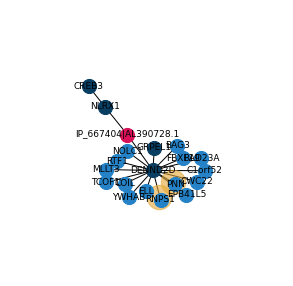

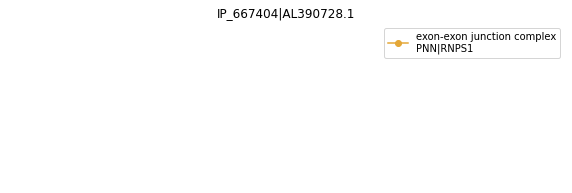

In [631]:
node = 'IP_667404|AL390728.1'
G_neig = get_2degneigb(G_o, node)
print(get_send_neigh_betweeness(G_neig, node))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.15, 'iterations':20},
                file_name='frontier_{}.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=0.7,
                GO=alt_subnets_GO[node],
                include_ledgend=True,
            )

0.5059523809523809


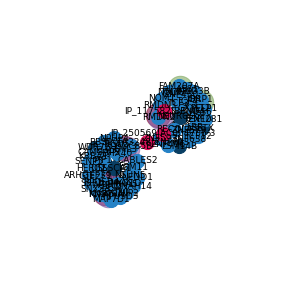

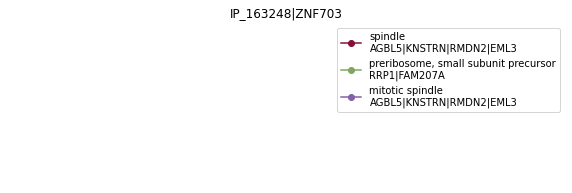

In [398]:
node = 'IP_163248|ZNF703'
G_neig = get_2degneigb(G_o, node)
print(get_send_neigh_betweeness(G_neig, node))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.15, 'iterations':20},
                file_name='cluster_{}.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=0.7,
                GO=alt_subnets_GO[node],
                include_ledgend=True,
            )

## disease association

In [1178]:
!wget https://www.disgenet.org/static/disgenet_ap1/files/downloads/curated_gene_disease_associations.tsv.gz

--2020-06-02 10:04:15--  https://www.disgenet.org/static/disgenet_ap1/files/downloads/curated_gene_disease_associations.tsv.gz
Resolving www.disgenet.org (www.disgenet.org)... 84.89.134.141
Connecting to www.disgenet.org (www.disgenet.org)|84.89.134.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1674155 (1.6M) [application/x-gzip]
Saving to: ‘curated_gene_disease_associations.tsv.gz’

curated_gene_diseas 100%[===================>]   1.60M  2.02MB/s    in 0.8s    

2020-06-02 10:04:16 (2.02 MB/s) - ‘curated_gene_disease_associations.tsv.gz’ saved [1674155/1674155]



In [83]:
with open('curated_gene_disease_associations.tsv', 'r') as f:
    disgenet = []
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys=ls
            continue
        line = dict(zip(keys, ls))
        if float(line['score'])<=0.3:continue
        disgenet.append(line)
print(len(disgenet))
pd.DataFrame(disgenet[:20])

32375


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998,2018,3,0,CTD_human
1,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1,2004,2019,1,0,CTD_human
2,2,A2M,0.529,0.769,C0024115,Lung diseases,group,C08,Disease or Syndrome,0.32,1,1983,1989,1,0,CTD_human
3,2,A2M,0.529,0.769,C0027726,Nephrotic Syndrome,group,C13;C12,Disease or Syndrome,0.51,1,1998,2001,1,0,CTD_human
4,2,A2M,0.529,0.769,C0206669,Hepatocellular Adenoma,disease,C06;C04,Neoplastic Process,0.50,1,2004,2004,1,0,CTD_human
5,2,A2M,0.529,0.769,C0276496,Familial Alzheimer Disease (FAD),disease,C10;F03,Disease or Syndrome,0.31,1,1998,2016,3,0,CTD_human
6,2,A2M,0.529,0.769,C0494463,"Alzheimer Disease, Late Onset",disease,C10;F03,Mental or Behavioral Dysfunction,0.37,0.8,1998,2010,3,0,CTD_human
7,2,A2M,0.529,0.769,C2239176,Liver carcinoma,disease,C06;C04,Neoplastic Process,0.51,1,2004,2004,1,0,CTD_human
8,2,A2M,0.529,0.769,C3279661,alpha-2-Macroglobulin Deficiency,disease,C08,Disease or Syndrome,0.31,1,1989,1989,0,0,CTD_human
9,9,NAT1,0.536,0.846,C0001973,"Alcoholic Intoxication, Chronic",disease,C25;F03,Mental or Behavioral Dysfunction,0.31,1,2000,2000,1,0,PSYGENET


In [84]:
n_genes = len(set(x['geneSymbol'] for x in disgenet))
n_diseases = len(set(x['diseaseName'] for x in disgenet))
n_assoc = len(disgenet)
print('Disgenet relates {} genes with {} diseases in {} associations.'.format(n_genes, n_diseases, n_assoc))

Disgenet relates 6970 genes with 8141 diseases in 32375 associations.


In [85]:
asso_scores = {((d['geneSymbol'], d['diseaseId'])):float(d['score']) for d in disgenet}

In [86]:
# TODO: no need for a list!! Change evrything to the dict, much easier to read..
gene_diseases_ls = [(d['geneSymbol'], d['diseaseId'] , d['diseaseSemanticType'], d['diseaseClass'], d['diseaseName']) for d in disgenet]

diseaseid_diseasename = {}
for diseaseid, grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    diseaseid_diseasename[diseaseid] = [x[4] for x in grp][0]
    
gene_diseases = {}
for gene, diseases in itt.groupby(sorted(gene_diseases_ls), lambda x: x[0]):
    gene_diseases[gene] = [x[1] for x in diseases]

disease_genes = {}
for disease, genes in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    disease_genes[disease] = [x[0] for x in genes]

disease_types = {}
for disease, disease_grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    distyp_set = set([x[2] for x in disease_grp])
    if len(distyp_set)>1:
        print(disease, distyp_set)
    disease_types[disease] = list(distyp_set)[0]

disease_classes = {}
for disease, disease_grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    disclass_set = set(x for y in [x[3].split(';') for x in disease_grp] for x in y)
    disease_classes[disease] = disclass_set

In [2872]:
# Contingency table
Fisher's exact test to verify wether disease genes are enriched in protein communities
(computed per disease for each community)
community genes, population genes
disease genes, 

null hypothesis: the cluster is not enriched in disease genes
alt  hypothesis: the cluster is enriched in disease genes

place all genes in contingency table:
                  in_clust              not_in_clust
    is_disease   intersect            non_comm disease genes
is_not_disease   non-disease comm     non-disease, non-comm genes

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 12)

In [89]:
clust_diseases = []
for clust_n, clust in clusters_dict.items():
    clust_genes = set(x for x in clust['graph'].nodes() if 'IP_' not in x and 'II_' not in x)
    non_clust_genes = pop - clust_genes
    assoc_diseases = set(x for y in [gene_diseases[x] for x in list(clust_genes) if x in gene_diseases] for x in y)
    for dis in assoc_diseases:
        dis_genes = set(disease_genes[dis])
        non_dis_genes = pop - dis_genes
        # Build a contingency table for each test
        cont_table = [[len(clust_genes.intersection(dis_genes)), len(dis_genes.difference(clust_genes))],
                      [len(clust_genes.difference(dis_genes)),   len(non_clust_genes.difference(dis_genes))]]
        odds_ratio, pval = stats.fisher_exact(cont_table, alternative='greater')
        # Run the test
        clust_diseases.append((clust_n, dis, odds_ratio, pval))

clust_diseases = sorted(clust_diseases, key=lambda x: x[-1])

clust_diseases_pvals = [x[-1] for x in clust_diseases]

fdr_bh = multipletests(clust_diseases_pvals, method='fdr_bh', alpha=0.01, is_sorted=True)
corrected_pvals = fdr_bh[1]
fdr_bh = fdr_bh[0]
sig_clust_diseases = list(itt.compress(clust_diseases, fdr_bh))

n_dieases = len(set(x[1] for x in sig_clust_diseases))
n_clust   = len(set(x[0] for x in sig_clust_diseases))
n_clust_alt = sum([clusters_dict[x]['contains_alt'] for x in list(set(x[0] for x in sig_clust_diseases))])
print('{} clusters of which {} contain at least one altProt are found in association with {} diseases in {} cluster-disease associations.'.format(
    n_clust, n_clust_alt, n_dieases, len(sig_clust_diseases)))

804 clusters of which 116 contain at least one altProt are found in association with 3668 diseases


In [90]:
for clust_n, diseases in itt.groupby(sorted(sig_clust_diseases), key=lambda x: x[0]):
    clusters_dict[clust_n]['diseases'] = [x[1:] for x in diseases]

In [125]:
for clust_n, clust in clusters_dict.items():
    if clust['contains_alt'] and 'diseases' in clust:
        clust['disease_gene_counts'] = {}
        for dis in clust['diseases']:
            clust['disease_gene_counts'][dis[0]] = set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]]))


C0221032
{'FOS'}
Nutritional and Metabolic Diseases|Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Skin and Connective Tissue Diseases
Familial generalized lipodystrophy

C0234533
{'FOS'}
Pathological Conditions, Signs and Symptoms|Nervous System Diseases
Generalized seizures

C0236804
{'FOS'}
Mental Disorders|Chemically-Induced Disorders
Amphetamine Addiction

C0242379
{'FOS', 'JUNB'}
Neoplasms|Respiratory Tract Diseases
Malignant neoplasm of lung

C0553580
{'ETV1'}
Neoplasms
Ewings sarcoma


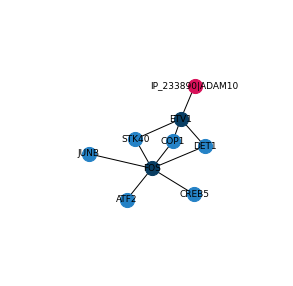

('cluster_123.svg', 'cluster_123_legend.svg')

In [153]:
node_size=200
clust_n = 123
for dis in clusters_dict[clust_n]['diseases']:
    print('\n'+dis[0])
    print(set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]])))
    print('|'.join([mesh_dict[d] if d in mesh_dict else 'no mesh class' for d in disease_classes[dis[0]]]))
    print(diseaseid_diseasename[dis[0]])

get_graph_vis(
            clusters_dict[clust_n]['graph'],
            'Clust #133',
            figsize=(5,5),
            node_size=node_size,
            alt_node_size=node_size,
            layout_params={'k':0.15, 'iterations':20},
            file_name='cluster_{}.svg'.format(clust_n),
            file_path='bioplex_figures/subnets/2nd_deg_neighb/',
            draw_labels=True,
            margin=0.7,
            include_ledgend=True,
        )


C0023467
{'ANXA2', 'S100A10'}
Neoplasms
Leukemia, Myelocytic, Acute

C0024517
{'S100A10'}
Mental Disorders
Major depression, single episode

C0029456
{'ANXA2'}
Nutritional and Metabolic Diseases|Musculoskeletal Diseases
Osteoporosis

C0278510
{'S100A10'}
Neoplasms
Childhood Medulloblastoma

C0278876
{'S100A10'}
Neoplasms
Adult Medulloblastoma

C0344315
{'S100A10'}
Behavior and Behavior Mechanisms
Depressed mood


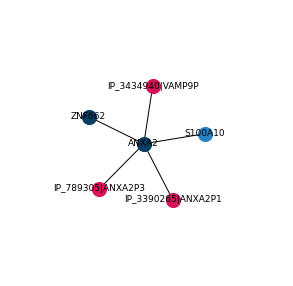

('cluster_277.svg', 'cluster_277_legend.svg')

In [154]:
clust_n = 277
for dis in clusters_dict[clust_n]['diseases']:
    print('\n'+dis[0])
    print(set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]])))
    print('|'.join([mesh_dict[d] if d in mesh_dict else 'no mesh class' for d in disease_classes[dis[0]]]))
    print(diseaseid_diseasename[dis[0]])

get_graph_vis(
            clusters_dict[clust_n]['graph'],
            'Clust #133',
            figsize=(5,5),
            node_size=node_size,
            alt_node_size=node_size,
            layout_params={'k':0.15, 'iterations':20},
            file_name='cluster_{}.svg'.format(clust_n),
            file_path='bioplex_figures/subnets/2nd_deg_neighb/',
            draw_labels=True,
            margin=0.7,
            include_ledgend=True,
        )


C0024433
{'FRAS1'}
Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Stomatognathic Diseases
Macrostomia

C0085129
{'ADAM33'}
Respiratory Tract Diseases
Bronchial Hyperreactivity

C0085584
{'NOTCH3'}
Nervous System Diseases
Encephalopathies

C0206648
{'NOTCH3'}
Neoplasms
Myofibromatosis

C0265233
{'FRAS1'}
Eye Diseases|Female Urogenital Diseases and Pregnancy Complications|Male Urogenital Diseases|Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Musculoskeletal Diseases
Cryptophthalmos syndrome

C0266294
{'FRAS1'}
Male Urogenital Diseases|Pathological Conditions, Signs and Symptoms|Female Urogenital Diseases and Pregnancy Complications
Unilateral agenesis of kidney

C0338656
{'NOTCH3'}
Mental Disorders
Impaired cognition

C0344487
{'NOTCH3'}
Pathological Conditions, Signs and Symptoms|Nervous System Diseases|Congenital, Hereditary, and Neonatal Diseases and Abnormalities
Lateral meningocele

C0432284
{'NOTCH3'}
Neoplasms
Infantile myofibromatosis

C0751587

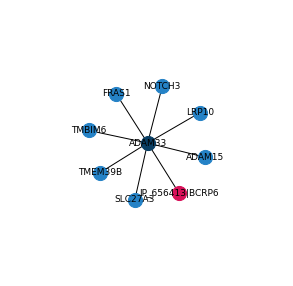

('cluster_133.svg', 'cluster_133_legend.svg')

In [155]:
clust_n = 133
for dis in clusters_dict[clust_n]['diseases']:
    print('\n'+dis[0])
    print(set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]])))
    print('|'.join([mesh_dict[d] if d in mesh_dict else 'no mesh class' for d in disease_classes[dis[0]]]))
    print(diseaseid_diseasename[dis[0]])

get_graph_vis(
            clusters_dict[clust_n]['graph'],
            'Clust #133',
            figsize=(5,5),
            node_size=node_size,
            alt_node_size=node_size,
            layout_params={'k':0.15, 'iterations':20},
            file_name='cluster_{}.svg'.format(clust_n),
            file_path='bioplex_figures/subnets/2nd_deg_neighb/',
            draw_labels=True,
            margin=0.7,
            include_ledgend=True,
        )


C0003496
{'FBN1'}
Wounds and Injuries|Cardiovascular Diseases
Aortic Rupture

C0003706
{'FBN1'}
Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Musculoskeletal Diseases
Arachnodactyly

C0010495
{'FBLN5', 'LTBP4'}
Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Skin and Connective Tissue Diseases
Cutis Laxa

C0013264
{'LTBP4'}
Nervous System Diseases|Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Musculoskeletal Diseases
Muscular Dystrophy, Duchenne

C0013581
{'FBN1'}
Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Eye Diseases
Ectopia Lentis

C0013990
{'FBLN5'}
Pathological Conditions, Signs and Symptoms
Pathological accumulation of air in tissues

C0024796
{'FBN1'}
Cardiovascular Diseases|Congenital, Hereditary, and Neonatal Diseases and Abnormalities|Musculoskeletal Diseases|Skin and Connective Tissue Diseases
Marfan Syndrome

C0162872
{'FBN1'}
Cardiovascular Diseases
Aortic Aneurysm, Thoracic

C0265287
{'FBN1'}
Congen

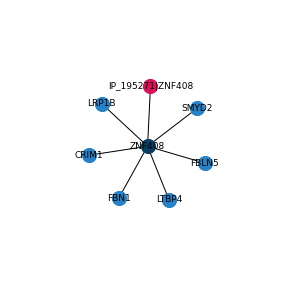

('cluster_199.svg', 'cluster_199_legend.svg')

In [156]:
clust_n = 199
for dis in clusters_dict[clust_n]['diseases']:
    print('\n'+dis[0])
    print(set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]])))
    print('|'.join([mesh_dict[d] if d in mesh_dict else 'no mesh class' for d in disease_classes[dis[0]]]))
    print(diseaseid_diseasename[dis[0]])

get_graph_vis(
            clusters_dict[clust_n]['graph'],
            'Clust #133',
            figsize=(5,5),
            node_size=node_size,
            alt_node_size=node_size,
            layout_params={'k':0.15, 'iterations':20},
            file_name='cluster_{}.svg'.format(clust_n),
            file_path='bioplex_figures/subnets/2nd_deg_neighb/',
            draw_labels=True,
            margin=0.7,
            include_ledgend=True,
        )

In [293]:
# disease association Graph
G_clustdis = nx.Graph()
node_attr_dict = {}
for clust_n, diseaseid, OR, pval in sig_clust_diseases:
    node_attr_dict.update({
        clust_n:{
            'node_type':'clust', 
            'contains_alt':clusters_dict[clust_n]['contains_alt']
        }, 
        diseaseid:{
            'node_type':'disease'
        }
    })
    G_clustdis.add_edge(clust_n, diseaseid)
nx.set_node_attributes(G_clustdis, node_attr_dict)

In [95]:
# MeSh
mesh = "Infections [C01];\
Neoplasms [C04];\
Musculoskeletal Diseases [C05];\
Digestive System Diseases [C06];\
Stomatognathic Diseases [C07];\
Respiratory Tract Diseases [C08];\
Otorhinolaryngologic Diseases [C09];\
Nervous System Diseases [C10];\
Eye Diseases [C11];\
Male Urogenital Diseases [C12];\
Female Urogenital Diseases and Pregnancy Complications [C13];\
Cardiovascular Diseases [C14];\
Hemic and Lymphatic Diseases [C15];\
Congenital, Hereditary, and Neonatal Diseases and Abnormalities [C16];\
Skin and Connective Tissue Diseases [C17];\
Nutritional and Metabolic Diseases [C18];\
Endocrine System Diseases [C19];\
Immune System Diseases [C20];\
Disorders of Environmental Origin [C21];\
Animal Diseases [C22];\
Pathological Conditions, Signs and Symptoms [C23];\
Occupational Diseases [C24];\
Chemically-Induced Disorders [C25];\
Wounds and Injuries [C26];\
Behavior and Behavior Mechanisms [F01];\
Psychological Phenomena [F02];\
Mental Disorders [F03] "

mesh = [[x.strip().replace(']','') for x in m.split('[')] for m in mesh.split(';')]

mesh_dict = {x[1]:x[0] for x in mesh}

mesh_dict

{'C01': 'Infections',
 'C04': 'Neoplasms',
 'C05': 'Musculoskeletal Diseases',
 'C06': 'Digestive System Diseases',
 'C07': 'Stomatognathic Diseases',
 'C08': 'Respiratory Tract Diseases',
 'C09': 'Otorhinolaryngologic Diseases',
 'C10': 'Nervous System Diseases',
 'C11': 'Eye Diseases',
 'C12': 'Male Urogenital Diseases',
 'C13': 'Female Urogenital Diseases and Pregnancy Complications',
 'C14': 'Cardiovascular Diseases',
 'C15': 'Hemic and Lymphatic Diseases',
 'C16': 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
 'C17': 'Skin and Connective Tissue Diseases',
 'C18': 'Nutritional and Metabolic Diseases',
 'C19': 'Endocrine System Diseases',
 'C20': 'Immune System Diseases',
 'C21': 'Disorders of Environmental Origin',
 'C22': 'Animal Diseases',
 'C23': 'Pathological Conditions, Signs and Symptoms',
 'C24': 'Occupational Diseases',
 'C25': 'Chemically-Induced Disorders',
 'C26': 'Wounds and Injuries',
 'F01': 'Behavior and Behavior Mechanisms',
 'F02': 'Psychologic

In [96]:
dis_classes = list(mesh_dict.keys())

In [314]:
dis_class_summary = {d:{'alt_clust':0, 'no_alt_clust':0} for d in dis_classes}
for dis_class in dis_classes:
    for clust_n, diseaseid, OR, pval in sig_clust_diseases:
        if dis_class in disease_classes[diseaseid]:
            if clusters_dict[clust_n]['contains_alt']:
                dis_class_summary[dis_class]['alt_clust'] += 1
            else:
                dis_class_summary[dis_class]['no_alt_clust'] += 1

In [315]:
dis_class_summary

{'C01': {'alt_clust': 9, 'no_alt_clust': 73},
 'C04': {'alt_clust': 88, 'no_alt_clust': 873},
 'C05': {'alt_clust': 89, 'no_alt_clust': 647},
 'C06': {'alt_clust': 18, 'no_alt_clust': 267},
 'C07': {'alt_clust': 7, 'no_alt_clust': 112},
 'C08': {'alt_clust': 16, 'no_alt_clust': 113},
 'C09': {'alt_clust': 16, 'no_alt_clust': 87},
 'C10': {'alt_clust': 159, 'no_alt_clust': 1135},
 'C11': {'alt_clust': 47, 'no_alt_clust': 269},
 'C12': {'alt_clust': 31, 'no_alt_clust': 250},
 'C13': {'alt_clust': 37, 'no_alt_clust': 307},
 'C14': {'alt_clust': 42, 'no_alt_clust': 301},
 'C15': {'alt_clust': 27, 'no_alt_clust': 349},
 'C16': {'alt_clust': 201, 'no_alt_clust': 1571},
 'C17': {'alt_clust': 46, 'no_alt_clust': 453},
 'C18': {'alt_clust': 80, 'no_alt_clust': 588},
 'C19': {'alt_clust': 36, 'no_alt_clust': 273},
 'C20': {'alt_clust': 23, 'no_alt_clust': 227},
 'C21': {'alt_clust': 0, 'no_alt_clust': 0},
 'C22': {'alt_clust': 0, 'no_alt_clust': 0},
 'C23': {'alt_clust': 93, 'no_alt_clust': 550}

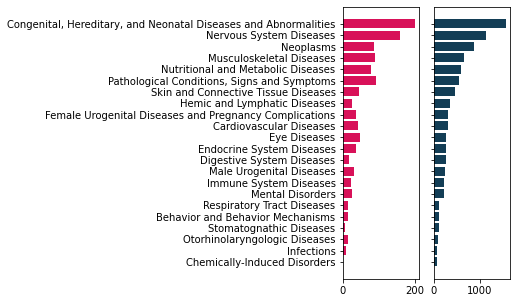

In [340]:
fig, axs = plt.subplots(1,2,figsize=(3,5), sharey=True, facecolor='w')
height=0.8
disclasses, alt_cnts, no_alt_cnts, alt_percent = \
list(zip(*sorted([(k, v['alt_clust'], v['no_alt_clust'], 100*v['alt_clust']/(v['alt_clust']+v['no_alt_clust'])) for k,v in dis_class_summary.items() if  v['alt_clust']+v['no_alt_clust']>10], key=lambda x: sum(x[1:3]))))
axs[0].barh([mesh_dict[d] for d in disclasses], alt_cnts, color='#d81159', height=height)

#plt.xticks([5, 10, 15, 20])
axs[1].barh([mesh_dict[d] for d in disclasses], no_alt_cnts, color='#133e56', height=height)
#plt.xscale('log')
#plt.xticks([0, 500, 1000, 1500])
plt.savefig('bioplex_figures/disease_counts_bar.svg')
plt.show()

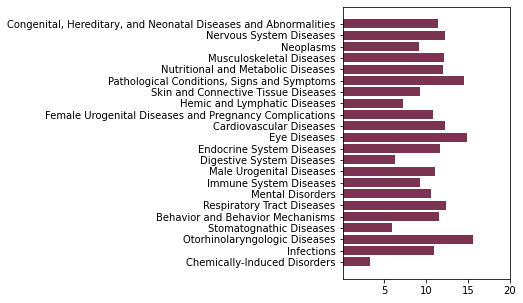

In [325]:
fig, ax = plt.subplots(figsize=(3,5))
disclasses, alt_percent, alt_clust, alt_no_clust = \
list(zip(*sorted([(k, 100*v['alt_clust']/(v['no_alt_clust']+v['alt_clust']), v['alt_clust'], v['no_alt_clust']) for k,v in dis_class_summary.items() if  v['alt_clust']+v['no_alt_clust']>10], key=lambda x: sum(x[2:]))))
ax.barh([mesh_dict[d] for d in disclasses], alt_percent, color='#7a3350', height=height)
plt.xticks([5, 10, 15, 20])
#ax.barh([mesh_dict[d] for d in disclasses], no_alt_cnts, color='#133e56', left=alt_cnts)
plt.savefig('bioplex_figures/disease_ratio_bar.svg')
plt.show()

## new proteins in known complexes/communities (CORUM)

In [402]:
!wget http://mips.helmholtz-muenchen.de/corum/download/coreComplexes.txt.zip

--2020-06-25 20:08:39--  http://mips.helmholtz-muenchen.de/corum/download/coreComplexes.txt.zip
Resolving mips.helmholtz-muenchen.de (mips.helmholtz-muenchen.de)... 146.107.217.142
Connecting to mips.helmholtz-muenchen.de (mips.helmholtz-muenchen.de)|146.107.217.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667990 (652K) [application/zip]
Saving to: ‘coreComplexes.txt.zip’

coreComplexes.txt.z 100%[===================>] 652.33K  1.07MB/s    in 0.6s    

2020-06-25 20:08:40 (1.07 MB/s) - ‘coreComplexes.txt.zip’ saved [667990/667990]



In [ ]:
hgnc_entrez_dict  = {}
hgnc_synonym_dict  = {}
hgnc_id_dict = {}
hgnc_genes = []
with open('hgnc_entrez.txt', 'r') as f:
    for n,l in enumerate (f):
        if n==0:
            #print(l)
            continue
        ls = l.split('\t')
        symbol    = ls[1].strip()
        synonyms  = ls[5].strip()
        entrez_id = ls[6].strip()
        hgnc_id = int(ls[0].strip())
        hgnc_id_dict[hgnc_id] = symbol
        entrez_id_ncbi = ls[7].strip()
        if 'withdrawn' not in symbol:
            #symbol = symbol.split('~')[0]
            hgnc_genes += [symbol]
        if entrez_id != '':
            hgnc_entrez_dict[entrez_id] = symbol
        elif entrez_id_ncbi != '':
            hgnc_entrez_dict[entrez_id_ncbi] = symbol
        if synonyms != '':
            hgnc_synonym_dict.update({x: symbol for x in synonyms.split(', ')})
hgnc_genes = set(hgnc_genes)
hgnc_int_entrez_dict = {int(k) : v for k,v in hgnc_entrez_dict.items()}

import re
corum = []
missing_ids = []
with open('coreComplexes.txt', 'r') as f:
    for n,l in enumerate(f):
        ls = l.split('\t')        
        if n==0:
            fields = [x.replace('"','').strip() for x in ls if x.replace('"','').strip()]
            continue
            
        row = {}
        for n,field in enumerate(fields):
            row[field] = ls[n].strip()
            
        if row['Organism']!='Human': continue

        if row['subunits(Entrez IDs)'] != '':
            entrz_ids = row['subunits(Entrez IDs)'].split(';')
            if any(x=='None' for x in entrz_ids):
                print(row['ComplexName'])
                continue
            row['subunits(Entrez IDs)'] = [int(re.sub("\D", "", x)) for x in entrz_ids]
        if row['Protein complex purification method'] != '':
            row['Protein complex purification method'] = [x.strip() for x in row['Protein complex purification method'].split('|')]
        
        en_ids = []
        for en_id in row['subunits(Entrez IDs)']:
            if en_id not in hgnc_int_entrez_dict.keys():
                missing_ids += [(en_id, row['subunits(Entrez IDs)'])]
                continue
            en_ids += [en_id]
        row['subunits (HGNC)'] = [hgnc_int_entrez_dict[x] for x in en_ids]
        corum.append(row)

In [1006]:
def draw_circ_layout_complx(G, edges_HGNC, baits_HGNC, ax):
    node_colors, edge_colors, edge_widths = color_circ_CORUM_complx(G, edges_HGNC, baits_HGNC)
    layout =  nx.drawing.layout.circular_layout(G.nodes())
    nx.draw_networkx_nodes(G, layout, node_size=1700, node_color=node_colors, edgecolors='#787878', ax=ax)
    nx.draw_networkx_edges(G, layout, edge_color=edge_colors, width=edge_widths, ax=ax)
    nx.draw_networkx_labels(G, layout, ax=ax)

def color_circ_CORUM_complx(complx, ref_net, ref_net_baits, colors = {'bait':'#093e63', 'prey':'#2582c6', 'no_id':'#787878'}, h_edge_width=4, l_edge_width=1):
    edge_colors, node_colors, edge_widths = [], [], []
    overlap = ref_net.intersection(set(frozenset((x)) for x in complx.edges()))
    for ppi in complx.edges():
        edge_color = colors['no_id']
        edge_width = l_edge_width
        if frozenset((ppi)) in overlap:
            edge_color = colors['bait']
            node_color = colors['prey']
            edge_width = h_edge_width
        edge_colors += [edge_color]
        edge_widths += [edge_width]
    
    for p in complx.nodes():
        if p in ref_net_baits:
            node_color = colors['bait']
        elif p in set(x for y in overlap for x in y):
            node_color = colors['prey']
        else:
            node_color = colors['no_id']
        node_colors += [node_color]
    return node_colors, edge_colors, edge_widths

In [1007]:
def compute_complex_coverage(subunits, ref_edge_set, baits):
    subunits = set(subunits)
    pairwise_complx = set(frozenset((b, p)) for b, p in itt.permutations(subunits, 2))
    prots_in_comp   = set(x for y in list(ref_edge_set.intersection(pairwise_complx)) for x in y)
    #prots_in_comp = prots_in_comp.union(subunits.intersection(baits))
    return len(prots_in_comp) / len(subunits)

for complx in corum:
    complx['coverage'] = compute_complex_coverage(complx['subunits (HGNC)'], G_o_edges, HCIP_baits)

for complx in corum:
    overlap_nodes = set(complx['subunits (HGNC)']).intersection(set(G_o.nodes()))
    complx['alt_edges'] = set()
    for node in overlap_nodes:
            first_neibs = G_o.neighbors(node)
            for n in first_neibs:
                if is_alt(n):
                    complx['alt_edges'].add(frozenset((node, n)))

In [1205]:
coverage_2baits_complx = []
comrum_2baits = []
for complx in corum:
    bait_overlap = len(HCIP_baits.intersection(set(complx['subunits (HGNC)'])))
    if bait_overlap > 1 and complx['coverage']>0:
        coverage_2baits_complx.append(complx['coverage'])
        comrum_2baits.append(complx)

len(coverage_2baits_complx)

218

In [1641]:
def get_ordered_baitprey(baitprey):
    baitprey = list(baitprey)
    if is_alt(baitprey[0]):
        baitprey = baitprey[::-1]
    return baitprey

In [1204]:
len([x for x in comrum_2baits if x['coverage']>0])

218

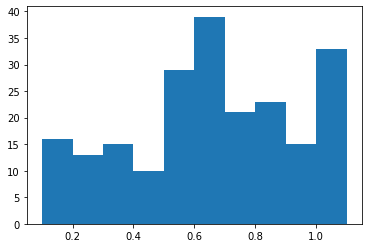

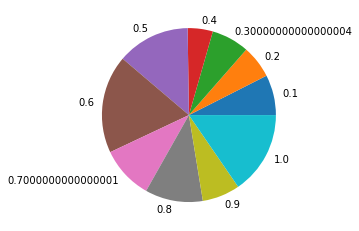

In [1010]:
h = plt.hist(coverage_2baits_complx, bins=np.linspace(0.1, 1.1, 11))
cnts, cov, _ = h
plt.show()

plt.pie(cnts, labels=cov[:-1])
plt.savefig('bioplex_figures/CORUM_pie.svg')
plt.show()